In [1]:
# https://medium.com/@erikhallstrm/hello-world-rnn-83cd7105b767
DEBUG = True

import re, random, math, csv, io, string, itertools, sys
import numpy as np
# import pandas as pd
import tensorflow as tf

/Users/roman/py3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [23]:
def test_data_1(n_unrollings=100, echo_step=2, batch_size=5):
    x = np.array(np.random.choice(2, n_unrollings, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

In [237]:
class RNN:
    hp = dict(
        batch_sz=20,
        backprop_len=5,
        n_classes=2,
        state_sz=3,
        ckpt_path="./checkpoints/"
    )
    def __init__(self, **hyper_parameters):
        if hyper_parameters is not None:
            for k, v in hyper_parameters.items():
                self.hp[k] = v
    
    def _init_graph(self):
        tf.reset_default_graph()
        self.inputs_batch = tf.placeholder(tf.float32, [None, self.hp['backprop_len']], "inputs_batch")
        self.labels_batch = tf.placeholder(tf.int32, [None, self.hp['backprop_len']], "labels_batch")
        self.init_state = tf.placeholder(tf.float32,   [None, self.hp['state_sz']],     "init_state")
        
        self.w_tarns = tf.Variable(
            np.random.rand(
                self.hp['state_sz']+1, #prev_state + 1 for inputs
                self.hp['state_sz']
            ), 
            dtype=tf.float32
        )            
        self.b_trans = tf.Variable(np.zeros([1,self.hp['state_sz']]), dtype=tf.float32)
        self.w_out = tf.Variable(np.random.rand(self.hp["state_sz"], self.hp["n_classes"]), dtype=tf.float32)
        self.b_out = tf.Variable(np.zeros([1,self.hp['n_classes']]), dtype=tf.float32)
        
        self.inputs_seq = tf.unstack(self.inputs_batch, axis=1)
        self.labels_seq = tf.unstack(self.labels_batch, axis=1)

    def _forward(self):
        curr_state = self.init_state
        state_seq = []
        for curr_input in self.inputs_seq:
            curr_input = tf.reshape(curr_input, [-1, 1])
            comm = tf.concat([curr_input, curr_state],axis=1)
            next_state = tf.matmul(comm, self.w_tarns) + self.b_trans
            state_seq.append(next_state)
            curr_state = next_state
            
        self.curr_state = curr_state
        self.logits_seq = [tf.matmul(state,self.w_out)+self.b_out for state in state_seq]
        
        
    def _train_graph(self):
        self._init_graph()
        self._forward()
        
        losses = [
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits = logits,
                labels = labels
            ) 
            for logits, labels in zip(self.logits_seq, self.labels_seq)
        ]
        self.total_loss = tf.reduce_mean(losses)
        self.train_step = tf.train.AdagradOptimizer(0.3).minimize(self.total_loss)
        
    
    def _infer_graph(self):
        self._init_graph()
        self._forward()
        self.preds_seq = [tf.nn.softmax(logit) for logit in self.logits_seq]
        
    def predict(self,x):
        nobs = np.shape(x)[0]
        self._infer_graph()
        prediction=[]
        if nobs<self.hp["backprop_len"]:
            x = np.pad(x, (0, self.hp["backprop_len"] - nobs),mode="constant")
        with tf.Session() as sess:
            sess.run(tf.initialize_all_variables())
            ckpt = tf.train.get_checkpoint_state("checkpoints")
            n_batches = 1 + int(nobs>self.hp['backprop_len'])*(nobs - self.hp['backprop_len'])
            start_idx = 0
            end_idx = self.hp["backprop_len"]
            curr_state = np.zeros([1, self.hp['state_sz']])
            is_first = True
            for batch_num in range(n_batches):
                x_batch = [x[start_idx:]]
                pred = sess.run(
                    [self.preds_seq],
                    feed_dict={
                        self.inputs_batch:x_batch,
                        self.init_state:curr_state
                    }
                )
                if is_first:
                    prediction.extend(pred)
                    is_first=False
                else:
                    prediction.append(pred[-1])
        return prediction[0][:nobs]
    
    def train(self, data_generator, n_epochs=10):
        self._train_graph()
        with tf.Session() as sess:
            train_writer = tf.summary.FileWriter( './mdl_tr', sess.graph)
            sess.run(tf.initialize_all_variables())
            losses=[]
            for epoch_num in range(n_epochs):
                x,y = data_generator()
                nobs = np.shape(x)[1]
                curr_state = np.zeros([np.shape(x)[0], self.hp['state_sz']])
                n_batches = nobs//self.hp['backprop_len']
                for batch_num in range(n_batches):
                    start_idx = batch_num * self.hp["backprop_len"]
                    end_idx = start_idx + min(nobs-start_idx, self.hp["backprop_len"])
                    
                    x_batch = x[:, start_idx:end_idx]
                    y_batch = y[:, start_idx:end_idx]
#                     merge = tf.summary.merge_all()
                    train_step, loss, curr_state = sess.run(
                        [self.train_step, self.total_loss, self.curr_state],
                        feed_dict={
                            self.inputs_batch:x_batch,
                            self.labels_batch:y_batch,
                            self.init_state:curr_state
                        }
                    )
                    print(f"loss={loss}")
#                 train_writer.add_summary(summary, epoch_num)
                saver = tf.train.Saver()
                saver.save(sess, self.hp['ckpt_path'] + "nn.mdl", global_step=epoch_num)

In [238]:
rnn = RNN()

In [244]:
rnn.train(data_generator=lambda : test_data_1(n_unrollings=1000, batch_size=50),n_epochs=1000)

loss=0.7647901177406311
loss=0.7111560702323914
loss=1.9681367874145508
loss=1.2298109531402588
loss=0.6964120268821716
loss=0.6961074471473694
loss=0.7050021290779114
loss=0.6803110241889954
loss=0.7036243677139282
loss=0.6827672719955444
loss=0.6882038116455078
loss=0.6829559803009033
loss=0.6848050951957703
loss=0.6871846914291382
loss=0.6793116331100464
loss=0.6795570850372314
loss=0.6836469173431396
loss=0.6679115891456604
loss=0.6735451817512512
loss=0.6666637063026428
loss=0.6829448342323303
loss=0.6703770160675049
loss=0.6597458720207214
loss=0.6695711612701416
loss=0.6689662337303162
loss=0.6666176915168762
loss=0.6492763161659241
loss=0.6482757329940796
loss=0.666335940361023
loss=0.6390196084976196
loss=0.6344332695007324
loss=0.6138538122177124
loss=0.6396069526672363
loss=0.5991194844245911
loss=0.5901031494140625
loss=0.5813279747962952
loss=0.6035639643669128
loss=0.5446926355361938
loss=0.556766927242279
loss=0.5278528928756714
loss=0.6107901930809021
loss=0.51542174816

loss=0.2807186245918274
loss=0.0004886441165581346
loss=0.0004716351395472884
loss=0.00045882220729254186
loss=0.2775271534919739
loss=0.00048776500625535846
loss=0.000483983923913911
loss=0.00047930076834745705
loss=0.2810673117637634
loss=0.0004346280184108764
loss=0.0004201510746497661
loss=0.0004252703511156142
loss=0.27985164523124695
loss=0.00043498718878254294
loss=0.00042557381675578654
loss=0.00041085906559601426
loss=0.27808040380477905
loss=0.0004477497423067689
loss=0.00047450908459722996
loss=0.00045525984023697674
loss=0.2786206603050232
loss=0.0004543800896499306
loss=0.00041483977111056447
loss=0.00044456118484959006
loss=0.2798137068748474
loss=0.00039564227336086333
loss=0.00040368278860114515
loss=0.0003778320096898824
loss=0.27609142661094666
loss=0.0003819019184447825
loss=0.00039390134043060243
loss=0.00038342387415468693
loss=0.2768658995628357
loss=0.0003900863812305033
loss=0.0003767981252167374
loss=0.0003838171251118183
loss=0.278288871049881
loss=0.000391169

loss=0.2809703052043915
loss=0.00018161906336899847
loss=0.0001824981882236898
loss=0.0001803976047085598
loss=0.2778356373310089
loss=0.00018699474458117038
loss=0.00018413162615615875
loss=0.00018242813530378044
loss=0.27733829617500305
loss=0.00017527931777294725
loss=0.000175344233866781
loss=0.00017004426626954228
loss=0.27855488657951355
loss=0.00016967617557384074
loss=0.00017047049186658114
loss=0.0001648281468078494
loss=0.27549105882644653
loss=0.00016955978935584426
loss=0.00016555078036617488
loss=0.0001674334635026753
loss=0.2762586772441864
loss=0.00016563509416300803
loss=0.00016371662786696106
loss=0.0001622910931473598
loss=0.28371304273605347
loss=0.00018052832456305623
loss=0.0001808670349419117
loss=0.00019320707360748202
loss=0.27780869603157043
loss=0.00016732796211726964
loss=0.000163360993610695
loss=0.00017107727762777358
loss=0.2766543924808502
loss=0.00016205417341552675
loss=0.00016184395644813776
loss=0.00015751506725791842
loss=0.2773675322532654
loss=0.00

loss=0.281470388174057
loss=0.00013423980271909386
loss=0.00013299378042574972
loss=0.00012072062236256897
loss=0.2739930748939514
loss=0.00013199783279560506
loss=0.00013760033471044153
loss=0.00012771147885359824
loss=0.28053534030914307
loss=0.00011812165030278265
loss=0.00011948591418331489
loss=0.000118697811558377
loss=0.2840959429740906
loss=0.00011105881276307628
loss=0.00010765469778561965
loss=0.00010758508142316714
loss=0.2807087004184723
loss=0.00011102829739684239
loss=0.0001154875208158046
loss=0.00011303683277219534
loss=0.2779864966869354
loss=0.00011041398829547688
loss=0.00011034728231607005
loss=0.00011181669833604246
loss=0.27752912044525146
loss=0.00010571398888714612
loss=0.00010581553215160966
loss=0.00011086128506576642
loss=0.2769428491592407
loss=0.00011097008245997131
loss=0.00010491831199033186
loss=0.00010570593440206721
loss=0.27493444085121155
loss=0.00010457662574481219
loss=0.00010399352322565392
loss=0.00010889145778492093
loss=0.2786993980407715
loss=

loss=0.2785457372665405
loss=8.161716687027365e-05
loss=8.294842700706795e-05
loss=8.324543159687892e-05
loss=0.2824306786060333
loss=8.546101162210107e-05
loss=8.362632797798142e-05
loss=8.413219620706514e-05
loss=0.27661046385765076
loss=8.183898171409965e-05
loss=8.156293188221753e-05
loss=8.324125519720837e-05
loss=0.28114527463912964
loss=8.526457531843334e-05
loss=8.194895781343803e-05
loss=8.587773481849581e-05
loss=0.2797083258628845
loss=8.869796147337183e-05
loss=8.827122655929998e-05
loss=9.36479409574531e-05
loss=0.27376872301101685
loss=8.78581777215004e-05
loss=8.79115323186852e-05
loss=9.95494265225716e-05
loss=0.27651479840278625
loss=9.566509106662124e-05
loss=9.177689207717776e-05
loss=8.47938863444142e-05
loss=0.28128358721733093
loss=8.897701627574861e-05
loss=8.473553316434845e-05
loss=8.346632967004552e-05
loss=0.2783757746219635
loss=8.555227395845577e-05
loss=8.627368515590206e-05
loss=8.57129562064074e-05
loss=0.2772585451602936
loss=8.64515095599927e-05
loss=8

KeyboardInterrupt: 

In [245]:
rnn.predict([0,1,0,1,0])

[array([[0.5, 0.5]], dtype=float32),
 array([[0.4683488 , 0.53165126]], dtype=float32),
 array([[0.46571723, 0.5342828 ]], dtype=float32),
 array([[0.4286468 , 0.57135314]], dtype=float32),
 array([[0.41735902, 0.58264095]], dtype=float32)]

In [233]:
test_data_1(n_unrollings=3000, batch_size=150)

(array([[0, 1, 1, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 1, 1, ..., 0, 1, 1],
        [0, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 1, 1, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [1, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 1, 0, ..., 1, 1, 0],
        [1, 1, 0, ..., 0, 1, 0],
        [0, 0, 1, ..., 1, 1, 1]]))

<Figure size 432x288 with 0 Axes>

New data, epoch 0
Step 0 Loss 1.0212492
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 0 1 0 0 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 1 1 1 0 1 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 1 1 1 1 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 1 1 0 1 1 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 1 1 1 0 0 1 0 0]



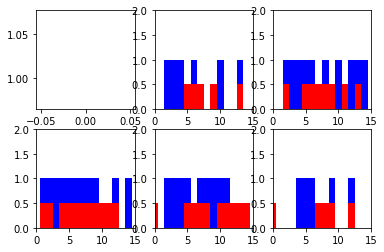

Step 100 Loss 0.70498085
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 1 0 0 0 1 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 0 1 1 0 0 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 0 1 0 1 0 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 1 1 0 1 1 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 1 0 1 0 0 0 0 0]



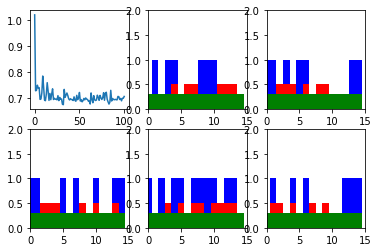

Step 200 Loss 0.6934258
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 0 1 0 1 1 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 0 0 1 1 0 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 0 1 0 0 0 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 1 1 0 0 1 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 1 0 1 0 0 0 1 0]



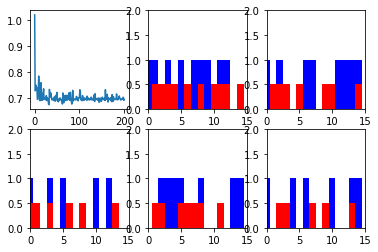

Step 300 Loss 0.69362706
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 0 1 0 1 1 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 0 1 1 1 1 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 0 0 1 0 1 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 1 0 1 1 1 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 1 0 0 1 0 1 0 1]



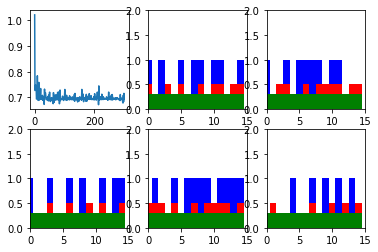

Step 400 Loss 0.69691867
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 0 1 0 0 1 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 0 0 0 1 0 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 1 0 1 0 0 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 0 0 0 1 1 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 0 0 1 0 0 1 1 0]



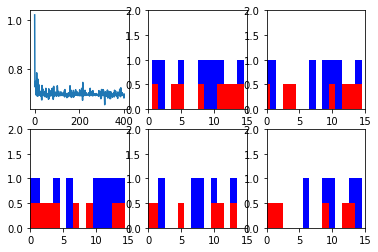

Step 500 Loss 0.67847943
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 0 0 0 0 0 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 0 0 1 1 0 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 0 0 1 0 0 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 0 1 0 0 0 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 0 1 0 0 1 0 1 0]



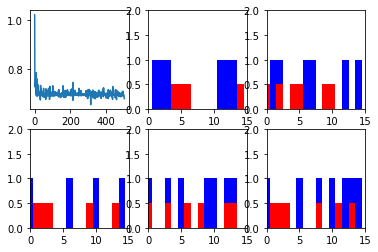

Step 600 Loss 0.6963569
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 1 1 1 1 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 0 0 0 1 1 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 1 0 1 0 0 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 1 0 1 1 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 1 0 1 0 0 1 0]



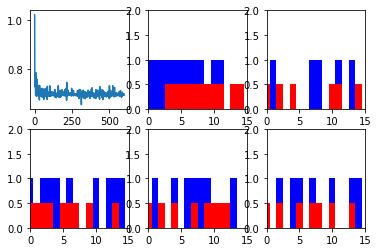

New data, epoch 1
Step 0 Loss 0.6908629
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 1 1 0 0 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 1 0 1 0 0 1 0 1]

single_output_series: [1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 1 1 0 0 0 0 1 1]

single_output_series: [1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 1 1 1 1 0 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 0 1 0 0 1 1 0]



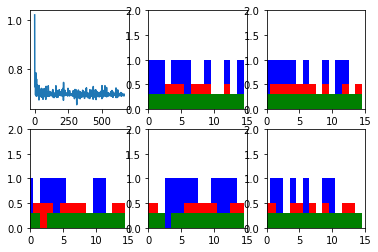

Step 100 Loss 0.6923983
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 1 1 0 0 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 0 1 0 1 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 0 1 1 1 0 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 1 1 0 0 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 1 1 1 1 1 0 0 0]



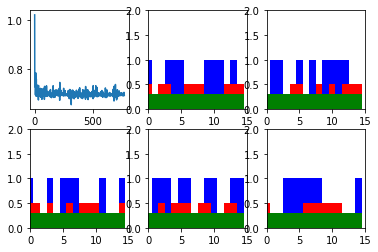

Step 200 Loss 0.6977034
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 1 0 1 1 0 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 1 0 0 1 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 1 1 1 1 0 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 1 1 1 0 1 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 0 1 0 0 0 0 1]



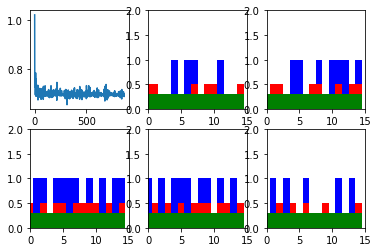

Step 300 Loss 0.6948954
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 0 1 0 1 1 1 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 0 0 1 1 1 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 1 1 1 0 1 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 0 1 0 1 0 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 1 1 0 1 1 1 1 0]



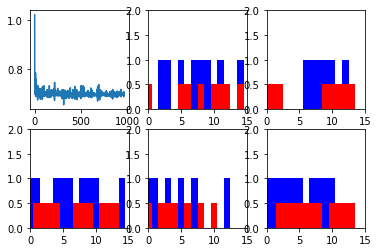

Step 400 Loss 0.69109094
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 1 1 1 1 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 0 0 0 1 0 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 1 0 0 1 0 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 1 0 1 0 0 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 1 1 1 0 1 1 0 1]



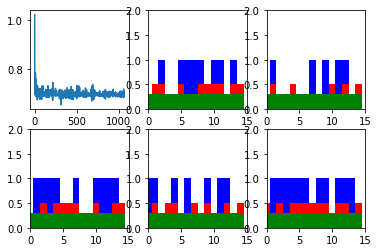

Step 500 Loss 0.6925661
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 0 0 1 0 1 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 1 1 1 1 0 1 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 1 0 0 0 0 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 1 1 0 1 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 1 0 1 0 1 1 1 0]



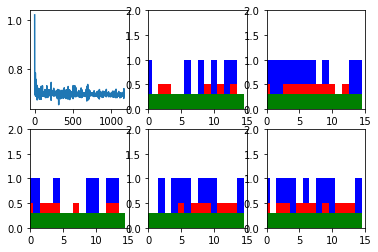

Step 600 Loss 0.6925054
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 0 1 1 1 0 0 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 1 1 1 0 1 1 1 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 1 1 1 1 0 0 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 1 1 0 0 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 0 1 1 1 0 0 1 0]



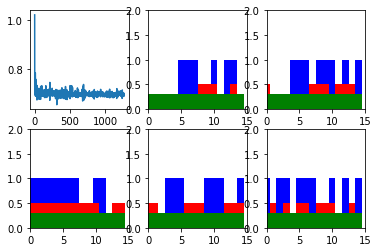

New data, epoch 2
Step 0 Loss 0.6954263
single_output_series: [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 0 0 1 1 1 0 0 1]

single_output_series: [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 0 1 1 0 0 1 0 1]

single_output_series: [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 1 0 0 0 1 1 0 1]

single_output_series: [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 1 0 0 1 0 1 0 0]

single_output_series: [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 1 0 1 1 1 1 0 1]



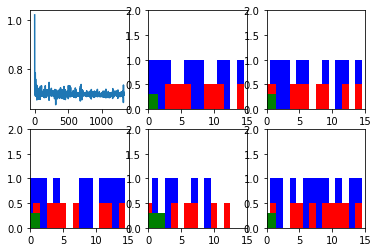

Step 100 Loss 0.6913789
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 1 1 1 1 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 0 0 1 0 0 1 1 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 1 0 1 0 0 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 1 0 0 0 0 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 1 0 1 1 1 1 1 1]



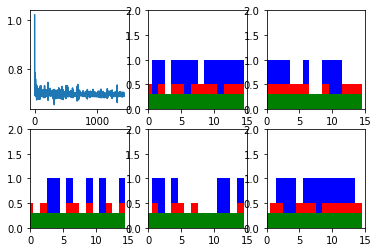

Step 200 Loss 0.7025268
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 1 0 0 0 0 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 1 1 0 0 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 1 0 1 0 0 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 1 1 1 0 0 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 1 0 1 0 0 1 1]



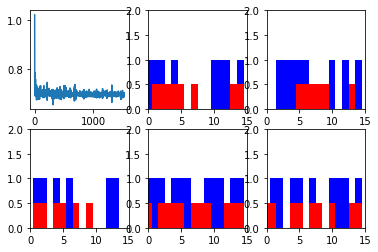

Step 300 Loss 0.6939935
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 1 1 0 1 1 0 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 1 1 1 1 0 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 1 1 0 1 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 0 0 1 1 1 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 1 0 1 0 1 1 0 1]



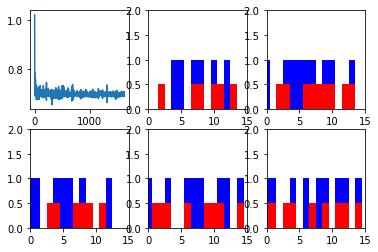

Step 400 Loss 0.70191246
single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 0 0 1 0 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 0 1 0 0 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 0 1 1 1 1 0 0 0]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 1 1 1 1 0 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 1 0 1 1 0 1 1 1]



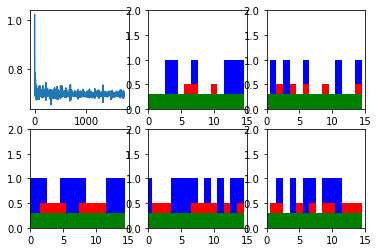

Step 500 Loss 0.6944577
single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 0 1 0 0 1 0 0 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 0 0 0 1 0 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 0 0 0 1 0 0 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 0 1 0 0 1 1 1 1]

single_output_series: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 0 1 1 1 1 0 1 1]



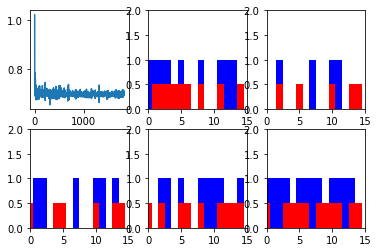

Step 600 Loss 0.677527
single_output_series: [0 1 0 1 0 0 1 0 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 0 1 1 1 0 1 0 1]

single_output_series: [1 0 1 1 1 0 1 0 0 1 0 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 0 1 0 0 1 0 1 1]

single_output_series: [0 1 0 1 0 0 1 0 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 0 1 0 0 1 1 1 1]

single_output_series: [1 0 1 0 1 0 1 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 0 0 0 0 1 1 1 0]

single_output_series: [1 1 0 0 1 0 1 0 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 1 1 0 0 1 0 1 0]



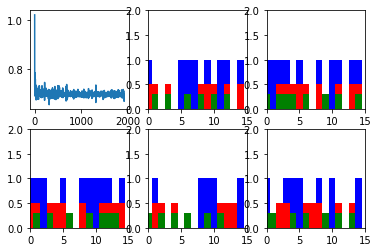

New data, epoch 3
Step 0 Loss 0.5840979
single_output_series: [0 0 0 0 0 1 0 1 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 1 0 1 1 0 0 0 0]

single_output_series: [0 0 1 0 1 1 0 1 0 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 1 1 0 0 0 0 1 0]

single_output_series: [1 1 0 1 0 1 1 0 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 0 1 0 1 1 1 0 0]

single_output_series: [1 1 0 1 0 1 0 0 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 1 1 0 0 1 1 0 1]

single_output_series: [0 0 0 1 0 1 0 1 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 0 1 0 1 1 0 0]



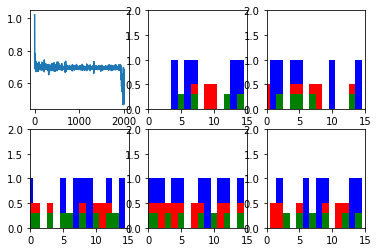

Step 100 Loss 0.1220171
single_output_series: [0 1 0 1 1 1 1 1 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 1 1 0 0 1 1 0 0]

single_output_series: [0 0 0 1 0 0 1 0 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 0 1 1 1 1 0 1 0]

single_output_series: [1 0 0 1 0 1 0 0 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 0 1 1 0 0 1 1 1]

single_output_series: [0 1 1 0 1 0 0 1 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 1 1 1 1 1 1 0 1]

single_output_series: [1 1 1 1 0 1 1 1 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 1 0 0 1 1 1 1 0]



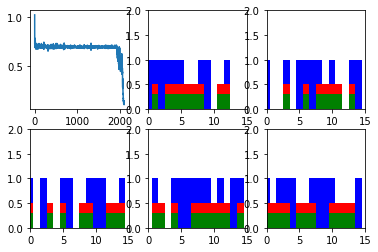

Step 200 Loss 0.038356077
single_output_series: [0 1 1 0 1 1 1 0 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 0 0 1 0 0 1 0 1]

single_output_series: [1 1 1 1 0 1 1 0 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 0 1 1 0 1 1 0 1]

single_output_series: [1 1 0 1 0 0 1 1 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 1 1 0 1 1 1 0 1]

single_output_series: [1 1 1 1 1 0 1 1 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 1 1 1 1 1 1 1 0]

single_output_series: [1 0 1 1 0 0 1 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 0 0 1 0 1 0 0 0]



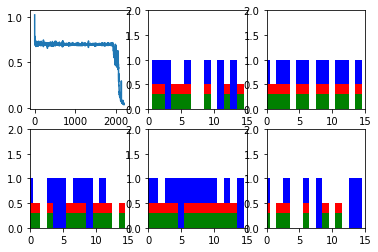

Step 300 Loss 0.020394739
single_output_series: [0 1 1 0 0 0 0 0 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 0 1 0 0 0 1 0 0]

single_output_series: [1 0 1 0 0 0 1 1 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 1 1 0 1 0 0 0 0]

single_output_series: [1 1 0 1 0 0 1 0 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 0 1 1 0 0 1 0 0]

single_output_series: [1 1 0 1 1 0 0 0 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 0 0 0 0 1 1 0 0]

single_output_series: [0 1 0 0 0 0 0 1 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 1 0 1 1 0 1 0 1]



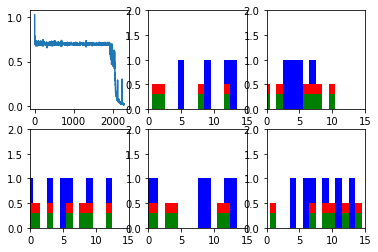

Step 400 Loss 0.01302932
single_output_series: [0 1 0 1 0 0 1 0 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 0 0 0 0 1 0 1 1]

single_output_series: [1 1 0 1 0 0 1 0 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 0 1 0 1 0 1 1 0]

single_output_series: [1 0 0 0 0 1 0 0 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 0 1 1 0 1 0 0 0]

single_output_series: [0 1 0 0 1 0 0 1 0 1 0 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 0 1 0 0 1 1 1]

single_output_series: [1 1 1 1 0 0 1 0 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 0 0 1 0 0 1 0 1]



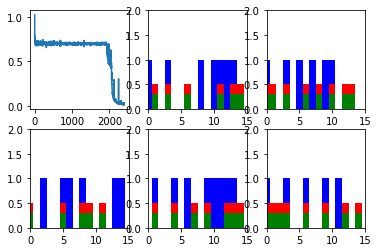

Step 500 Loss 0.011784553
single_output_series: [0 0 0 0 1 1 1 1 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 1 0 1 1 1 0 0]

single_output_series: [0 1 1 0 0 0 0 0 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 0 1 0 1 1 1 1 0]

single_output_series: [1 1 0 0 1 1 0 1 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 1 1 1 0 0 0 0]

single_output_series: [0 1 0 0 0 1 1 1 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 1 1 1 1 1 1 1 0]

single_output_series: [1 0 0 0 1 1 0 0 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 0 1 1 1 0 0 0 0]



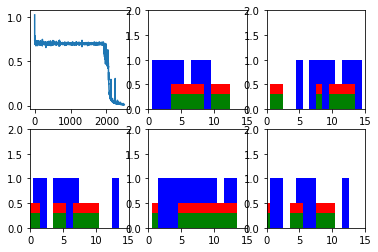

Step 600 Loss 0.011978013
single_output_series: [1 0 1 0 0 1 1 0 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 0 1 0 1 1 1 0 0]

single_output_series: [0 1 1 0 1 1 0 0 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 0 1 1 1 0 1 1 1]

single_output_series: [0 0 1 0 1 1 1 1 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 1 1 1 0 0 0 0 1]

single_output_series: [0 0 0 0 0 1 0 1 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 0 1 0 0 1 0 0]

single_output_series: [1 0 1 0 1 0 0 0 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 0 1 1 1 0 0 1 0]



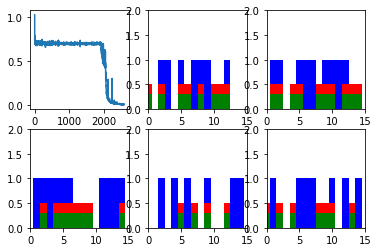

New data, epoch 4
Step 0 Loss 0.18973528
single_output_series: [0 1 0 1 1 1 0 0 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0]

single_output_series: [0 0 1 0 0 0 0 1 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 1 1 1 0 0 0 1 1]

single_output_series: [0 1 0 1 1 1 1 0 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 0 1 0 0 0 1 0 0]

single_output_series: [0 0 1 0 0 0 1 0 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 0 1 0 0 1 1 0 0]

single_output_series: [0 1 0 1 0 0 0 1 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 1 1 0 1 1 1 0 0]



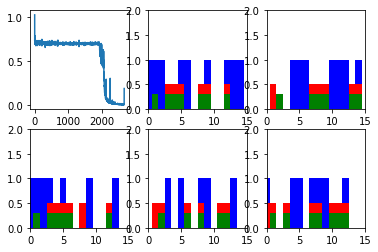

Step 100 Loss 0.006728847
single_output_series: [0 1 1 0 1 1 0 1 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 1 0 1 0 1 1 1 1]

single_output_series: [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1]

single_output_series: [1 1 0 0 0 1 1 1 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 1 0 1 1 1 0 1 0]

single_output_series: [1 0 1 1 0 0 0 1 0 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 1 0 0 0 0 0 1 0]

single_output_series: [1 0 0 1 1 1 1 0 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 0 1 0 0 1 1 0 0]



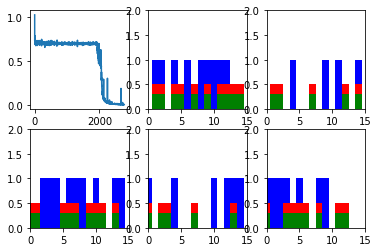

Step 200 Loss 0.0057470757
single_output_series: [0 1 0 0 0 0 0 0 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 0 1 1 0 1 1 0 1]

single_output_series: [1 0 1 1 0 1 0 1 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 1 1 1 0 0 1 0 0]

single_output_series: [1 1 1 0 1 0 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 1 1 1 1 1 1 1 1]

single_output_series: [0 1 1 1 0 0 1 0 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 0 1 1 0 0 1 1 1]

single_output_series: [0 0 1 1 1 1 1 1 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 1 0 0 1 1 0 0 1]



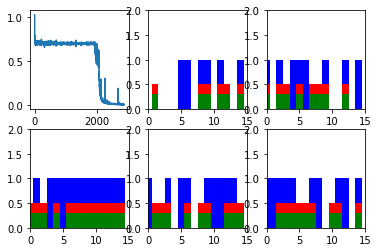

Step 300 Loss 0.0053166463
single_output_series: [0 0 1 1 0 0 1 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 0 0 0 1 1 1 0 0]

single_output_series: [0 1 1 1 1 0 1 1 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 0 0 0 1 0 0 1]

single_output_series: [1 1 1 1 0 0 0 1 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 0 0 0 1 1 0 1]

single_output_series: [0 1 1 0 0 1 1 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 1 0 1 0 1 1 0 0]

single_output_series: [1 0 0 0 0 0 0 1 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 1 1 0 0 0 1 0 0]



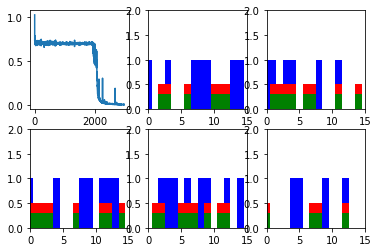

Step 400 Loss 0.0045111254
single_output_series: [1 0 1 1 1 1 0 0 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 0 1 0 1 0 1 1 0]

single_output_series: [0 1 0 1 0 1 0 0 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 0 1 1 1 0 0 1 0]

single_output_series: [0 1 0 1 1 0 0 0 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 0 1 0 0 0 0 0 0]

single_output_series: [0 0 1 0 1 0 0 0 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 0 1 0 1 0 1 1 0]

single_output_series: [0 0 1 0 0 0 1 1 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 1 0 1 0 1 0 0 0]



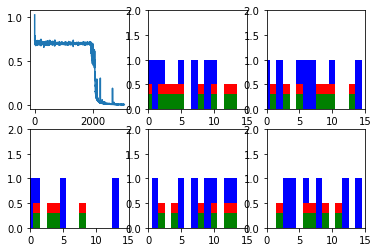

Step 500 Loss 0.0043513197
single_output_series: [1 1 0 0 0 0 0 1 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 1 0 1 1 1 1 0 0]

single_output_series: [0 1 1 0 1 0 1 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 1 0 1 0 1 1 0 0]

single_output_series: [1 0 0 0 0 1 1 1 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 1 1 0 1 1 1 1 0]

single_output_series: [0 1 1 0 1 1 1 1 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 1 1 0 1 0 0 0 1]

single_output_series: [0 1 1 0 1 1 1 0 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 0 1 1 0 0 0 0 1]



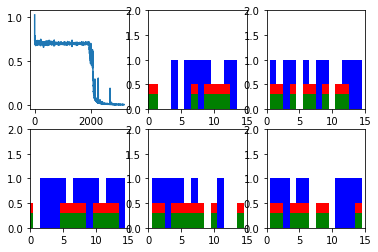

Step 600 Loss 0.0034467706
single_output_series: [1 1 0 1 0 1 1 1 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 1 0 1 1 0 0 0 1]

single_output_series: [0 0 1 0 0 1 1 0 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 0 0 0 1 1 1 0 1]

single_output_series: [0 0 0 1 0 0 1 0 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 0 1 0 0 1 0 0 0]

single_output_series: [0 1 1 0 0 0 0 0 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 0 1 1 0 1 1 1 0]

single_output_series: [1 1 0 1 1 0 0 0 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 0 1 1 0 1 0 0 0]



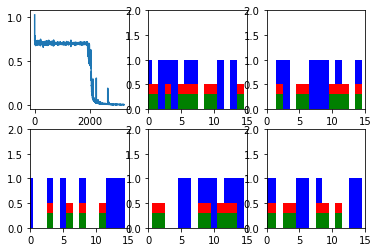

New data, epoch 5
Step 0 Loss 0.2252608
single_output_series: [0 1 0 1 0 1 1 0 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 0 0 1 0 0 1 1 0]

single_output_series: [0 1 0 1 0 0 1 1 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 1 0 1 1 1 1 1 0]

single_output_series: [0 1 0 1 0 0 1 1 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 1 0 0 0 0 1 0 0]

single_output_series: [0 1 0 1 1 1 1 0 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 0 1 1 1 0 0 0 1]

single_output_series: [0 0 1 0 1 0 1 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 1 0 0 1 1 1 0 0]



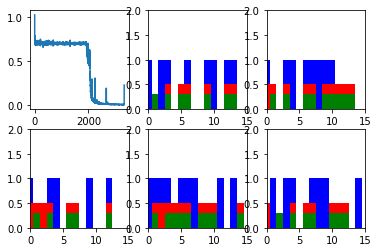

Step 100 Loss 0.0035113024
single_output_series: [1 1 0 0 1 0 1 0 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 0 1 1 0 1 0 0 1]

single_output_series: [0 0 1 0 0 0 0 0 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 0 0 1 1 0 0 1 0]

single_output_series: [1 0 1 1 0 0 1 0 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 0 1 0 0 1 1 1 0]

single_output_series: [1 1 1 1 0 0 0 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 0 0 0 1 1 1 0 0]

single_output_series: [0 0 1 1 1 1 1 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 0 0 0 1 1 1 0 0]



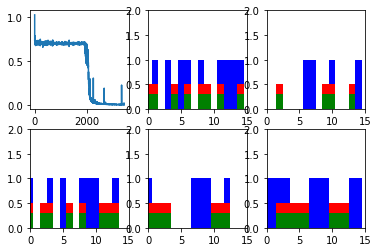

Step 200 Loss 0.0028267533
single_output_series: [1 1 1 0 1 0 1 0 0 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 0 0 1 1 1 0 0 1]

single_output_series: [0 1 0 0 1 0 0 0 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 0 0 0 0 1 1 1 1]

single_output_series: [1 0 1 0 0 1 0 1 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 0 1 0 1 1 0 1]

single_output_series: [0 0 0 0 1 1 0 1 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 1 1 1 1 0 0 1 0]

single_output_series: [1 0 1 0 0 1 1 0 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 0 1 0 0 1 0 1 0]



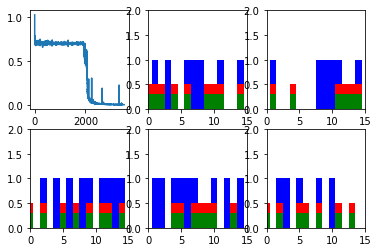

Step 300 Loss 0.0028452426
single_output_series: [0 0 0 0 0 1 1 1 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 1 1 0 1 1 0 0]

single_output_series: [0 1 0 0 0 0 1 1 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 1 0 1 1 1 1 1 1]

single_output_series: [0 0 1 0 1 1 1 1 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 1 0 0 0 0 0 0 0]

single_output_series: [0 1 1 0 0 0 0 1 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 0 0 0 0 0 0 1]

single_output_series: [1 0 1 1 0 1 1 1 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 1 1 1 0 1 1 1 1]



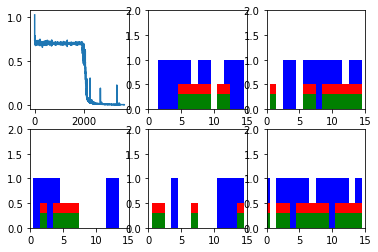

Step 400 Loss 0.002589555
single_output_series: [1 0 0 0 1 1 1 0 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 0 0 1 0 0 1 0 1]

single_output_series: [1 1 1 1 0 1 1 0 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 0 1 1 1 0 0 0 1]

single_output_series: [0 1 1 0 1 1 0 1 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 1 1 0 0 1 1 1 0]

single_output_series: [0 0 1 1 1 0 1 0 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 0 1 0 0 0 1 0 1]

single_output_series: [1 1 0 1 0 0 0 0 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 0 0 0 0 1 0 0 1]



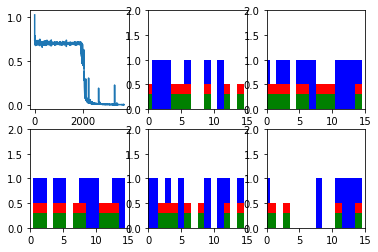

Step 500 Loss 0.0022332293
single_output_series: [0 0 0 1 1 0 0 0 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 0 1 1 0 1 0 1 0]

single_output_series: [1 1 0 0 1 1 1 1 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 1 0 0 0 1 1 0 1]

single_output_series: [1 0 1 1 0 1 0 0 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 0 0 0 0 1 0 0 0]

single_output_series: [1 0 1 1 0 0 1 1 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 1 0 1 1 1 1 0 1]

single_output_series: [1 1 0 1 1 0 1 0 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 0 1 1 0 0 0 1 0]



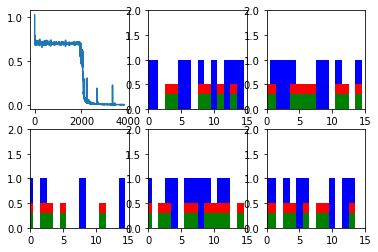

Step 600 Loss 0.002415949
single_output_series: [0 0 0 1 0 0 1 0 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 0 1 1 0 0 1 0 1]

single_output_series: [0 1 0 0 0 0 0 1 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 1 1 1 0 1 1 1 0]

single_output_series: [0 1 1 1 0 1 0 1 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 1 1 1 0 0 0 0 1]

single_output_series: [1 0 1 1 0 1 0 1 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 1 0 0 1 0 1 0 0]

single_output_series: [0 1 1 1 0 0 1 0 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 0 1 1 1 1 0 1 1]



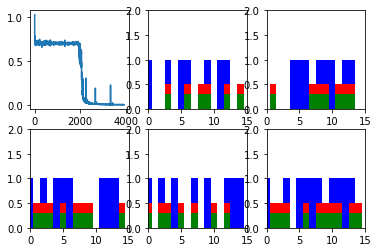

New data, epoch 6
Step 0 Loss 0.30951217
single_output_series: [1 1 0 1 1 1 1 1 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 1 1 0 1 0 1 1]

single_output_series: [1 1 0 1 0 1 1 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 0 1 0 1 0 0 0 0]

single_output_series: [1 1 0 1 0 0 1 1 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 1 1 0 0 0 0 1 0]

single_output_series: [1 1 0 1 0 1 1 0 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 0 0 0 0 0 1 1 0]

single_output_series: [0 0 1 0 1 1 1 1 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 1 0 0 1 1 0 0 1]



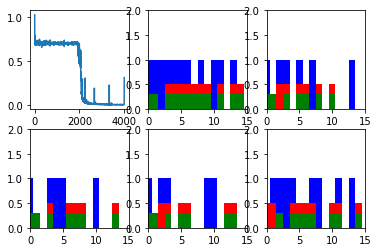

Step 100 Loss 0.0022354566
single_output_series: [1 0 1 1 1 1 0 0 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 0 1 0 1 1 1 0 0]

single_output_series: [0 1 0 0 1 1 1 0 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 0 1 0 1 0 0 1 0]

single_output_series: [1 1 1 0 1 0 0 0 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 0 0 1 1 0 0 0 0]

single_output_series: [0 0 1 0 1 0 0 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 1 0 0 1 1 1 0 0]

single_output_series: [0 0 1 1 0 1 1 1 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 1 1 1 0 0 1 0 1]



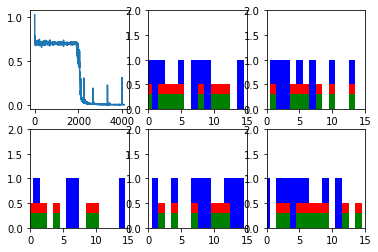

Step 200 Loss 0.0028374745
single_output_series: [0 0 0 0 1 0 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 1 1 1 1 1 1 1 1]

single_output_series: [1 1 1 1 0 0 0 1 0 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 0 1 1 1 0 0 1]

single_output_series: [0 0 1 1 0 1 0 1 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 1 0 0 0 0 0 0 0]

single_output_series: [0 1 1 1 0 1 0 1 1 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 1 1 1 1 0 0 1 1]

single_output_series: [1 1 0 0 0 0 1 0 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 0 1 1 1 0 0 0 0]



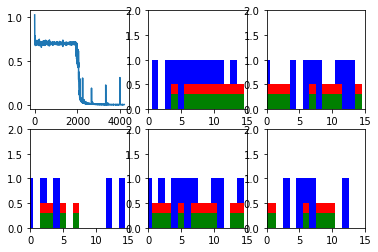

Step 300 Loss 0.0017992039
single_output_series: [1 0 0 1 0 1 0 0 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 0 1 1 0 1 1 1 0]

single_output_series: [0 1 0 1 1 1 1 1 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 1 0 1 1 0 1 0 1]

single_output_series: [1 1 0 1 1 0 1 1 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 0 0 1 0 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]

single_output_series: [1 0 0 1 1 1 0 0 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 1 1 1 1 0 0 0]



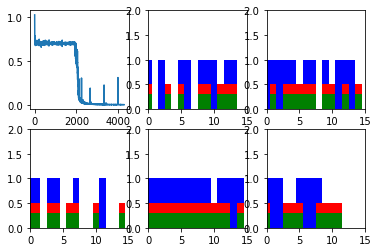

Step 400 Loss 0.0018170762
single_output_series: [1 0 0 0 0 0 0 1 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 1 0 0 1 1 0 0 0]

single_output_series: [0 1 0 1 1 1 0 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 1 0 1 0 1 1 0 0]

single_output_series: [0 0 0 1 0 0 0 1 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 1 0 1 0 1 1 1 0]

single_output_series: [1 1 0 0 0 0 0 1 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 1 0 0 1 1 1 0 1]

single_output_series: [0 0 1 0 0 1 0 1 0 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 1 0 0 0 0 0 1 0]



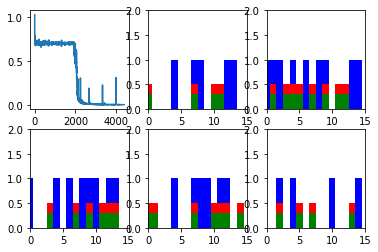

Step 500 Loss 0.0016023839
single_output_series: [0 1 0 1 0 0 1 1 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 1 1 0 0 0 0 1]

single_output_series: [1 0 0 1 1 0 1 0 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 0 1 0 0 0 0 0 0]

single_output_series: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1]

single_output_series: [0 1 1 0 1 1 0 1 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 1 0 0 0 1 0 1 1]

single_output_series: [0 1 1 1 1 1 1 0 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 0 0 1 0 0 1 0 1]



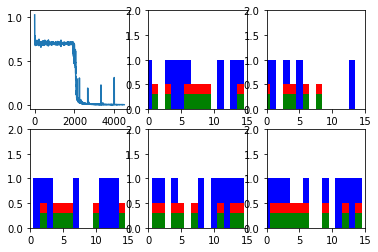

Step 600 Loss 0.0016123984
single_output_series: [1 0 1 0 0 1 1 1 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 1 1 1 1 1 0 0 1]

single_output_series: [0 1 1 1 1 0 1 1 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 1 1 0 1 0 0 0]

single_output_series: [0 1 1 0 1 0 1 1 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 1 0 1 1 0 1 0 1]

single_output_series: [1 0 0 0 1 1 0 0 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 0 1 0 1 0 0 1 1]

single_output_series: [0 1 0 0 0 1 0 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 1 1 1 1 0 0 0 1]



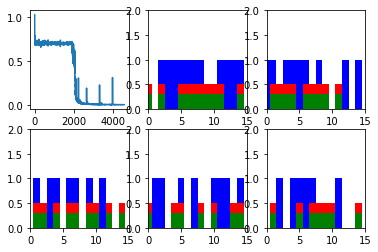

New data, epoch 7
Step 0 Loss 0.19816667
single_output_series: [0 1 0 1 1 1 0 0 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 0 0 0 0 0 1 1 0]

single_output_series: [0 1 0 1 1 0 1 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 0 1 0 1 0 0 0 0]

single_output_series: [0 0 1 0 0 1 0 0 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 0 1 1 1 1 0 1 0]

single_output_series: [0 0 1 0 1 0 0 0 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 0 1 1 0 1 1 0 0]

single_output_series: [0 1 0 1 0 1 1 0 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 0 1 1 0 0 1 0 0]



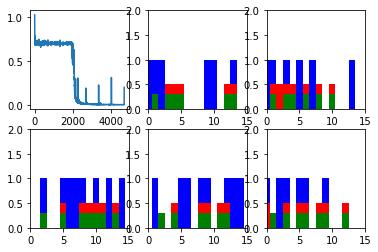

Step 100 Loss 0.0016375885
single_output_series: [0 1 0 1 0 0 1 1 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 1 0 1 0 0 0 0]

single_output_series: [0 1 0 1 0 0 1 1 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 0 1 1 0 1 0 1]

single_output_series: [1 1 1 1 1 1 1 0 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 0 0 0 1 0 0 1 0]

single_output_series: [1 0 1 1 1 0 1 1 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 0 0 0 0 1 1 1]

single_output_series: [1 1 1 1 1 0 1 0 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 0 0 1 0 1 1 1 1]



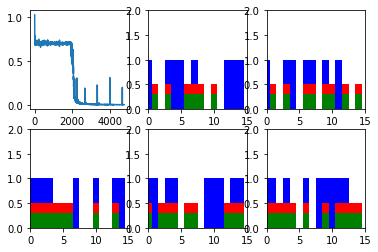

Step 200 Loss 0.0014106211
single_output_series: [1 0 1 1 1 0 0 0 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 0 1 1 0 0 1 0 0]

single_output_series: [0 0 0 1 0 0 0 1 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 1 0 0 1 1 0 0 0]

single_output_series: [1 0 0 0 1 0 0 1 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 1 1 1 0 1 1 0 1]

single_output_series: [0 0 0 1 1 0 1 1 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 0 0 1 1 0 0 1]

single_output_series: [1 0 1 0 1 1 1 0 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 0 1 1 1 1 0 0 0]



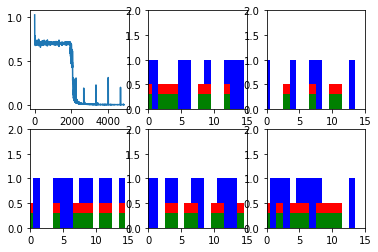

Step 300 Loss 0.0014697678
single_output_series: [0 0 1 0 1 1 0 0 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 0 0 1 0 1 1 1 1]

single_output_series: [1 0 1 1 0 0 0 0 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 0 1 0 1 0 0 1 1]

single_output_series: [0 0 0 1 0 1 1 1 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 1 1 1 1 1 0 0 1]

single_output_series: [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]

single_output_series: [1 0 0 1 0 0 0 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 1 1 1 1 0 0 0 1]



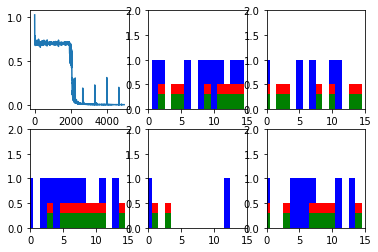

Step 400 Loss 0.0014005108
single_output_series: [0 0 0 1 1 0 1 1 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 0 0 0 0 0 1 1]

single_output_series: [0 0 1 1 1 0 0 0 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 0 1 1 0 0 0 0 1]

single_output_series: [1 0 1 1 0 0 1 0 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 0 1 1 1 0 1 0 0]

single_output_series: [0 0 0 0 0 1 1 0 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 0 1 1 1 0 1 0]

single_output_series: [0 1 1 0 0 0 1 0 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 0 1 0 0 1 0 1 0]



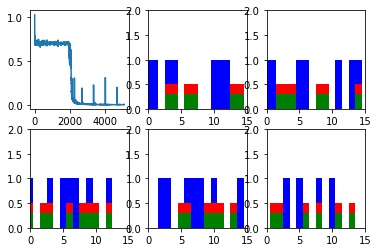

Step 500 Loss 0.0014011606
single_output_series: [0 0 1 1 1 0 0 1 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 1 1 1 0 0 1 0 1]

single_output_series: [0 1 0 0 1 0 1 0 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 0 0 1 1 1 1 1 0]

single_output_series: [0 1 1 1 0 0 0 0 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 0 1 0 0 0 1 0 0]

single_output_series: [0 0 0 0 1 0 0 0 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 0 0 0 0 0 1 1 1]

single_output_series: [0 1 0 0 0 0 1 0 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 0 0 0 1 0 0 0 1]



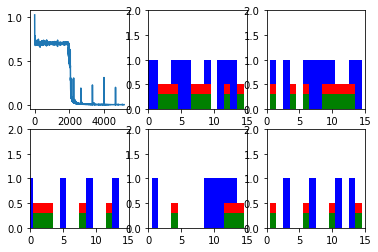

Step 600 Loss 0.001290548
single_output_series: [1 0 1 0 0 0 1 0 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 0 1 0 0 0 1 1 0]

single_output_series: [0 0 1 0 0 1 0 1 0 1 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 1 0 1 0 0 1 1 1]

single_output_series: [1 0 1 1 1 0 0 1 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 1 1 1 1 1 1 0 0]

single_output_series: [0 0 0 0 0 0 1 0 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 0 0 1 1 1 1 0]

single_output_series: [0 1 1 0 0 0 1 0 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 0 0 0 1 0 1 0 0]



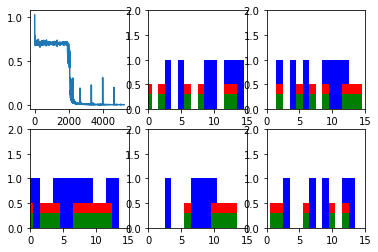

New data, epoch 8
Step 0 Loss 0.15556389
single_output_series: [0 1 0 1 0 1 1 1 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 1 1 0 1 1 1 0 0]

single_output_series: [0 1 0 1 1 1 1 1 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 1 1 1 0 0 0 1 0]

single_output_series: [0 1 0 1 1 1 0 1 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 1 1 0 1 1 0 1 0]

single_output_series: [0 1 0 1 0 1 0 1 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 0 1 1 0 1 0 0]

single_output_series: [0 1 0 1 1 1 1 0 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 0 1 0 1 1 1 0 0]



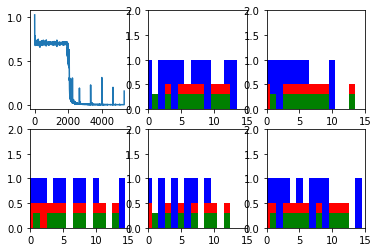

Step 100 Loss 0.0013173786
single_output_series: [1 1 1 0 0 0 0 1 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 1 0 0 1 0 1 1]

single_output_series: [1 1 1 0 0 1 0 1 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 1 0 1 0 0 0 0 1]

single_output_series: [1 0 0 1 0 0 1 0 1 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 0 1 0 0 1 0 0 1]

single_output_series: [1 1 1 0 0 1 1 1 0 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 1 0 1 1 1 0 0 1]

single_output_series: [0 0 1 0 1 0 1 0 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 1 1 1 0 1 0 1]



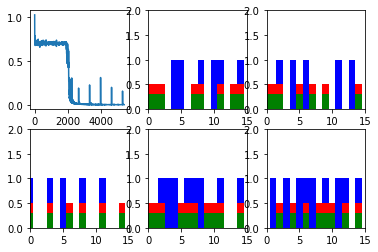

Step 200 Loss 0.0013068196
single_output_series: [0 0 0 0 0 1 1 0 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 1 0 1 0 0 0 1]

single_output_series: [0 0 0 1 0 0 0 0 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 0 0 1 1 0 0 0 1]

single_output_series: [1 1 0 1 1 1 0 0 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 0 1 0 1 1 1 1 0]

single_output_series: [0 1 0 0 0 1 1 1 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 1 1 0 0 0 0 1 1]

single_output_series: [1 0 0 0 1 1 0 1 0 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 1 0 1 0 1 0 0 1]



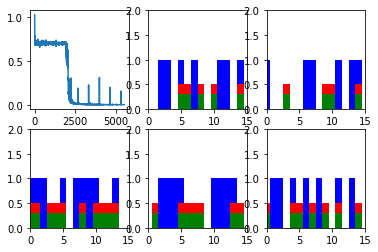

Step 300 Loss 0.0012254624
single_output_series: [1 1 1 1 0 0 1 0 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 0 1 1 1 0 1 1 1]

single_output_series: [0 1 1 0 0 0 0 0 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 0 1 0 1 1 0 1 1]

single_output_series: [1 0 0 1 1 1 0 0 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 1 0 0 0 1 1 0]

single_output_series: [0 1 1 0 1 0 1 0 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 0 1 0 0 0 1 0 0]

single_output_series: [1 1 0 0 0 0 1 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 0 1 0 1 0 1 1 1]



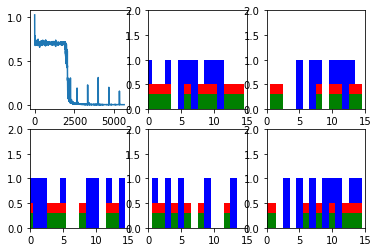

Step 400 Loss 0.0010859588
single_output_series: [1 0 0 0 1 1 0 1 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 1 1 1 0 1 1 0 0]

single_output_series: [0 1 1 1 0 1 0 1 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 1 0 0 1 0 0 0 1]

single_output_series: [1 0 0 0 1 1 0 0 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 0 0 0 0 1 1 1 1]

single_output_series: [1 0 1 0 0 1 0 1 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 1 0 1 1 1 1 1]

single_output_series: [0 0 0 0 0 0 0 1 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 1 0 0 0 1 1 0 0]



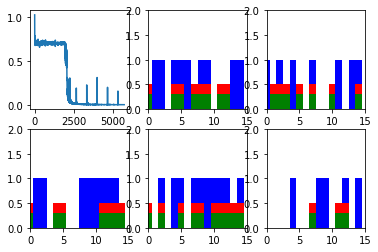

Step 500 Loss 0.0011304123
single_output_series: [0 0 0 0 1 0 0 0 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 0 1 1 1 0 1 0 0]

single_output_series: [1 0 0 0 0 1 0 0 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 0 1 1 0 1 0 0 0]

single_output_series: [1 1 1 1 0 0 0 1 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 0 0 1 0 1 0 1]

single_output_series: [0 0 0 0 0 0 1 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 1 0 1 0 1 1 1]

single_output_series: [0 0 1 1 1 0 1 1 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 1 0 0 0 0 1 1 1]



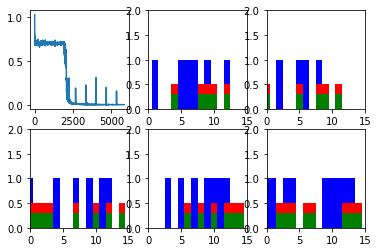

Step 600 Loss 0.0011427149
single_output_series: [0 1 1 1 1 0 1 0 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 0 0 1 0 0 0 1 0]

single_output_series: [1 1 0 0 0 0 1 1 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 1 1 0 1 0 1 0 1]

single_output_series: [1 1 0 1 0 0 0 1 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 1 1 0 1 0 0 1 1]

single_output_series: [0 1 0 1 0 0 1 1 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 1 0 0 0 1 0 0]

single_output_series: [0 1 1 1 0 1 0 0 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 0 0 0 1 0 1 1 1]



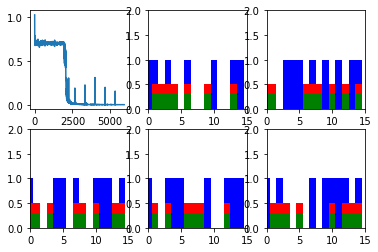

New data, epoch 9
Step 0 Loss 0.2371918
single_output_series: [1 0 0 1 0 0 0 1 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 1 0 0 0 1 0 1 0]

single_output_series: [1 0 0 1 0 0 0 1 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 1 1 1 0 1 1 1 1]

single_output_series: [0 0 1 0 1 0 1 0 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 0 1 0 1 0 0 1 0]

single_output_series: [0 0 1 0 0 1 1 0 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 0 0 0 1 0 1 1 1]

single_output_series: [0 0 1 0 0 0 0 1 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 1 0 0 0 1 1 1 1]



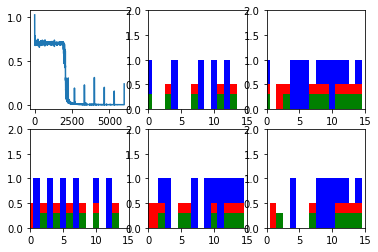

Step 100 Loss 0.0009282445
single_output_series: [0 0 0 0 1 1 1 0 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 0 1 1 0 1 1 0 0]

single_output_series: [1 0 1 1 1 0 1 1 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 1 0 1 0 1 1 1]

single_output_series: [0 0 1 1 0 0 0 1 0 0 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 1 0 0 1 0 1 1 0]

single_output_series: [0 0 1 1 1 0 0 0 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 0 0 0 0 0 0 1 1]

single_output_series: [1 1 0 0 0 0 0 0 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 0 0 1 1 1 0 1 0]



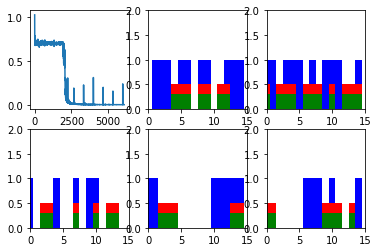

Step 200 Loss 0.0007672744
single_output_series: [1 1 0 0 1 1 0 1 1 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 1 0 0 1 0 0 1]

single_output_series: [0 0 1 0 0 1 1 1 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 1 1 1 1 1 1 1 0]

single_output_series: [0 0 1 0 1 0 0 1 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 1 0 1 0 1 1 0 1]

single_output_series: [0 0 0 1 0 1 1 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 1 1 1 1 0 0 0 1]

single_output_series: [0 1 0 0 1 0 0 1 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 0 1 1 0 1 0 0]



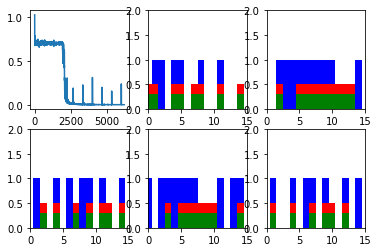

Step 300 Loss 0.0009086717
single_output_series: [1 1 1 1 1 0 1 0 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 0 0 1 0 1 1 0 1]

single_output_series: [1 1 0 1 1 1 0 1 1 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 1 1 0 0 1 0 0 1]

single_output_series: [0 0 0 1 1 0 0 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 0 1 0 1 0 1 1 1]

single_output_series: [0 0 0 1 1 1 1 1 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 1 1 1 0 1 0 1]

single_output_series: [1 1 0 1 0 0 0 1 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 1 0 0 1 1 0 1 0]



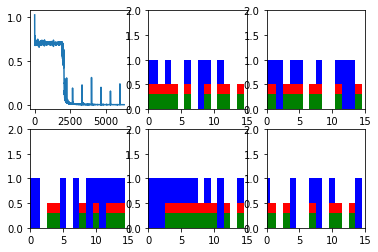

Step 400 Loss 0.0010301864
single_output_series: [0 0 0 0 1 1 1 1 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 0 0 1 1 1 1 1]

single_output_series: [0 0 1 0 1 0 1 0 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 1 1 0 1 1 1 1]

single_output_series: [1 1 1 0 0 1 0 1 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 1 0 0 0 0 0 1 1]

single_output_series: [1 1 0 0 0 1 1 0 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 0 0 0 0 1 1 0 1]

single_output_series: [1 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 0 0 0 0 1 0 1 0]



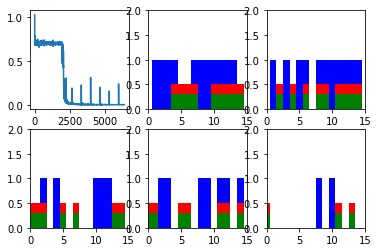

Step 500 Loss 0.00092566194
single_output_series: [0 0 1 1 1 1 1 1 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 1 1 0 0 1 1 1 0]

single_output_series: [1 1 1 1 1 1 1 0 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 0 0 0 1 0 0 0 1]

single_output_series: [1 0 0 0 0 1 0 0 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 0 1 0 0 1 1 1 0]

single_output_series: [1 1 0 0 1 0 1 1 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 1 1 1 1 1 1 0]

single_output_series: [1 1 0 1 1 1 1 1 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 1 1 1 1 1 0 1 1]



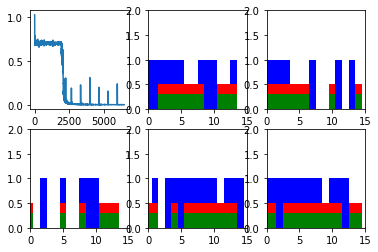

Step 600 Loss 0.00091934553
single_output_series: [0 0 1 1 0 1 1 0 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 0 0 0 0 0 0 1 1]

single_output_series: [0 1 1 1 1 0 1 1 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 1 1 0 1 1 1 1]

single_output_series: [1 0 0 0 0 0 1 1 1 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 1 1 1 1 0 0 1 1]

single_output_series: [1 0 1 1 0 0 1 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 1 0 0 0 1 1 1 0]

single_output_series: [0 0 0 0 1 0 0 0 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 0 1 1 1 1 1 0 1]



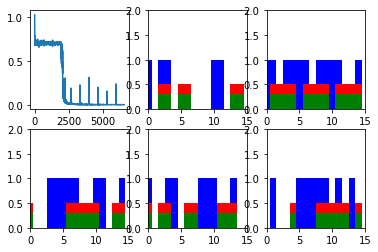

New data, epoch 10
Step 0 Loss 0.19578695
single_output_series: [0 0 1 0 1 1 1 0 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 0 0 0 0 0 0 1 1]

single_output_series: [1 1 0 1 1 0 0 0 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 0 1 1 1 1 1 0 0]

single_output_series: [0 0 1 0 1 1 0 1 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 1 1 0 0 0 1 1 0]

single_output_series: [1 1 0 1 0 0 1 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 1 0 1 0 1 1 0 0]

single_output_series: [1 1 0 1 0 0 0 0 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 0 1 0 0 0 1 1 1]



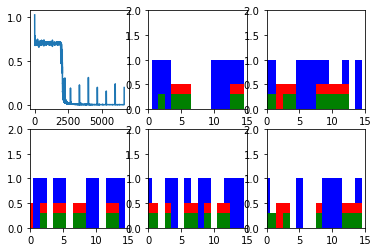

Step 100 Loss 0.0010802425
single_output_series: [0 0 1 0 1 0 1 0 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 1 0 0 0 1 1 1]

single_output_series: [0 1 1 0 1 0 1 1 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 1 0 0 0 0 0 0 0]

single_output_series: [0 1 1 1 0 1 1 1 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 1 0 1 1 1 1 1 1]

single_output_series: [0 1 0 0 0 0 1 1 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 1 1 1 0 0 0 1 0]

single_output_series: [1 0 0 1 1 0 1 0 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 0 0 1 1 0 0 0 0]



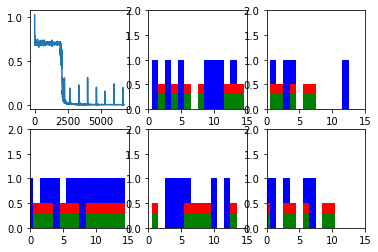

Step 200 Loss 0.00088215945
single_output_series: [0 1 1 0 1 1 0 0 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 0 1 0 0 0 0 0 0]

single_output_series: [1 1 1 1 0 1 1 1 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 1 1 0 0 1 1 1 1]

single_output_series: [0 0 0 0 1 1 1 1 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 1 1 1 0 0 1 0]

single_output_series: [1 0 1 1 1 1 1 1 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 1 1 0 1 0 0 0 0]

single_output_series: [0 1 1 1 1 1 1 1 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 1 0 1 0 1 0 0 0]



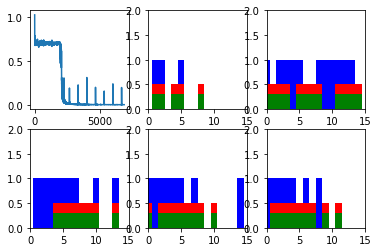

Step 300 Loss 0.0008558081
single_output_series: [1 0 0 1 0 1 0 0 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 0 0 1 1 1 0 1 1]

single_output_series: [0 0 1 1 1 0 0 0 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 0 1 1 0 0 1 1 0]

single_output_series: [1 1 1 1 0 1 0 1 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 1 1 0 1 1 0 1 1]

single_output_series: [1 0 1 0 0 1 1 1 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 1 1 0 0 1 1 1 0]

single_output_series: [0 0 1 0 1 0 1 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 0 0 0 0 0 0 0]



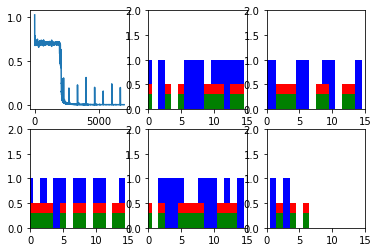

Step 400 Loss 0.0007805338
single_output_series: [0 1 0 1 1 0 0 1 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 1 1 0 0 0 1 0 0]

single_output_series: [0 0 0 0 1 1 0 1 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 1 1 0 0 1 0 1 0]

single_output_series: [0 0 0 0 1 1 1 1 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 0 0 0 0 1 0 1]

single_output_series: [1 0 1 0 0 0 1 0 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 0 0 1 1 0 0 0 1]

single_output_series: [0 0 1 0 0 0 1 1 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 1 0 0 0 1 1 0 1]



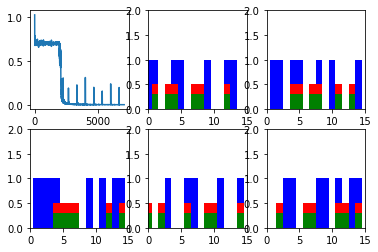

Step 500 Loss 0.00083970645
single_output_series: [0 1 1 1 0 0 0 0 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 0 1 0 0 0 1 1 0]

single_output_series: [1 1 0 1 1 0 1 1 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 1 1 0 0 0 1 0]

single_output_series: [1 1 0 0 1 0 1 1 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 0 0 0 1 0 0 0]

single_output_series: [0 0 0 1 1 1 0 0 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 0 0 0 1 0 0 1 0]

single_output_series: [1 0 1 1 1 1 0 1 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 1 1 1 1 0 0 0 0]



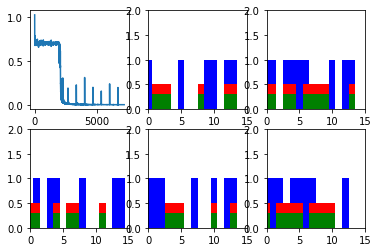

Step 600 Loss 0.0008346057
single_output_series: [1 0 1 1 0 0 1 1 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 1 1 1 0 0 1 0 0]

single_output_series: [0 1 1 1 0 1 1 1 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 1 0 1 0 1 1 1 0]

single_output_series: [0 0 0 0 0 1 1 0 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 1 0 0 0 1 1 0]

single_output_series: [1 1 1 0 0 0 1 1 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 1 1 0 0 0 1 0 1]

single_output_series: [0 1 1 0 0 0 0 0 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 0 0 0 1 1 1 0 1]



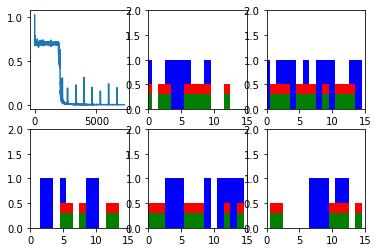

New data, epoch 11
Step 0 Loss 0.23795629
single_output_series: [0 0 1 0 1 1 0 1 0 0 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 1 0 0 1 0 1 1 0]

single_output_series: [0 0 1 0 1 1 1 1 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 0 1 1 0 0 1 1]

single_output_series: [1 1 1 1 1 0 0 1 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 1 1 0 1 1 0 0 0]

single_output_series: [1 0 0 1 0 0 0 1 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 1 0 1 0 1 1 1 0]

single_output_series: [0 0 1 0 1 0 0 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 1 0 0 0 1 1 1 0]



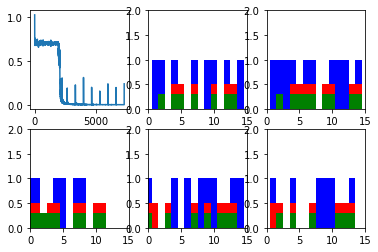

Step 100 Loss 0.0044718413
single_output_series: [1 0 0 0 0 0 0 1 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 1 1 1 1 1 0 1 0]

single_output_series: [1 1 1 0 1 1 0 0 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 0 0 1 0 1 0 1 1]

single_output_series: [1 0 1 0 1 1 0 0 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 0 1 1 0 1 1 0 0]

single_output_series: [1 1 1 0 1 1 0 0 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 0 0 0 0 0 0 1 1]

single_output_series: [1 1 0 0 0 0 0 1 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 1 0 0 0 1 0 0 1]



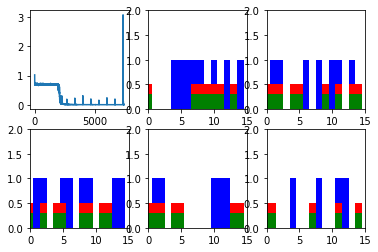

Step 200 Loss 0.0030783506
single_output_series: [0 0 0 0 1 0 1 1 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 1 0 0 1 1 0 1 1]

single_output_series: [0 1 0 0 0 1 0 1 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 1 0 1 0 0 1 0 0]

single_output_series: [1 0 0 0 0 1 0 1 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 1 0 1 0 0 1 0 0]

single_output_series: [1 1 1 1 0 0 0 0 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 0 1 1 0 1 0 0 1]

single_output_series: [0 1 1 0 0 0 1 1 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 1 1 0 0 0 1 1 0]



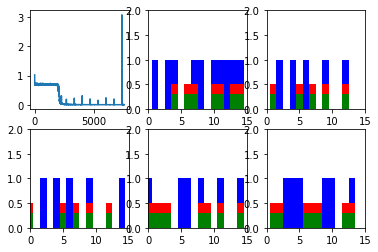

Step 300 Loss 0.0027791802
single_output_series: [0 0 0 1 0 0 1 0 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 0 1 1 1 0 0 0 0]

single_output_series: [1 1 1 1 1 1 0 1 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 1 1 1 0 1 1 1 1]

single_output_series: [1 1 0 1 0 1 1 1 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 1 0 1 1 0 1 1 0]

single_output_series: [1 0 0 1 0 1 0 1 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 1 1 0 1 1 0 0]

single_output_series: [0 1 0 0 0 0 1 0 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 0 0 1 1 1 0 1 0]



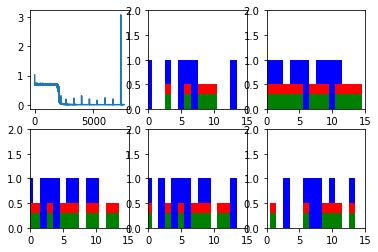

Step 400 Loss 0.0027527614
single_output_series: [1 1 0 1 0 1 0 0 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 0 1 0 1 0 0 0 1]

single_output_series: [1 0 0 1 0 1 1 0 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 0 1 1 0 0 1 0 1]

single_output_series: [0 0 0 0 0 0 1 1 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 1 1 0 1 0 0 0]

single_output_series: [0 0 1 0 0 1 0 0 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 0 1 0 0 1 1 1 1]

single_output_series: [1 0 0 1 0 1 0 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 1 1 1 0 0 0 1]



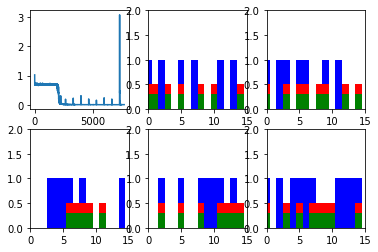

Step 500 Loss 0.0021482476
single_output_series: [1 1 1 1 0 1 0 0 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 0 1 0 0 0 1 0]

single_output_series: [0 0 0 1 0 1 1 1 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 1 1 0 0 0 1 0 0]

single_output_series: [1 1 1 1 0 0 0 1 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 1 0 0 0 0 1 0]

single_output_series: [1 1 0 0 1 1 1 0 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 0 0 1 0 0 1 0 1]

single_output_series: [1 0 1 1 1 1 0 0 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 0 0 1 1 0 1 1 1]



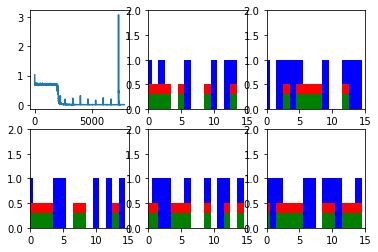

Step 600 Loss 0.0019708916
single_output_series: [1 1 1 1 0 1 1 0 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 0 0 1 1 1 1 0 0]

single_output_series: [0 0 1 1 0 1 0 1 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 1 0 0 0 0 1 0 0]

single_output_series: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 0 0 1 0 1 0 0 0]

single_output_series: [1 0 1 0 0 0 0 0 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 0 0 1 0 1 1 0 0]

single_output_series: [0 1 0 0 1 1 1 1 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 1 1 1 0 0 0 1 1]



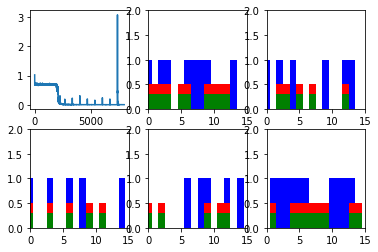

New data, epoch 12
Step 0 Loss 0.24378459
single_output_series: [1 0 1 0 1 1 0 0 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 0 1 1 1 1 0 1 0]

single_output_series: [0 0 0 1 0 1 0 1 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 1 1 0 1 0 1 1 1]

single_output_series: [0 0 0 1 0 0 1 1 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 1 0 0 1 1 0 0 0]

single_output_series: [0 0 0 1 1 1 0 0 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 0 1 1 0 0 1 1]

single_output_series: [1 0 1 0 1 0 1 1 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 1 1 0 1 0 0 0 1]



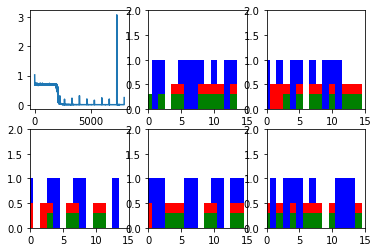

Step 100 Loss 0.0015024474
single_output_series: [1 0 1 0 0 1 1 0 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 0 1 1 0 0 0 1 0]

single_output_series: [0 0 0 0 1 0 0 1 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 1 0 1 1 0 0 0 0]

single_output_series: [1 1 0 1 0 1 1 1 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 1 1 0 1 1 0 0 0]

single_output_series: [1 1 1 1 1 1 0 0 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 0 0 0 1 1 0 0 0]

single_output_series: [0 1 0 0 1 1 0 1 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 1 0 1 1 1 0 1 0]



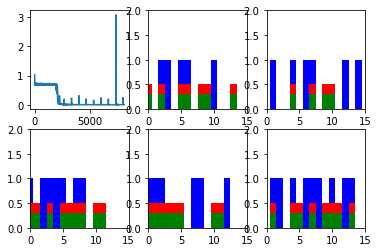

Step 200 Loss 0.0011541282
single_output_series: [0 0 1 1 0 0 1 0 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 0 0 0 1 0 1 1 1]

single_output_series: [1 1 0 1 0 1 1 1 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 1 1 1 0 0 1 1 0]

single_output_series: [0 1 0 0 0 0 1 0 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 0 0 1 0 0 0 0 0]

single_output_series: [0 1 0 0 0 0 1 0 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 0 0 1 1 0 0 0 1]

single_output_series: [1 1 1 0 1 1 0 1 0 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 1 0 0 1 0 1 1 0]



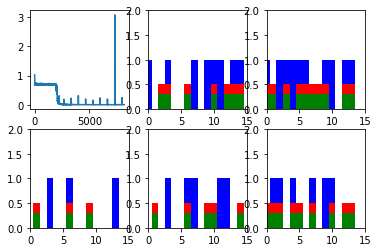

Step 300 Loss 0.0015189914
single_output_series: [0 0 0 1 1 1 1 0 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 0 0 0 0 1 1 1 1]

single_output_series: [0 1 0 1 0 0 0 1 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 1 0 0 0 1 1 0 0]

single_output_series: [0 0 0 0 0 1 0 1 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 0 1 0 0 1 1 0]

single_output_series: [1 1 1 0 0 1 0 0 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 0 0 1 1 0 1 0 0]

single_output_series: [0 1 0 0 1 1 0 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 0 0 0 0 1 1 1 0]



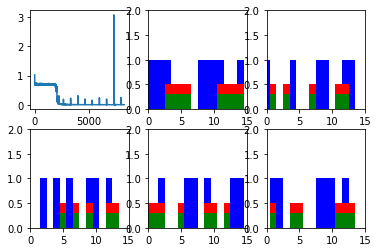

Step 400 Loss 0.0012102934
single_output_series: [0 1 1 0 0 0 0 0 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 0 0 1 1 0 1 1 0]

single_output_series: [1 1 0 1 1 1 1 0 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 0 0 1 0 1 1 1 0]

single_output_series: [1 1 1 1 0 0 1 1 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 1 0 0 1 0 0 0 1]

single_output_series: [1 0 1 1 0 0 0 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 0 0 0 1 1 1 0 0]

single_output_series: [1 0 1 1 0 0 1 0 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 0 1 0 1 0 0 0 1]



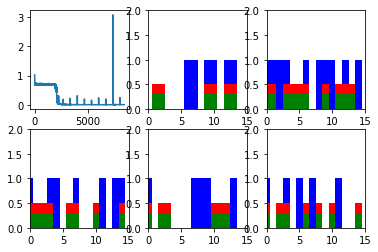

Step 500 Loss 0.0013060643
single_output_series: [1 1 0 0 1 0 1 0 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 0 1 1 1 1 1 0 0]

single_output_series: [0 0 0 0 0 1 1 0 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 0 1 1 1 1 1 1]

single_output_series: [1 0 1 1 1 0 0 1 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 1 1 0 1 0 1 1 0]

single_output_series: [0 1 0 0 1 0 0 0 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 0 1 0 1 1 1 1 1]

single_output_series: [0 1 0 0 1 0 1 1 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 1 0 0 0 0 1 1 0]



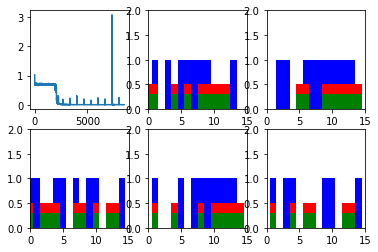

Step 600 Loss 0.0011161893
single_output_series: [1 0 0 1 0 0 0 0 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 0 0 0 1 0 1 0 0]

single_output_series: [0 1 0 0 1 1 1 1 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 1 0 1 0 0 1 0 0]

single_output_series: [1 0 1 1 1 0 1 0 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 0 1 1 0 1 0 0 1]

single_output_series: [1 0 0 1 0 1 0 0 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 0 1 1 1 1 0 1 0]

single_output_series: [1 0 1 0 1 1 0 0 0 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 0 0 0 0 0 0 1 0]



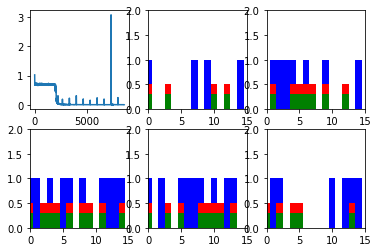

New data, epoch 13
Step 0 Loss 0.18304342
single_output_series: [1 0 1 0 0 0 0 1 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 1 1 0 1 0 0 0 1]

single_output_series: [0 0 0 1 1 0 0 1 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 1 0 0 1 1 0 0 0]

single_output_series: [1 0 1 0 0 0 1 1 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 1 0 1 0 0 0 1]

single_output_series: [1 0 1 0 1 0 0 0 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 0 1 1 0 0 1 1 0]

single_output_series: [1 0 1 0 1 1 1 0 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 1 1 0 1 1 0 1]



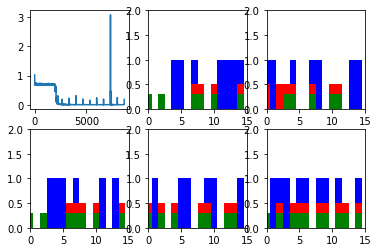

Step 100 Loss 0.0011497414
single_output_series: [1 0 1 0 1 1 0 0 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 0 1 1 1 1 1 1 0]

single_output_series: [1 1 0 0 1 1 0 0 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 0 1 0 1 1 0 1 0]

single_output_series: [1 1 1 1 1 0 1 1 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 1 1 0 1 1 1 1 0]

single_output_series: [1 1 0 0 0 1 0 0 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 0 0 0 1 1 1 1 0]

single_output_series: [0 1 1 0 1 0 0 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 0 0 1 0 1 0 0 0]



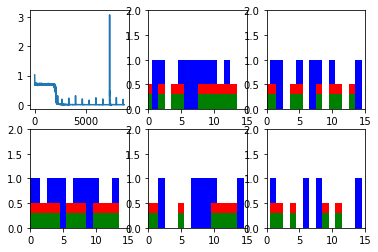

Step 200 Loss 0.0011019721
single_output_series: [0 1 1 1 0 1 0 0 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 0 1 1 0 0 1 1 1]

single_output_series: [1 0 0 0 0 1 0 1 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 1 1 0 0 0 0 0 0]

single_output_series: [0 0 1 0 1 0 1 0 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 1 0 0 0 1 1 0]

single_output_series: [1 1 1 0 1 0 0 1 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 1 1 1 0 0 0 1 1]

single_output_series: [1 0 1 1 0 0 1 0 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 0 1 0 1 0 0 1 1]



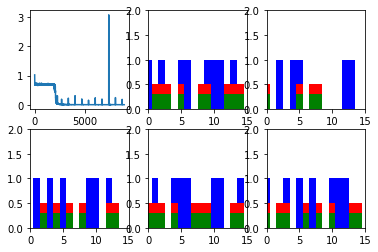

Step 300 Loss 0.0009156714
single_output_series: [1 0 1 0 0 0 1 0 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 0 1 1 1 0 1 0 0]

single_output_series: [1 0 0 0 1 1 0 0 0 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 0 0 1 0 1 0 0 1]

single_output_series: [0 1 1 0 1 0 0 1 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 1 1 0 0 1 1 1 1]

single_output_series: [0 1 0 1 1 1 0 1 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 1 0 0 0 0 0 1 1]

single_output_series: [1 1 0 1 0 0 0 1 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 1 1 1 1 1 0 0 1]



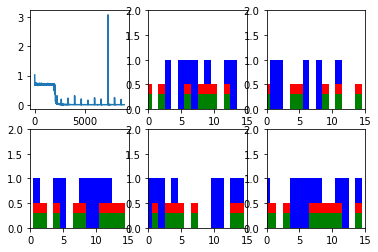

Step 400 Loss 0.0010098738
single_output_series: [0 0 0 1 0 0 0 1 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 1 0 0 1 0 1 0 1]

single_output_series: [0 1 0 1 0 1 1 1 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 1 1 1 1 0 1 0]

single_output_series: [0 0 1 0 1 1 1 0 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 1 1 1 0 1 1 0]

single_output_series: [0 0 0 1 1 1 1 1 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 1 0 1 0 0 1 0]

single_output_series: [1 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 0 0 0 1 1 1 0 0]



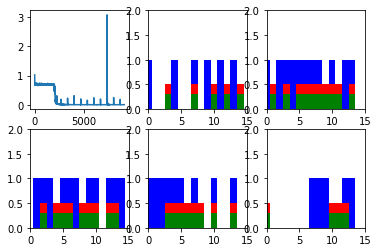

Step 500 Loss 0.0010974762
single_output_series: [1 1 1 1 0 1 1 1 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 1 1 1 1 1 1 1 0]

single_output_series: [1 0 0 1 1 0 0 0 1 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 0 1 0 0 0 0 0 1]

single_output_series: [1 0 0 0 1 1 1 1 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 1 0 1 1 0 1 1 0]

single_output_series: [1 1 0 0 0 1 1 0 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 0 1 1 1 1 1 0 1]

single_output_series: [1 0 1 0 1 0 0 0 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 0 1 1 1 1 0 0 0]



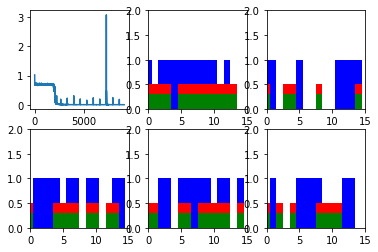

Step 600 Loss 0.00087828777
single_output_series: [1 1 0 0 1 0 1 1 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 0 0 1 1 0 1 1]

single_output_series: [1 0 1 0 1 0 0 0 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 0 1 0 1 0 0 0 1]

single_output_series: [0 0 0 1 1 0 0 0 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 0 1 0 1 1 1 1 1]

single_output_series: [0 0 1 0 1 0 1 1 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 1 0 0 0 1 1 0 1]

single_output_series: [1 1 1 1 0 1 0 0 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 0 1 0 1 0 1 1]



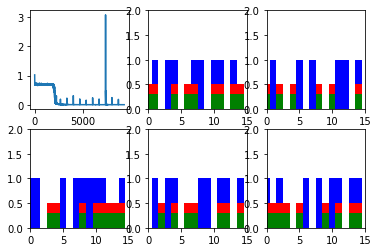

New data, epoch 14
Step 0 Loss 0.09247008
single_output_series: [0 0 0 1 0 0 0 0 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 0 1 0 1 1 1 0 0]

single_output_series: [0 0 0 1 1 0 0 0 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 0 1 0 1 0 1 0 0]

single_output_series: [1 0 0 0 0 1 0 1 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 1 1 0 0 0 1 0 1]

single_output_series: [0 0 0 1 0 1 1 0 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 0 0 1 0 1 1 0 1]

single_output_series: [0 0 0 1 0 0 0 0 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 0 1 0 0 1 1 0 1]



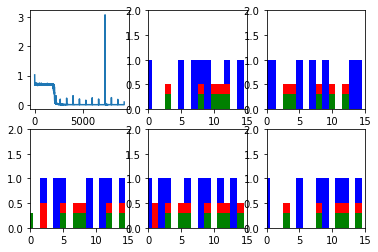

Step 100 Loss 0.0011016728
single_output_series: [0 0 1 1 1 1 1 0 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 0 1 0 0 1 0 1 1]

single_output_series: [1 0 1 0 0 0 0 0 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 0 1 0 1 0 0 0 1]

single_output_series: [1 1 1 0 1 0 0 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 0 1 0 1 0 0 0 0]

single_output_series: [1 1 1 1 1 0 1 1 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 1 1 1 0 0 0 1 0]

single_output_series: [0 0 1 1 0 1 0 1 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 1 0 0 1 0 1 0 0]



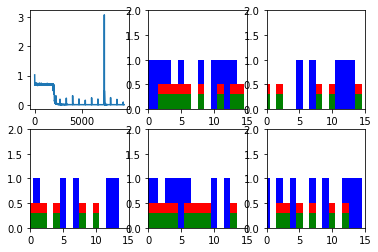

Step 200 Loss 0.0008675806
single_output_series: [1 1 0 1 1 1 0 0 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 0 0 0 1 1 1 1 1]

single_output_series: [0 1 0 1 0 1 0 0 0 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 0 0 0 0 0 0 1 0]

single_output_series: [0 0 1 1 0 1 0 0 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 0 0 1 1 1 1 0 1]

single_output_series: [1 0 0 1 1 1 0 1 0 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 1 0 0 1 0 1 1 0]

single_output_series: [0 1 0 0 0 1 0 1 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 1 0 0 1 1 1 0 1]



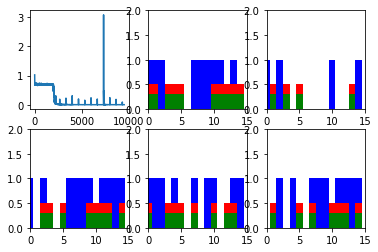

Step 300 Loss 0.00072734785
single_output_series: [1 0 0 1 0 1 1 0 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 0 1 1 0 1 0 1 1]

single_output_series: [0 1 0 1 1 0 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 0 0 0 0 0 0 0 0]

single_output_series: [0 0 1 0 1 1 0 1 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 1 1 0 1 0 1 1 1]

single_output_series: [0 0 1 0 1 0 1 1 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 1 1 0 0 1 0 0 0]

single_output_series: [0 1 0 1 0 0 0 0 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 0 1 0 0 1 0 0 0]



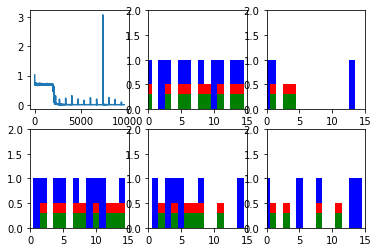

Step 400 Loss 0.0008421948
single_output_series: [1 1 1 1 1 0 1 0 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 0 0 0 1 0 1 1 1]

single_output_series: [1 1 1 1 0 0 0 1 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 0 1 1 1 0 0 0]

single_output_series: [1 0 1 0 1 1 1 1 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 1 1 0 0 1 1 0 0]

single_output_series: [1 0 1 0 1 1 1 0 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 0 1 0 1 1 0 1 0]

single_output_series: [1 1 0 0 0 0 1 1 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 1 0 1 0 1 1 0 1]



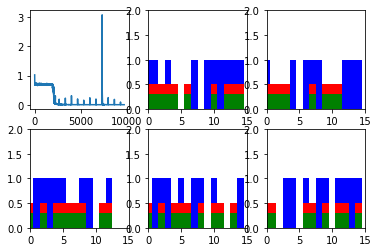

Step 500 Loss 0.0008175618
single_output_series: [1 0 1 1 1 0 1 1 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 1 0 0 1 0 1 1]

single_output_series: [1 1 0 1 0 1 1 0 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 0 0 0 0 1 1 1 1]

single_output_series: [1 0 0 1 1 1 0 1 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 1 0 1 1 1 0 1 0]

single_output_series: [0 0 0 1 0 1 1 0 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 0 0 0 1 1 1 1 1]

single_output_series: [1 1 1 1 1 1 1 0 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 0 1 1 1 0 1 1 1]



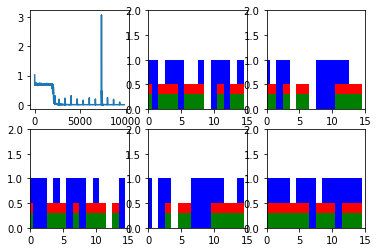

Step 600 Loss 0.0007073408
single_output_series: [0 0 0 1 0 1 0 0 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 1 1 0 1 0 0 0]

single_output_series: [1 0 0 0 0 1 1 1 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 1 0 1 1 0 1 0 0]

single_output_series: [1 0 0 1 1 0 0 0 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 0 0 1 1 0 1 0 1]

single_output_series: [1 1 1 0 1 1 1 0 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 0 1 0 1 1 0 0 0]

single_output_series: [0 1 0 0 0 0 0 0 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 0 0 1 0 1 1 0 0]



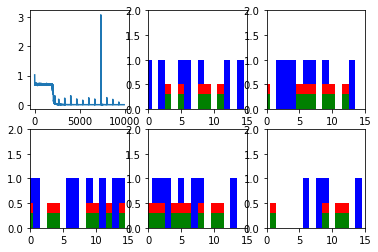

New data, epoch 15
Step 0 Loss 0.31483632
single_output_series: [1 0 1 0 1 0 0 0 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 0 0 1 1 0 1 0 1]

single_output_series: [0 0 0 1 1 0 1 0 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 0 0 1 0 0 1 1 0]

single_output_series: [1 0 0 0 0 1 1 1 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 1 0 1 1 1 1 0 1]

single_output_series: [0 0 0 1 1 1 1 1 0 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 1 0 0 1 0 0 0 0]

single_output_series: [0 0 0 1 0 0 0 1 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 1 1 0 0 0 1 0 1]



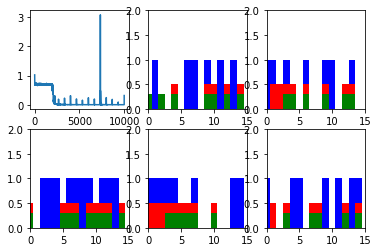

Step 100 Loss 0.0007598375
single_output_series: [0 1 0 0 0 1 0 1 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 1 0 1 0 0 1 1 0]

single_output_series: [1 0 1 0 0 1 0 0 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 0 0 0 0 0 1 1 0]

single_output_series: [1 1 1 1 0 1 1 1 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 1 0 1 1 1 1 0 0]

single_output_series: [0 0 0 1 0 0 1 0 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 0 0 1 1 1 0 1 1]

single_output_series: [1 0 1 0 1 0 1 1 1 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 1 1 0 0 1 0 0 1]



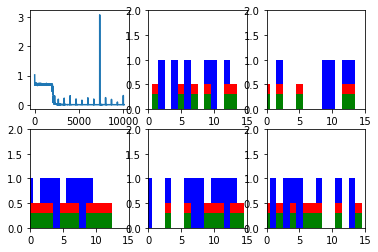

Step 200 Loss 0.0007018232
single_output_series: [0 0 0 0 0 1 1 0 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 1 0 1 1 1 1 1]

single_output_series: [0 0 1 0 0 1 1 0 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 0 1 1 0 1 0 0 0]

single_output_series: [1 0 1 1 0 1 0 0 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 0 1 1 0 1 0 1 0]

single_output_series: [0 1 1 0 0 0 1 1 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 1 0 0 0 0 1 1 0]

single_output_series: [0 0 1 0 0 1 0 1 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 1 0 1 0 0 0 1 1]



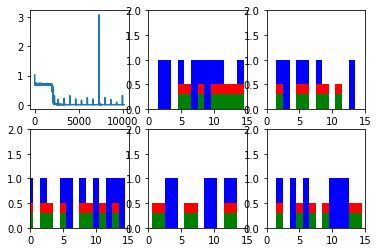

Step 300 Loss 0.0006555356
single_output_series: [0 1 0 1 1 1 1 0 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 0 0 1 1 0 0 1 0]

single_output_series: [0 0 0 0 0 1 1 1 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 1 0 0 0 0 1 0]

single_output_series: [1 1 0 1 0 1 1 0 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 0 1 0 1 0 0 0 1]

single_output_series: [1 0 1 1 1 1 1 1 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 1 1 0 1 1 0 1 1]

single_output_series: [1 0 1 1 1 0 1 0 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 0 0 1 1 0 0 1 1]



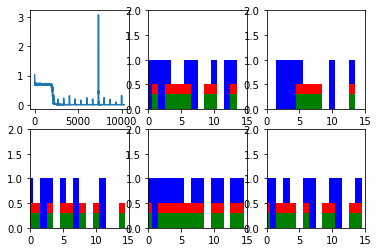

Step 400 Loss 0.000651898
single_output_series: [1 1 1 0 0 0 1 0 1 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 0 1 0 1 1 0 0 0]

single_output_series: [1 0 1 1 0 1 1 0 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 0 1 1 0 1 1 1 0]

single_output_series: [0 1 1 0 0 1 1 1 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 1 0 1 0 1 1 1 0]

single_output_series: [1 0 0 0 0 1 1 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 1 0 1 0 1 1 0 0]

single_output_series: [1 0 1 1 0 0 0 1 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 1 0 1 1 0 0 0 1]



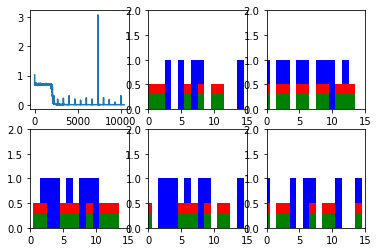

Step 500 Loss 0.0007012559
single_output_series: [0 1 1 0 1 1 1 1 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 1 1 1 0 0 0 0 1]

single_output_series: [1 1 1 0 0 0 1 1 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 1 1 1 1 1 0 1 1]

single_output_series: [1 1 0 1 1 1 1 1 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 1 0 0 0 1 0 0 1]

single_output_series: [1 0 1 0 0 1 1 0 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 0 1 0 0 0 0 1 0]

single_output_series: [0 1 0 1 1 0 0 0 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 0 1 1 0 1 0 1 0]



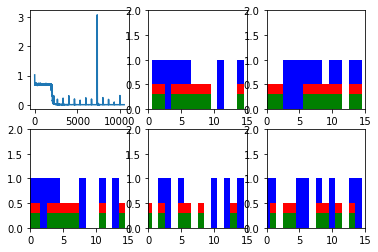

Step 600 Loss 0.0005100212
single_output_series: [1 1 0 0 0 0 0 0 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 0 0 0 0 0 1 0 1]

single_output_series: [1 0 1 1 1 1 0 0 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 0 0 0 0 0 1 1 1]

single_output_series: [1 1 0 0 1 1 0 0 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 0 1 0 1 1 0 1 1]

single_output_series: [0 0 1 0 0 0 0 1 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 1 1 0 0 1 0 0 0]

single_output_series: [0 1 1 1 1 1 0 0 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 0 1 0 0 1 1 0 0]



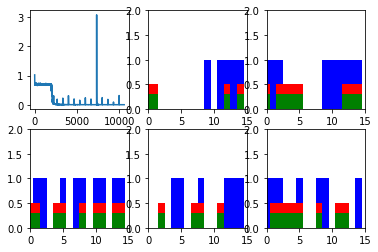

New data, epoch 16
Step 0 Loss 0.21467021
single_output_series: [0 0 0 1 1 1 0 1 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 1 1 1 1 1 1 0]

single_output_series: [0 0 0 1 1 1 0 0 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 0 0 1 1 1 0 1]

single_output_series: [1 0 1 0 1 1 1 1 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 1 1 0 1 1 0 0 1]

single_output_series: [1 0 1 0 1 0 0 1 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 1 0 0 0 0 0 1 1]

single_output_series: [1 0 1 0 1 0 0 0 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 0 1 1 0 1 1 1 1]



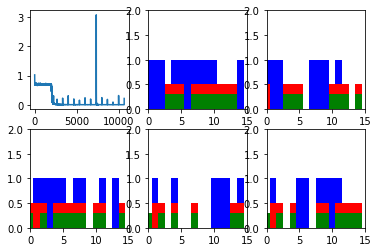

Step 100 Loss 0.00059607666
single_output_series: [0 1 0 1 0 0 0 1 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 1 0 1 1 1 1 1 0]

single_output_series: [0 0 1 0 0 1 1 1 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 1 0 0 1 1 1 1 0]

single_output_series: [1 1 0 0 0 0 0 0 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 0 1 0 0 0 1 0 0]

single_output_series: [0 1 1 1 0 1 1 0 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 0 0 0 0 0 1 1 0]

single_output_series: [0 0 1 1 0 1 0 1 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 1 0 0 0 0 0 1 1]



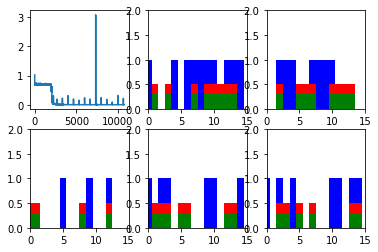

Step 200 Loss 0.00064687687
single_output_series: [0 1 0 0 0 0 0 1 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 1 0 1 1 0 1 0 0]

single_output_series: [0 0 1 1 1 0 1 0 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 0 0 1 0 0 1 1 0]

single_output_series: [1 1 1 1 0 0 1 1 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 1 1 0 1 0 1 1 1]

single_output_series: [0 0 0 0 0 0 1 1 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 0 0 0 0 1 0 1]

single_output_series: [1 1 1 0 0 0 1 0 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 0 1 0 1 1 1 1 1]



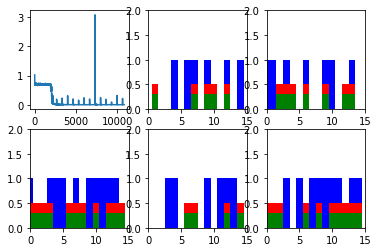

Step 300 Loss 0.0006234832
single_output_series: [0 0 1 1 1 1 1 0 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 0 1 1 1 1 0 0 0]

single_output_series: [1 1 1 1 1 0 1 1 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 1 1 0 0 0 1 0 1]

single_output_series: [0 1 1 1 0 0 0 1 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 1 1 1 0 1 1 1 1]

single_output_series: [0 0 1 1 1 0 0 0 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 0 0 0 0 1 1 0 1]

single_output_series: [0 1 1 1 0 0 0 0 0 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 0 0 1 0 1 1 1 0]



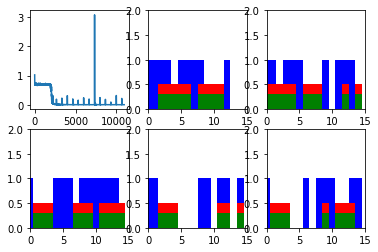

Step 400 Loss 0.0005897104
single_output_series: [0 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 1 1 1 0 1 1 1 0]

single_output_series: [1 0 1 0 0 0 1 1 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 1 1 0 0 0 0 0 0]

single_output_series: [0 0 1 1 1 0 1 1 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 1 1 1 1 1 1 0 1]

single_output_series: [0 1 1 0 0 0 1 0 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 0 1 1 0 1 0 0 1]

single_output_series: [0 1 1 0 0 0 0 1 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 0 0 0 1 1 1 1]



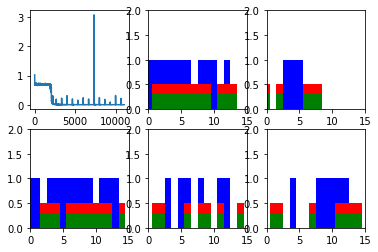

Step 500 Loss 0.00058551924
single_output_series: [0 0 0 0 1 0 1 0 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 0 1 1 1 1 0 1 0]

single_output_series: [0 1 0 1 0 0 0 0 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 0 1 0 0 0 1 0 1]

single_output_series: [0 0 1 0 0 1 1 0 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 0 0 1 1 1 1 1 1]

single_output_series: [0 0 1 1 0 0 1 0 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 0 1 1 0 1 1 1 1]

single_output_series: [1 1 1 1 1 0 1 0 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 0 0 1 1 1 0 1 0]



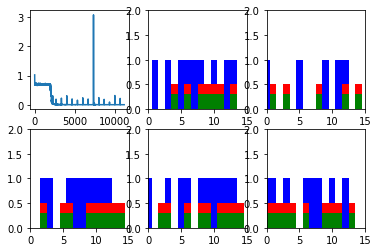

Step 600 Loss 0.0005440894
single_output_series: [0 1 0 1 1 1 1 0 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 0 0 1 0 1 1 0 1]

single_output_series: [0 1 1 0 0 0 0 1 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 0 1 1 0 0 0 0]

single_output_series: [0 0 1 1 0 1 0 0 0 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 0 0 0 1 0 0 0 0]

single_output_series: [0 0 0 1 1 0 1 1 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 0 1 0 1 1 0 1]

single_output_series: [1 0 1 1 1 1 0 0 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 0 0 1 1 0 1 0 0]



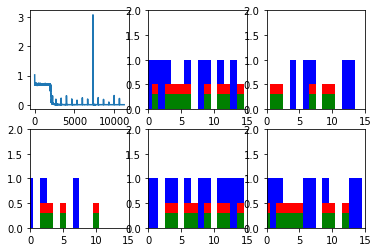

New data, epoch 17
Step 0 Loss 0.2888297
single_output_series: [0 0 0 1 0 0 0 1 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 1 1 0 0 0 1 1 1]

single_output_series: [1 0 1 0 0 0 1 1 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 1 0 0 0 0 0 1 1]

single_output_series: [0 0 0 1 0 0 0 1 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 1 1 0 1 0 1 0 0]

single_output_series: [0 0 0 1 1 1 0 1 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 1 0 0 0 0 1 1 1]

single_output_series: [1 0 1 0 1 1 1 1 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 1 0 1 0 0 0 0 1]



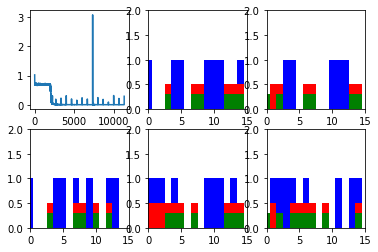

Step 100 Loss 0.00048248057
single_output_series: [1 0 1 1 0 0 1 1 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 1 1 0 1 0 0 0 0]

single_output_series: [1 1 0 0 0 1 1 0 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 0 0 1 1 1 1 0 1]

single_output_series: [1 1 0 1 0 0 0 0 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 0 0 0 1 1 0 1 1]

single_output_series: [1 0 0 1 1 0 0 0 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 0 1 1 1 0 1 0 0]

single_output_series: [0 0 0 1 1 0 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 1 1 1 1 1 1 1]



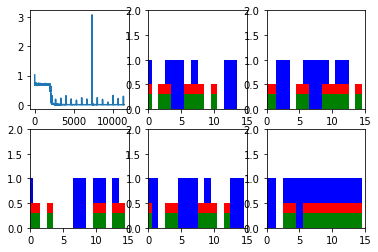

Step 200 Loss 0.00052074774
single_output_series: [1 1 0 0 1 0 1 1 0 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 0 0 1 0 0 1 1]

single_output_series: [1 0 1 1 0 0 0 0 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 0 0 0 1 0 1 1 1]

single_output_series: [0 1 1 1 0 1 0 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 1 0 0 1 1 1 0 0]

single_output_series: [0 0 0 0 0 0 1 1 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 0 1 1 1 0 1 0]

single_output_series: [0 1 1 0 1 1 0 0 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 0 1 0 1 1 0 1 0]



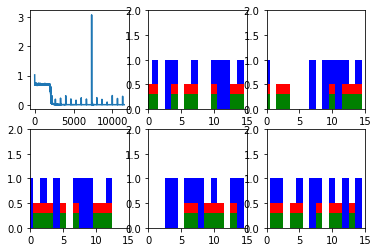

Step 300 Loss 0.0005512409
single_output_series: [0 0 0 1 1 1 1 1 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 1 0 1 0 1 0 0]

single_output_series: [0 1 1 1 1 0 0 1 1 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 1 1 1 1 0 0 1 1]

single_output_series: [1 0 1 1 0 0 0 0 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 0 0 1 0 0 1 1 0]

single_output_series: [0 0 0 0 1 1 1 0 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 0 1 1 0 0 0 1 1]

single_output_series: [1 0 1 1 1 0 1 1 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 1 0 1 0 1 1 0]



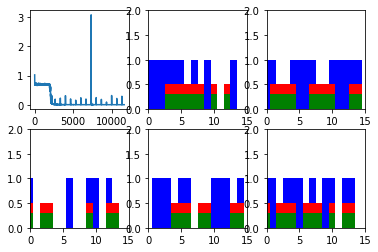

Step 400 Loss 0.00052013196
single_output_series: [1 0 0 1 1 1 0 0 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 1 1 1 1 1 0 0]

single_output_series: [1 0 0 1 1 1 0 1 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 1 0 0 0 0 0 1 1]

single_output_series: [0 1 0 0 1 1 1 1 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 1 0 0 0 1 0 1 1]

single_output_series: [1 1 1 1 1 0 1 1 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 1 1 0 0 1 1 1 1]

single_output_series: [0 0 0 0 1 0 0 1 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 1 1 0 0 0 1 1 1]



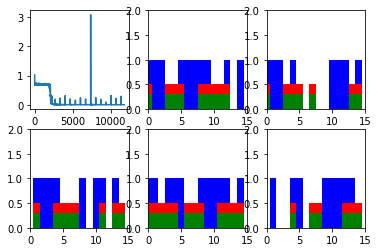

Step 500 Loss 0.00051827816
single_output_series: [0 1 0 0 1 0 1 1 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 1 1 0 1 0 0 1 1]

single_output_series: [1 1 1 0 0 1 1 1 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 1 1 0 1 0 0 0 1]

single_output_series: [1 0 1 1 0 0 0 0 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 0 1 1 0 0 0 0 0]

single_output_series: [1 0 1 1 1 1 0 1 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 1 0 1 1 1 1 0 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 0 0 0 1 1 1 0 1]



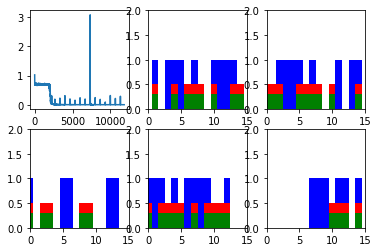

Step 600 Loss 0.0005366912
single_output_series: [0 0 1 1 1 0 0 1 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 1 0 0 1 1 1 0 1]

single_output_series: [1 1 1 1 1 1 1 1 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 1 1 0 0 1 1 1 1]

single_output_series: [1 0 1 0 0 0 0 1 0 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 1 0 1 1 1 0 0 1]

single_output_series: [1 0 1 0 0 1 0 0 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 0 1 1 1 0 1 0 0]

single_output_series: [1 0 1 0 0 0 0 1 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 1 1 0 1 0 1 0 1]



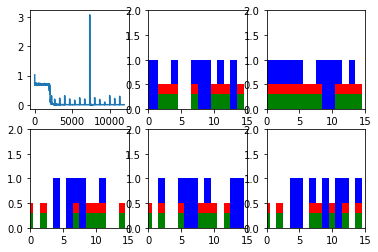

New data, epoch 18
Step 0 Loss 0.25580716
single_output_series: [0 0 0 1 1 0 1 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 0 1 0 1 1 0 0]

single_output_series: [1 0 1 0 1 0 1 0 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 0 1 0 0 1 0 0 0]

single_output_series: [1 0 1 0 1 0 1 1 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 1 1 0 0 1 1 0 1]

single_output_series: [0 0 0 1 0 0 1 0 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 0 1 0 1 0 0 0 1]

single_output_series: [1 0 1 0 0 0 1 1 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 1 0 0 0 1 1 0 1]



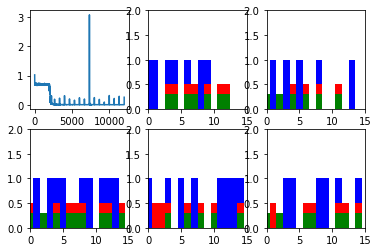

Step 100 Loss 0.0005012639
single_output_series: [0 1 1 0 1 1 0 0 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 0 1 1 1 1 1 0 0]

single_output_series: [1 1 0 0 0 0 0 0 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 0 0 1 0 1 0 1 0]

single_output_series: [1 0 1 0 0 1 1 1 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 1 0 1 0 0 1 0 0]

single_output_series: [1 1 0 1 0 0 1 1 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 1 0 1 1 1 0 1 0]

single_output_series: [1 0 1 1 1 0 0 0 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 0 0 0 0 1 1 0 0]



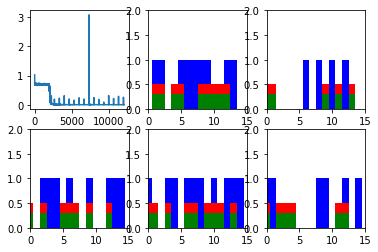

Step 200 Loss 0.00054998643
single_output_series: [1 0 1 1 0 1 0 1 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 1 0 0 1 0 1 1 1]

single_output_series: [1 1 1 1 1 0 1 1 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 1 1 0 0 0 0 1 0]

single_output_series: [0 1 1 0 1 0 1 0 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 0 1 0 1 1 0 0 1]

single_output_series: [0 1 1 1 0 1 0 0 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 0 0 1 1 1 0 1 1]

single_output_series: [0 1 1 1 0 0 1 1 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 1 1 1 1 0 0 1 0]



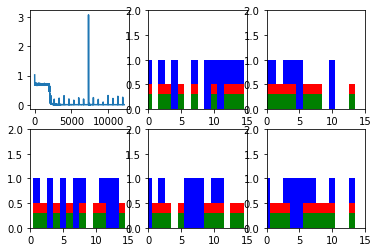

Step 300 Loss 0.00046552083
single_output_series: [0 0 0 1 1 0 0 1 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 0 0 1 1 0 0 0]

single_output_series: [1 0 1 1 0 1 0 1 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 1 1 0 1 0 1 1 1]

single_output_series: [0 1 0 1 1 1 0 0 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 0 0 0 0 1 0 0 0]

single_output_series: [0 1 1 0 0 1 1 0 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 0 1 1 1 0 0 1 0]

single_output_series: [1 1 1 0 1 1 0 1 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 1 0 1 1 0 0 1 1]



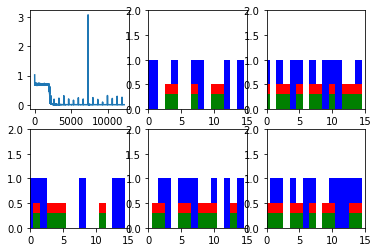

Step 400 Loss 0.0004769998
single_output_series: [0 0 0 0 0 0 0 1 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 1 0 0 0 0 1 1 1]

single_output_series: [1 1 0 0 0 1 1 1 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 1 0 0 1 1 0 1 0]

single_output_series: [1 1 1 0 0 0 1 0 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 0 0 0 0 1 0 1 1]

single_output_series: [0 1 1 0 0 1 1 0 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 0 1 1 0 0 0 1 0]

single_output_series: [0 1 1 0 0 1 1 0 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 0 0 0 0 0 1 1 0]



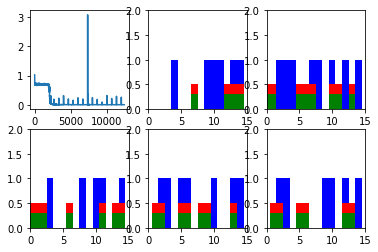

Step 500 Loss 0.000450424
single_output_series: [0 1 0 1 1 0 0 0 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 0 0 1 0 1 1 0 1]

single_output_series: [0 1 1 0 0 0 1 1 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 1 0 1 1 1 1 1 1]

single_output_series: [1 0 0 1 0 1 0 1 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 1 1 0 0 1 1 0]

single_output_series: [0 1 1 0 1 1 0 1 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 1 1 0 0 0 0 0 0]

single_output_series: [0 1 0 1 1 1 1 1 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 1 1 1 0 1 0 1 1]



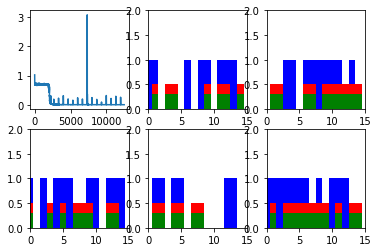

Step 600 Loss 0.00039910685
single_output_series: [1 1 0 0 0 1 1 1 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 1 0 0 1 0 1 0 0]

single_output_series: [1 0 0 0 0 1 0 0 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 0 1 0 1 1 0 1 1]

single_output_series: [0 1 1 0 0 0 0 0 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 0 1 1 0 0 1 1 0]

single_output_series: [0 1 1 1 1 1 0 0 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 0 1 1 0 1 0 0 1]

single_output_series: [1 1 1 0 0 0 0 1 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 1 0 0 0 1 1 1]



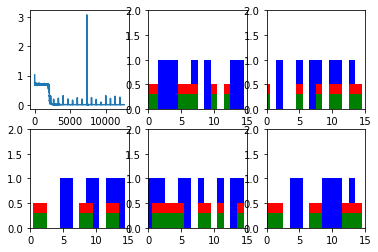

New data, epoch 19
Step 0 Loss 0.29351294
single_output_series: [0 0 0 1 1 0 1 0 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 0 0 0 1 0 1 0 0]

single_output_series: [1 0 0 0 0 0 0 1 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 0 1 0 0 0 1 1]

single_output_series: [1 0 0 0 0 1 1 1 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 1 1 0 0 1 1 1 0]

single_output_series: [1 0 0 0 1 1 0 0 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 0 1 0 0 1 1 1 0]

single_output_series: [1 0 0 0 1 1 0 1 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 1 0 0 1 0 1 0]



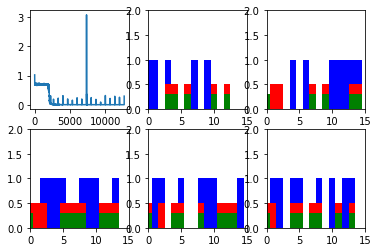

Step 100 Loss 0.00045607894
single_output_series: [0 0 1 1 0 1 1 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 0 0 1 0 1 0 0 0]

single_output_series: [1 1 0 1 1 0 0 1 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 1 0 1 0 0 0 0 1]

single_output_series: [0 0 1 0 0 0 0 1 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 1 0 0 1 1 1 1 1]

single_output_series: [0 0 0 1 1 0 0 0 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 0 0 0 0 0 1 1 0]

single_output_series: [1 1 0 1 1 0 0 0 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 0 1 0 1 1 0 1 1]



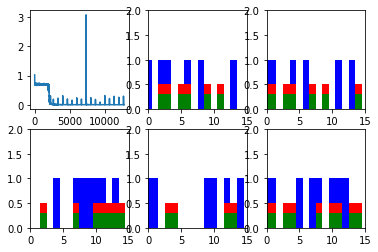

Step 200 Loss 0.00044113764
single_output_series: [0 1 0 0 0 1 0 0 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 0 1 1 0 0 0 1 1]

single_output_series: [0 1 1 0 0 1 1 1 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 1 1 1 0 1 1 0 1]

single_output_series: [0 0 1 1 1 0 0 0 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 0 1 1 1 1 1 0 0]

single_output_series: [1 0 0 1 1 1 1 1 0 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 1 0 1 0 1 0 0 1]

single_output_series: [1 0 0 1 1 1 1 1 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 1 0 1 0 1 1 1 1]



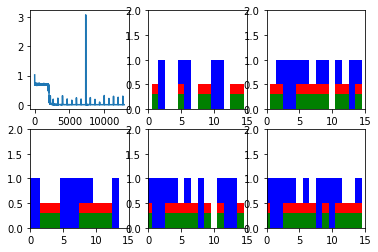

Step 300 Loss 0.00045214957
single_output_series: [1 1 0 0 1 0 0 1 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 1 1 1 0 1 1 1 0]

single_output_series: [1 0 0 0 1 1 1 0 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 0 1 1 1 1 1 0 1]

single_output_series: [1 1 0 0 0 1 0 1 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 1 1 1 1 0 1 0 1]

single_output_series: [0 0 1 1 0 0 1 1 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 1 1 0 0 1 0 0 0]

single_output_series: [0 1 0 0 0 0 0 1 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 1 0 1 1 0 0 1 1]



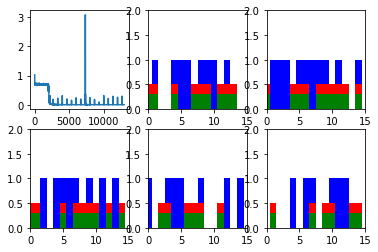

Step 400 Loss 0.00048926397
single_output_series: [1 0 0 1 1 1 1 1 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 1 0 1 1 1 1 0 1]

single_output_series: [0 0 1 0 0 1 0 1 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 1 0 1 0 0 0 0 0]

single_output_series: [0 1 0 1 0 1 1 1 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 1 1 0 1 1 1 1]

single_output_series: [1 1 1 1 0 1 0 0 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 0 1 0 1 0 1 0]

single_output_series: [0 0 1 1 0 1 1 0 1 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 0 1 0 0 1 1 1 0]



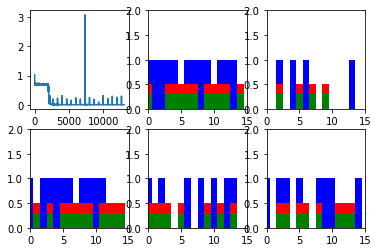

Step 500 Loss 0.00043073748
single_output_series: [0 1 0 0 1 1 1 0 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 0 0 0 0 1 1 0 1]

single_output_series: [1 0 1 1 0 0 0 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 0 1 0 1 0 1 1 1]

single_output_series: [1 0 0 1 1 1 0 0 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 1 0 0 0 0 1 0]

single_output_series: [0 0 1 0 1 0 1 0 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 0 1 1 0 1 1 1]

single_output_series: [1 0 0 1 1 1 0 0 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 0 1 1 1 1 0 1]



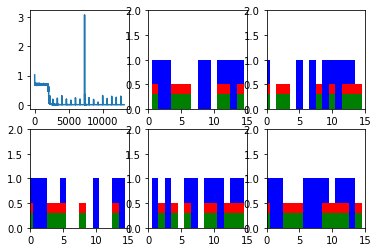

Step 600 Loss 0.00042798088
single_output_series: [1 1 1 1 1 0 1 0 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 0 1 0 1 0 1 0 1]

single_output_series: [1 1 1 0 0 0 0 0 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 0 1 1 0 1 0 1 1]

single_output_series: [0 1 0 1 1 0 1 1 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 1 1 0 1 0 0 0 1]

single_output_series: [1 0 0 1 0 0 1 1 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 1 0 0 1 1 0 1 0]

single_output_series: [0 0 0 1 0 1 1 1 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 1 0 0 1 1 1 0 1]



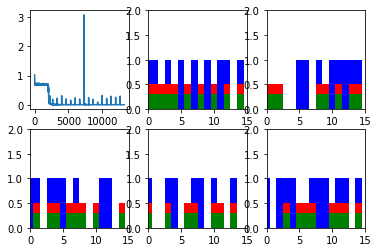

New data, epoch 20
Step 0 Loss 0.14092119
single_output_series: [1 0 1 0 1 0 1 1 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 1 1 0 1 1 1 1 0]

single_output_series: [0 0 1 1 1 0 1 1 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 0 0 0 0 1 1 0]

single_output_series: [0 1 0 1 0 1 1 0 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 0 0 1 1 0 0 1 1]

single_output_series: [1 0 1 0 0 0 1 0 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 0 0 0 1 1 0 0 1]

single_output_series: [0 1 0 1 0 1 0 0 0 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 0 0 0 1 0 0 0 0]



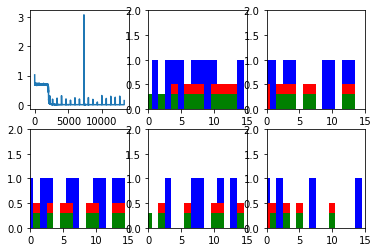

Step 100 Loss 0.0003565142
single_output_series: [0 1 1 1 0 0 0 0 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 0 0 0 1 1 0 1 0]

single_output_series: [1 1 0 1 1 1 0 0 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 0 1 1 0 0 1 0 1]

single_output_series: [0 1 1 0 0 0 0 1 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 1 0 1 1 0 0 1]

single_output_series: [1 0 0 1 0 1 0 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 0 0 0 1 1 1 0 0]

single_output_series: [1 1 1 1 0 0 1 1 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 1 1 1 0 0 0 1 0]



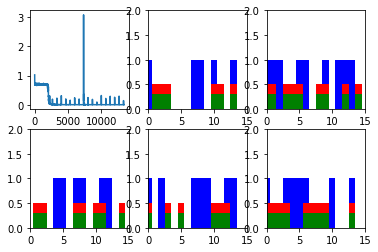

Step 200 Loss 0.00037251101
single_output_series: [1 0 1 0 1 0 1 0 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 0 1 1 1 1 1 1 1]

single_output_series: [1 0 0 1 0 1 1 0 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 0 0 1 1 1 0 1 1]

single_output_series: [0 0 0 1 0 0 1 0 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 0 0 1 1 1 1 0 0]

single_output_series: [1 0 1 0 1 1 0 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 1 0 0 0 1 1 1 0]

single_output_series: [0 1 0 0 1 0 0 1 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 1 0 1 0 0 0 0]



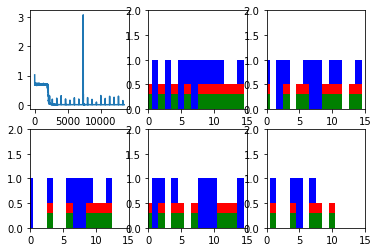

Step 300 Loss 0.00038324084
single_output_series: [0 1 1 0 0 0 1 1 1 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 1 1 0 0 1 0 0 1]

single_output_series: [1 0 0 1 1 1 0 0 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 0 0 0 0 0 1 1 1]

single_output_series: [1 1 1 1 0 0 0 0 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 0 1 1 1 0 0 0 0]

single_output_series: [0 0 1 0 1 1 1 0 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 0 0 1 1 0 0 1]

single_output_series: [0 1 0 0 0 1 1 0 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 0 1 1 1 0 1 1 1]



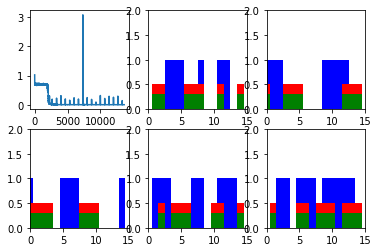

Step 400 Loss 0.00041957916
single_output_series: [1 0 0 0 1 0 1 0 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 0 0 0 1 0 1 0 1]

single_output_series: [0 0 1 0 0 0 1 0 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 0 1 0 1 0 0 1 0]

single_output_series: [1 0 0 1 1 0 0 1 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 1 0 1 0 1 1 1 1]

single_output_series: [1 1 1 1 1 0 0 1 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 1 0 0 0 1 1 0 0]

single_output_series: [0 0 1 1 1 0 0 1 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 1 1 1 1 1 0 0 0]



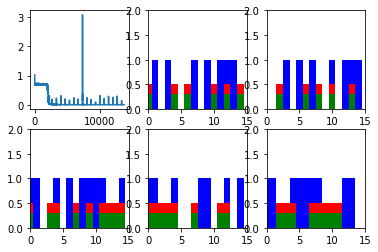

Step 500 Loss 0.0003857627
single_output_series: [0 1 1 1 1 1 1 0 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 0 1 1 0 1 1 0 1]

single_output_series: [0 1 0 1 1 0 0 0 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 0 0 1 0 0 0 0 0]

single_output_series: [1 1 0 1 1 1 0 0 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 0 1 1 0 0 0 0 1]

single_output_series: [1 1 1 0 0 0 0 0 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 0 0 1 0 1 0 1 1]

single_output_series: [0 1 1 0 0 0 1 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 1 0 1 0 1 1 0 0]



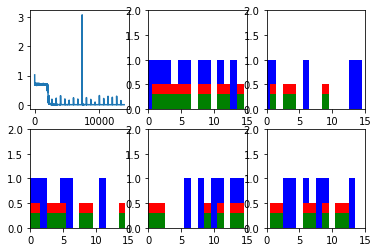

Step 600 Loss 0.0003403028
single_output_series: [1 0 0 0 1 0 1 1 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 1 0 0 1 0 1 0 0]

single_output_series: [1 0 1 0 1 1 1 1 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 1 1 0 0 1 0 1 1]

single_output_series: [0 1 0 0 1 1 1 1 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 1 1 0 0 0 0 1 1]

single_output_series: [0 1 0 1 1 0 0 1 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 1 1 1 1 1 1 0 0]

single_output_series: [0 0 1 1 0 1 1 0 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 0 1 0 1 1 1 0 1]



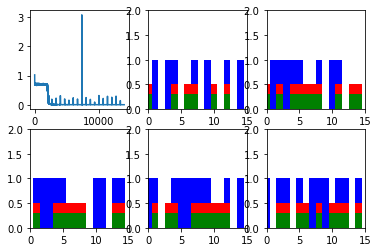

New data, epoch 21
Step 0 Loss 0.15161294
single_output_series: [0 1 0 1 0 0 0 0 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 0 1 0 0 1 1 0 0]

single_output_series: [0 0 0 1 1 0 1 1 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 1 0 1 0 0 0 1]

single_output_series: [1 0 1 0 0 1 1 0 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 0 1 1 0 0 0 0 1]

single_output_series: [0 1 0 1 0 0 0 0 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 0 0 1 0 1 0 1 1]

single_output_series: [0 0 0 1 1 0 0 0 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 0 0 1 1 1 1 0 1]



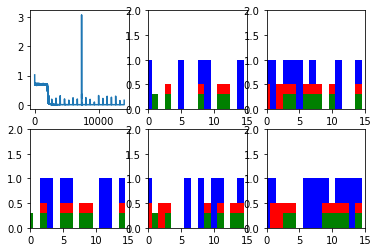

Step 100 Loss 0.00048495963
single_output_series: [1 0 0 1 0 1 1 0 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 0 1 1 1 0 0 0 0]

single_output_series: [1 0 0 0 1 0 1 0 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 0 1 1 0 1 0 0 0]

single_output_series: [1 1 1 0 1 0 0 1 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 1 1 0 1 0 1 1 1]

single_output_series: [0 1 0 0 0 1 0 1 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 1 1 0 0 1 0 1 0]

single_output_series: [0 1 1 0 1 1 1 0 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 0 1 1 0 0 0 1 1]



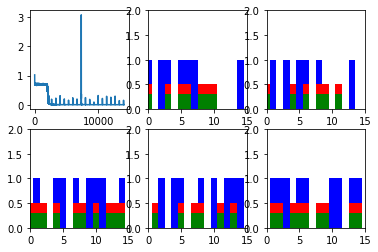

Step 200 Loss 0.00039050978
single_output_series: [1 0 0 0 0 0 1 0 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 0 1 1 0 1 1 0 0]

single_output_series: [0 1 0 0 0 0 0 1 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 1 0 1 0 0 0 0 1]

single_output_series: [0 0 1 0 0 1 1 1 1 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 1 1 1 1 0 0 0 0]

single_output_series: [1 0 1 0 1 0 0 1 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 1 0 0 1 1 0 0 0]

single_output_series: [0 0 0 0 0 0 0 0 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 0 1 1 1 1 1 0 1]



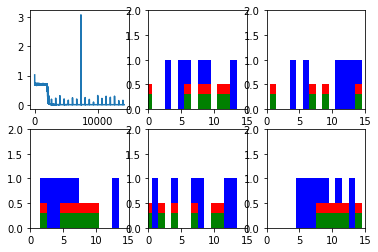

Step 300 Loss 0.00035648563
single_output_series: [1 1 0 1 1 1 0 0 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 0 1 0 0 0 0 1 1]

single_output_series: [1 0 0 1 0 0 1 0 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 0 0 1 1 0 0 0 1]

single_output_series: [1 0 0 1 1 1 0 1 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 1 1 0 1 0 1 1 0]

single_output_series: [1 0 1 1 0 0 1 1 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 1 1 1 1 0 1 0 1]

single_output_series: [1 1 1 0 1 0 0 0 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 0 0 1 0 0 1 0 0]



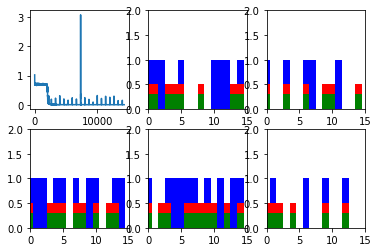

Step 400 Loss 0.00042415605
single_output_series: [0 1 0 0 0 1 1 1 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 1 1 0 1 1 0 1 1]

single_output_series: [0 0 1 1 0 1 0 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 0 0 1 0 1 0 0 0]

single_output_series: [1 1 1 0 1 0 0 0 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 0 0 0 1 0 1 1 1]

single_output_series: [1 1 1 1 0 1 0 1 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 1 1 0 1 1 0 0 1]

single_output_series: [0 1 0 1 1 1 1 0 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 0 0 1 0 1 0 1 0]



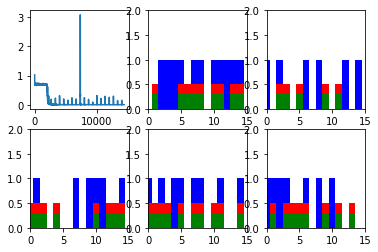

Step 500 Loss 0.00034148604
single_output_series: [1 1 0 0 1 1 1 0 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 0 0 0 1 1 0 0 0]

single_output_series: [0 0 0 1 1 0 0 1 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 1 1 1 1 1 1 0]

single_output_series: [0 0 1 0 0 1 1 0 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 0 0 0 0 0 1 0 1]

single_output_series: [1 0 0 1 0 0 1 1 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 1 1 1 0 0 0 1 0]

single_output_series: [0 1 1 1 1 1 1 1 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 1 1 0 1 1 1 1 1 0]



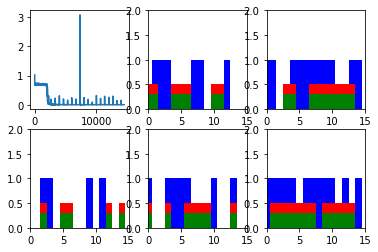

Step 600 Loss 0.0004244098
single_output_series: [0 1 0 1 0 1 0 0 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 0 1 1 0 1 0 0 0]

single_output_series: [1 0 1 0 0 1 1 0 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 0 0 0 1 1 0 1 0]

single_output_series: [0 1 0 1 1 1 0 1 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 1 1 0 0 0 0 0 0]

single_output_series: [1 0 1 1 1 1 1 0 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 0 0 0 1 0 1 0 0]

single_output_series: [0 1 0 0 1 1 0 1 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 1 1 1 0 1 0 1 1]



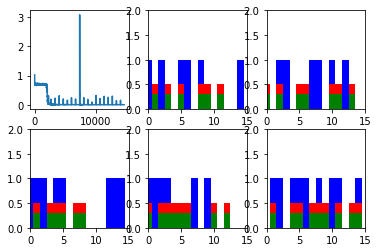

New data, epoch 22
Step 0 Loss 0.38363734
single_output_series: [1 0 1 0 0 1 1 1 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 0 0 0 0 1 1 1]

single_output_series: [1 0 1 1 1 0 0 1 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 1 1 0 1 0 0 0 1]

single_output_series: [1 0 1 0 0 0 1 0 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 0 1 0 0 0 1 0 1]

single_output_series: [1 0 1 0 0 0 1 0 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 0 1 0 0 1 1 1 1]

single_output_series: [1 0 1 1 1 1 1 0 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 0 1 0 1 0 1 1 0]



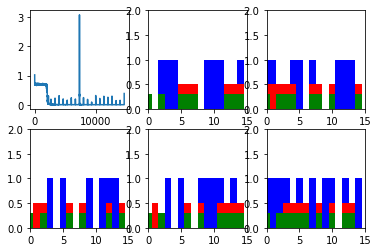

Step 100 Loss 0.0003589406
single_output_series: [1 0 1 1 1 1 0 0 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 0 0 1 0 1 1 0 0]

single_output_series: [0 0 0 1 0 0 1 0 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 0 1 1 0 1 1 0 0]

single_output_series: [1 0 1 1 0 1 0 1 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 1 1 1 1 0 1 1 0]

single_output_series: [1 1 0 1 0 1 0 1 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 1 0 1 0 0 1 0 0]

single_output_series: [0 0 1 0 1 1 1 0 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 0 0 0 1 0 0 1]



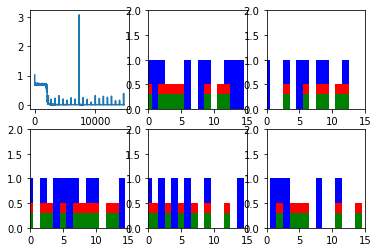

Step 200 Loss 0.00032653974
single_output_series: [0 1 0 1 1 0 0 1 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 1 0 1 0 0 1 1 0]

single_output_series: [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0]

single_output_series: [1 0 0 1 1 1 1 1 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 1 0 1 1 0 1 1 1]

single_output_series: [1 1 0 0 1 0 1 1 0 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 0 0 0 0 0 1 0]

single_output_series: [0 1 0 1 1 1 0 0 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 0 1 0 0 1 1 0 0]



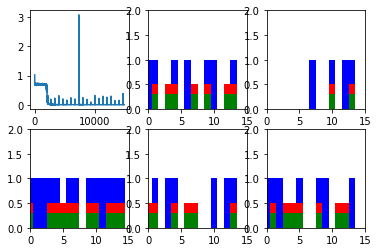

Step 300 Loss 0.00042065443
single_output_series: [0 0 0 0 1 0 0 1 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 1 0 0 1 0 0 0 1]

single_output_series: [0 1 0 1 0 0 0 0 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 0 0 1 1 1 1 1 1]

single_output_series: [0 0 1 0 1 1 1 1 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 1 0 1 0 1 0 1 1]

single_output_series: [1 1 1 1 0 1 1 0 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 0 1 1 1 1 1 1 0]

single_output_series: [1 1 1 1 0 1 0 1 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 1 1 1 1 0 1 0 1]



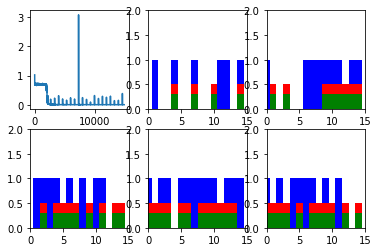

Step 400 Loss 0.00044838042
single_output_series: [1 1 0 0 1 0 0 0 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 0 1 1 1 0 1 1 0]

single_output_series: [0 0 0 0 0 0 1 0 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 1 0 0 1 1 1 1]

single_output_series: [1 1 1 1 1 0 0 0 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 0 1 0 1 1 1 0 1]

single_output_series: [1 0 1 0 1 1 1 1 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 1 1 1 0 1 1 1 0]

single_output_series: [1 0 0 0 1 0 1 1 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 1 1 0 1 0 1 1 1]



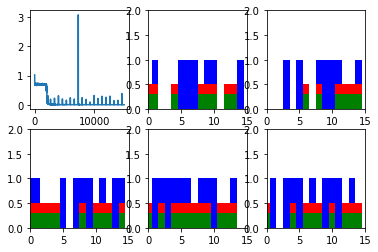

Step 500 Loss 0.00039942292
single_output_series: [1 0 1 1 0 1 0 0 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 0 1 0 1 0 1 1 0]

single_output_series: [0 1 1 1 1 0 0 1 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 1 0 1 0 1 1 1 1]

single_output_series: [0 1 1 0 0 0 1 1 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 1 1 0 0 0 1 0 0]

single_output_series: [1 1 1 0 1 1 1 0 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 0 1 0 1 1 1 1 0]

single_output_series: [0 1 1 0 0 1 0 0 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 1 1 1 1 0 1 0]



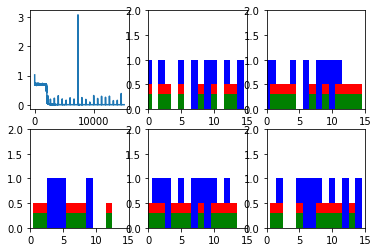

Step 600 Loss 0.00039255357
single_output_series: [1 1 1 1 0 1 0 0 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 0 0 1 1 0 0 1]

single_output_series: [0 1 1 1 1 0 1 1 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 0 1 0 1 0 0 0]

single_output_series: [0 1 1 1 0 0 0 1 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 1 1 1 0 1 0 0 1]

single_output_series: [1 1 0 0 0 0 0 1 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 1 0 1 1 1 1 1 1]

single_output_series: [0 1 1 0 0 0 1 1 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 1 1 1 1 0 1 0 0]



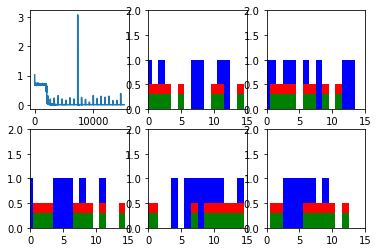

New data, epoch 23
Step 0 Loss 0.15650865
single_output_series: [0 0 1 1 1 0 1 1 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 1 0 0 1 0 1 1]

single_output_series: [0 1 0 1 0 1 0 1 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 1 1 1 0 0 0 1 0]

single_output_series: [0 0 1 1 1 1 1 1 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 1 0 1 1 1 0 1 0]

single_output_series: [0 0 1 1 1 0 1 1 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 1 0 0 1 0 0 0]

single_output_series: [1 0 1 0 0 1 0 1 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 0 0 1 1 0 0 1]



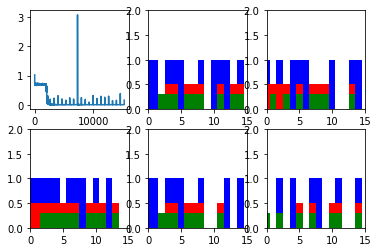

Step 100 Loss 0.00030173257
single_output_series: [1 1 0 1 0 1 1 0 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 0 1 1 0 0 1 0 0]

single_output_series: [1 1 0 1 1 1 0 1 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 1 1 1 1 1 0 0 0]

single_output_series: [1 1 1 0 1 1 0 1 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 1 1 0 0 0 1 1 1]

single_output_series: [1 0 1 0 1 1 0 1 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 1 1 0 1 1 0 1 1]

single_output_series: [1 0 0 1 1 0 0 1 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 1 1 1 1 0 1 1 1]



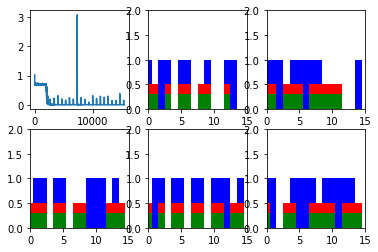

Step 200 Loss 0.00030805406
single_output_series: [1 0 0 0 1 0 0 0 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 0 1 0 0 0 1 0 0]

single_output_series: [0 0 1 0 0 0 0 0 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 0 0 1 0 0 0 0 1]

single_output_series: [1 1 0 1 1 0 1 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 0 0 0 1 1 1 0 0]

single_output_series: [1 1 0 1 0 1 1 0 1 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 0 1 0 0 0 0 0 0]

single_output_series: [1 1 0 1 1 1 1 0 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 0 0 0 1 1 0 1 1]



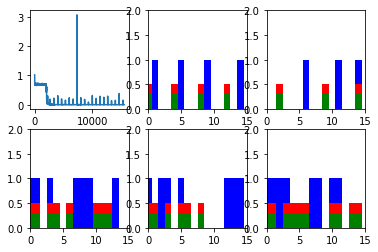

Step 300 Loss 0.00036304988
single_output_series: [0 1 1 1 1 1 0 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 1 0 0 0 1 1 1 0]

single_output_series: [0 1 0 1 0 0 1 1 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 0 1 0 0 1 0 1]

single_output_series: [0 0 0 1 1 1 0 1 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 1 0 1 0 1 0 1]

single_output_series: [0 1 0 0 1 0 1 0 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 0 1 0 0 1 1 0 0]

single_output_series: [0 1 1 1 1 0 1 1 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 1 1 1 1 0 0 1]



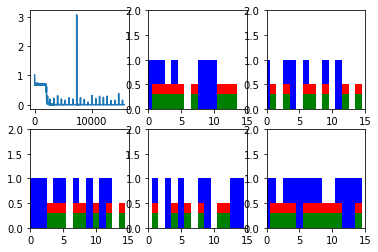

Step 400 Loss 0.00033405455
single_output_series: [1 0 1 1 0 0 1 0 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 0 0 1 1 0 0 0 1]

single_output_series: [1 1 0 1 0 1 0 1 0 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 1 0 0 1 0 0 1 1]

single_output_series: [0 0 0 1 1 1 0 1 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 1 0 1 0 1 0 1]

single_output_series: [1 1 0 1 1 0 0 1 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 1 1 0 1 1 0 0 1]

single_output_series: [0 0 1 1 1 1 1 1 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 1 1 1 1 1 1 0 1]



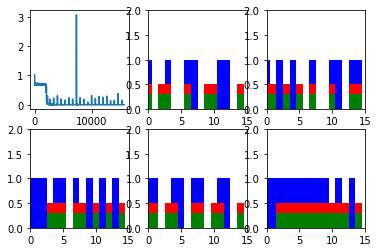

Step 500 Loss 0.00036126553
single_output_series: [1 1 0 1 0 1 0 0 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 0 1 0 0 0 0 1 0]

single_output_series: [0 1 1 1 1 1 0 0 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 0 0 1 1 1 1 0 0]

single_output_series: [1 0 0 0 0 1 0 0 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 0 0 0 1 1 1 0 1 0]

single_output_series: [0 0 1 0 1 0 0 1 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 1 0 0 1 1 1 1 1]

single_output_series: [1 0 0 0 1 1 0 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 1 0 0 0 1 1 1 0]



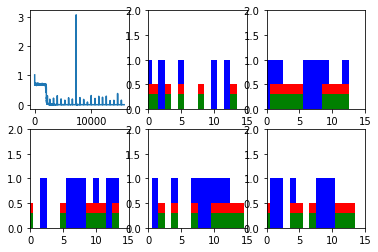

Step 600 Loss 0.00033123876
single_output_series: [1 1 0 1 0 1 1 0 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 0 1 1 0 0 0 0 1]

single_output_series: [1 0 1 0 1 1 0 0 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 0 0 1 0 0 1 0 0]

single_output_series: [0 1 0 0 0 1 1 1 1 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 1 1 0 0 1 0 0 1]

single_output_series: [1 1 0 1 1 1 0 0 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 0 1 0 1 1 1 1 1]

single_output_series: [1 1 0 1 0 1 0 0 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 0 1 1 1 1 0 0 1]



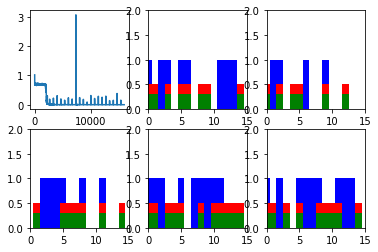

New data, epoch 24
Step 0 Loss 0.11562364
single_output_series: [0 0 0 1 1 1 0 0 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 0 0 0 0 1 0 0 1]

single_output_series: [0 0 0 1 0 0 0 1 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 1 1 1 1 1 1 0 1]

single_output_series: [0 0 0 1 0 1 0 0 1 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 1 0 0 0 0 0 1]

single_output_series: [0 0 0 1 1 1 1 0 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 0 1 0 1 1 1 0 1]

single_output_series: [1 0 1 0 1 0 1 0 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0]



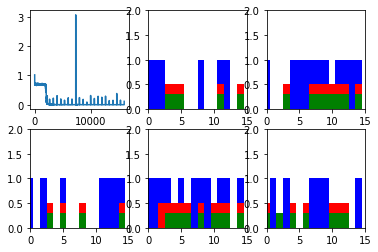

Step 100 Loss 0.0003874279
single_output_series: [1 0 0 0 0 0 1 1 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 1 0 0 0 0 1 1 1]

single_output_series: [1 1 0 0 1 0 0 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 1 1 1 1 0 0 0 1]

single_output_series: [0 0 0 1 0 1 0 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 0 1 0 1 0 0 0]

single_output_series: [0 0 0 0 0 1 0 1 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 1 1 0 1 0 1 0]

single_output_series: [1 0 1 0 0 0 0 1 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 1 0 0 1 1 0 0 0]



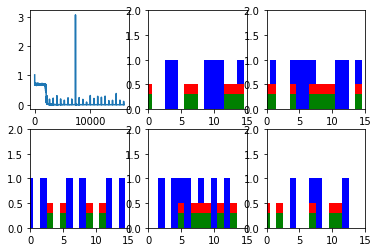

Step 200 Loss 0.0003629147
single_output_series: [0 0 1 1 1 1 1 0 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 0 1 0 0 0 0 1 1]

single_output_series: [0 0 1 1 1 0 0 1 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 1 1 0 0 0 1 1 1]

single_output_series: [0 1 1 1 1 1 0 1 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 1 1 0 1 0 1 0 1]

single_output_series: [1 0 0 0 1 0 1 0 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 0 1 0 1 1 1 0 1]

single_output_series: [1 1 0 0 0 1 1 1 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 1 1 0 0 1 0 1 0]



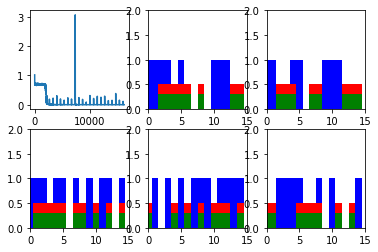

Step 300 Loss 0.00033994255
single_output_series: [0 1 1 0 0 0 0 1 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 0 0 0 1 0 1 0]

single_output_series: [1 0 1 1 1 1 1 1 0 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 1 0 0 1 0 0 1 1]

single_output_series: [1 1 0 0 1 1 0 1 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 1 1 1 0 1 0 1]

single_output_series: [0 0 1 1 0 1 0 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 0 0 0 0 1 1 1 0]

single_output_series: [0 1 0 0 1 1 1 1 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 1 0 1 1 0 1 1 0]



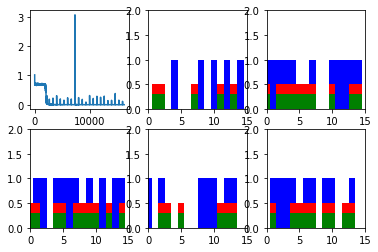

Step 400 Loss 0.00030593455
single_output_series: [1 1 0 1 0 1 1 0 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 0 1 1 1 1 0 0 0]

single_output_series: [1 0 0 1 0 0 1 1 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 1 1 0 0 0 1 0 1]

single_output_series: [1 0 1 1 0 1 1 0 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 0 1 1 1 1 1 1 0]

single_output_series: [0 0 1 1 0 1 0 0 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 0 0 0 1 1 1 0 1]

single_output_series: [0 1 1 0 0 1 1 1 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 1 1 1 0 0 1 1 1]



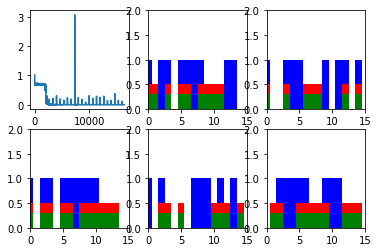

Step 500 Loss 0.00034702627
single_output_series: [0 0 0 1 0 1 1 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 0 0 0 0 1 1 1 0]

single_output_series: [1 0 1 0 1 0 0 1 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 1 1 0 1 1 1 0 0]

single_output_series: [0 1 1 0 0 1 0 1 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 1 0 1 1 1 1 1 1]

single_output_series: [0 0 1 1 1 1 0 1 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 1 1 1 1 0 1 1 1]

single_output_series: [1 1 0 1 0 1 1 0 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 0 0 1 1 0 0 0 0]



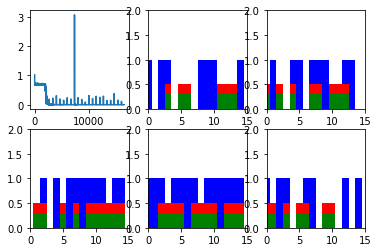

Step 600 Loss 0.00033842342
single_output_series: [0 0 1 0 0 1 0 1 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 1 1 0 1 0 1 1 0]

single_output_series: [1 1 0 1 0 0 1 1 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 1 1 1 0 1 0 0 0]

single_output_series: [1 1 1 1 0 1 1 0 1 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 0 1 0 0 1 0 0 1]

single_output_series: [1 1 1 1 1 0 0 0 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 0 0 0 0 1 0 1 0]

single_output_series: [1 1 1 1 1 0 1 1 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 1 0 0 0 1 0 1 0]



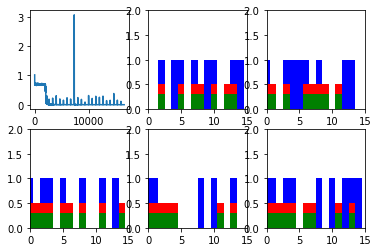

New data, epoch 25
Step 0 Loss 0.2010008
single_output_series: [1 0 0 0 0 0 0 0 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 0 0 0 0 1 1 1 0]

single_output_series: [1 0 0 0 1 1 1 1 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 1 1 0 1 1 1 1 1]

single_output_series: [0 0 0 1 0 1 0 0 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 1 0 0 0 0 0 0 0 0 1]

single_output_series: [1 0 0 0 1 0 0 1 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 1 0 0 0 0 0 1 1]

single_output_series: [0 0 0 1 0 1 1 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 1 1 1 1 0 0 0 1]



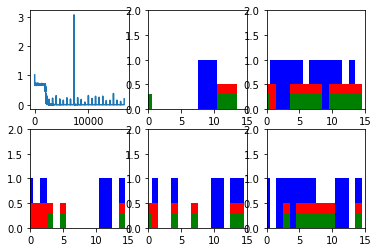

Step 100 Loss 0.0002558342
single_output_series: [0 1 1 1 1 1 0 0 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 0 0 1 1 0 0 0 1]

single_output_series: [1 1 0 1 1 0 1 0 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 0 0 1 1 0 0 1 1]

single_output_series: [0 1 1 0 0 0 0 1 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 0 0 0 1 0 0 1]

single_output_series: [0 1 1 0 0 0 1 1 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 1 1 0 0 0 0 1 0]

single_output_series: [1 1 1 0 1 0 0 1 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 1 0 1 1 0 1 1 0]



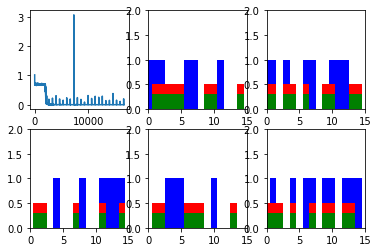

Step 200 Loss 0.00033256767
single_output_series: [0 0 1 1 1 0 0 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 1 1 1 1 0 0 0 1]

single_output_series: [0 1 0 1 0 1 0 1 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 1 1 1 0 0 1 1 0]

single_output_series: [0 1 1 1 0 0 1 0 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 0 1 0 0 1 1 0 1]

single_output_series: [0 0 1 0 0 0 1 0 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 0 0 1 0 1 1 0 0]

single_output_series: [0 1 0 1 0 1 0 1 1 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 1 1 0 0 0 0 1 0]



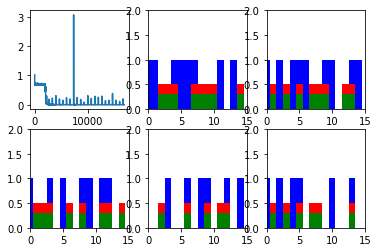

Step 300 Loss 0.00034063673
single_output_series: [0 0 1 1 1 1 0 1 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 1 0 0 0 1 0 0 1]

single_output_series: [0 1 0 1 1 0 0 1 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 1 0 1 0 1 1 0 1]

single_output_series: [1 0 0 1 0 0 0 0 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 0 0 0 0 0 1 0 0]

single_output_series: [0 1 1 0 1 1 1 1 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 1 0 0 0 0 1 0 1]

single_output_series: [1 1 1 0 1 0 0 1 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 1 1 1 0 0 0 1 0]



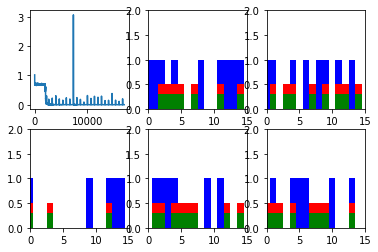

Step 400 Loss 0.0003301834
single_output_series: [1 1 0 0 1 1 0 1 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 0 0 0 1 0 1 1]

single_output_series: [1 0 0 1 1 1 0 1 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 0 1 0 1 0 0 0 0 1]

single_output_series: [0 1 1 0 0 1 0 1 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 1 0 1 1 0 1 0 1]

single_output_series: [1 0 0 0 0 1 1 1 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 1 0 1 0 0 1 0 0]

single_output_series: [0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]



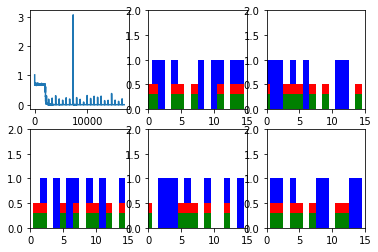

Step 500 Loss 0.000327913
single_output_series: [0 0 0 0 1 0 1 1 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 1 0 1 1 1 0 1 0 1 0 0]

single_output_series: [1 0 0 0 1 1 0 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 0 0 0 0 0 0 0 0]

single_output_series: [1 0 0 1 0 1 1 0 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 0 0 0 1 1 1 1 1]

single_output_series: [1 0 0 0 1 0 0 1 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 1 0 1 1 0 1 0 1]

single_output_series: [0 0 0 1 1 1 1 1 0 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 0 0 1 0 0 0 0]



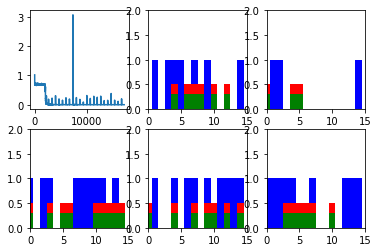

Step 600 Loss 0.0002889673
single_output_series: [0 1 0 1 1 1 1 0 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 0 1 0 1 1 1 0 0]

single_output_series: [0 0 1 1 1 1 0 0 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 0 0 1 1 0 1 0 1]

single_output_series: [0 1 1 1 1 0 1 0 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 0 0 1 1 0 0 0 1]

single_output_series: [0 0 1 1 1 0 0 1 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 1 1 0 1 1 1 0 0]

single_output_series: [1 1 0 0 1 1 0 1 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 0 1 1 1 0 1 0 0 0]



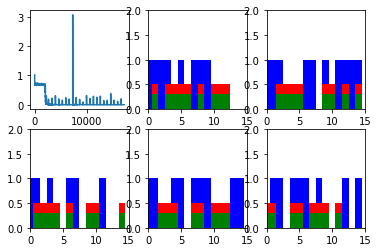

New data, epoch 26
Step 0 Loss 0.19251515
single_output_series: [0 0 0 1 0 1 0 0 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 1 0 1 1 1 0 0]

single_output_series: [1 0 0 0 1 0 0 1 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 1 1 0 0 1 0 0 0]

single_output_series: [1 0 0 0 0 1 1 1 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 1 0 0 1 0 0 1 0]

single_output_series: [1 0 0 0 0 0 0 0 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 0 0 1 0 1 1 0 1]

single_output_series: [0 0 0 1 0 0 1 0 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 0 0 0 0 1 1 1 1]



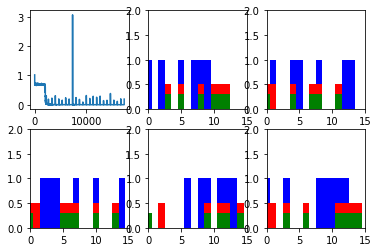

Step 100 Loss 0.00032135213
single_output_series: [0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 1 1 1 1 1 1 0]

single_output_series: [1 1 1 0 0 0 0 1 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 1 1 1 0 0 1 0]

single_output_series: [1 0 1 0 0 1 1 1 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 1 0 0 1 1 0 1 0]

single_output_series: [0 0 0 1 1 0 1 0 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 0 1 0 1 0 0 0 1]

single_output_series: [1 0 1 0 1 0 0 0 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 0 0 1 1 1 1 0 1]



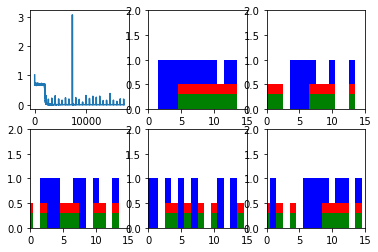

Step 200 Loss 0.00034995656
single_output_series: [0 0 0 1 1 1 0 1 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 1 1 1 1 0 1 1 0]

single_output_series: [1 1 1 1 1 0 1 1 1 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 1 1 1 0 0 1 1 1 1]

single_output_series: [1 1 0 1 0 1 0 0 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 0 0 0 1 0 1 0 1]

single_output_series: [1 0 1 1 1 0 1 1 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 1 1 0 1 0 0 0]

single_output_series: [0 1 0 0 1 0 1 0 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 0 1 0 0 0 1 0 0]



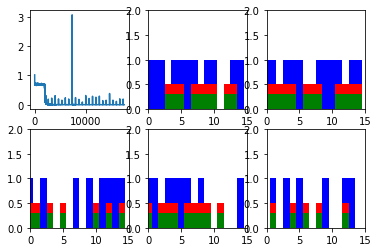

Step 300 Loss 0.00023988451
single_output_series: [0 1 0 1 1 1 1 1 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 1 1 1 1 0 1 0 0 1]

single_output_series: [1 0 0 0 1 1 1 0 0 1 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 0 0 1 0 0 1 1 0]

single_output_series: [1 1 0 1 0 0 0 1 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 1 1 1 0 0 0 1 0]

single_output_series: [0 0 1 1 0 1 1 1 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 1 1 0 1 1 0 0 1 1]

single_output_series: [1 0 0 0 0 1 1 1 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 1 0 1 0 0 0 1 1]



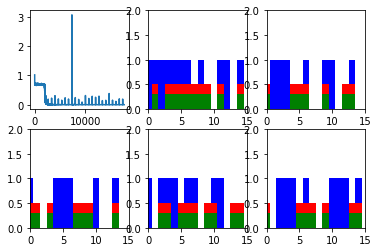

Step 400 Loss 0.00027108993
single_output_series: [0 0 1 1 1 0 0 1 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 1 0 1 1 1 1 1 1]

single_output_series: [1 0 1 1 0 0 0 1 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 1 1 1 0 0 0 1 0]

single_output_series: [1 0 1 0 0 0 1 1 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 1 0 1 1 1 0 1 0]

single_output_series: [0 1 0 0 1 1 1 0 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 1 0 1 0 0 1 1 0 1]

single_output_series: [0 0 1 1 1 1 0 1 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 1 1 0 0 1 0 0 0]



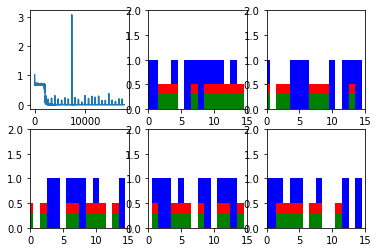

Step 500 Loss 0.00034355992
single_output_series: [1 0 1 0 1 0 0 1 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 1 1 1 1 1 1 1 0]

single_output_series: [1 0 0 1 0 0 0 1 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 1 1 0 1 0 1 1 1]

single_output_series: [1 0 1 1 1 0 1 1 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 0 1 1 1 1 0 1]

single_output_series: [0 1 0 0 0 1 0 1 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 1 0 1 0 0 0 0 0]

single_output_series: [1 0 1 1 0 1 0 1 1 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 1 1 1 0 1 0 0 0]



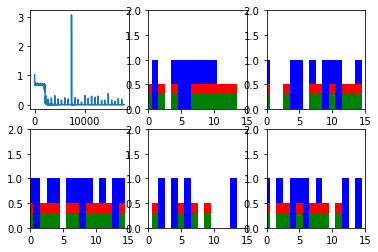

Step 600 Loss 0.00025999633
single_output_series: [1 0 0 1 0 1 0 1 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 0 0 1 0 0 1 0]

single_output_series: [1 1 1 1 1 1 1 0 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 0 0 0 0 1 0 1 1]

single_output_series: [0 1 1 0 0 0 0 0 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 0 1 1 0 0 0 1 0]

single_output_series: [0 1 0 0 0 0 1 0 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 0 1 1 0 1 0 1 1]

single_output_series: [0 0 0 1 1 1 0 0 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 0 1 1 0 0 1 1 1]



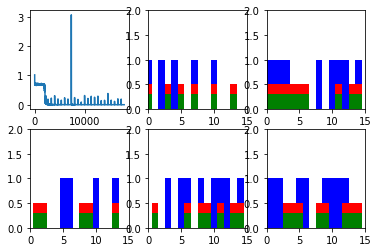

New data, epoch 27
Step 0 Loss 0.17112848
single_output_series: [1 0 1 0 1 1 0 1 0 0 0 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 0 1 0 0 0 0 0 1 0]

single_output_series: [0 1 0 1 0 0 1 1 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 1 0 1 1 0 0 1 1]

single_output_series: [1 0 0 0 0 0 0 0 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 0 1 1 1 1 1 0 1]

single_output_series: [0 0 0 1 1 1 0 0 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 0 1 0 0 0 1 0 0]

single_output_series: [0 0 0 1 1 1 0 1 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 1 0 1 1 1 1 1 0 0 0]



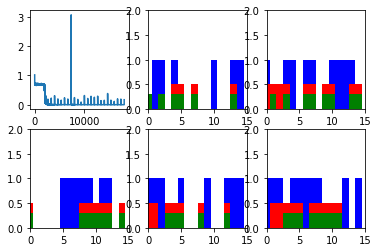

Step 100 Loss 0.00037353465
single_output_series: [0 1 0 1 0 1 0 1 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 1 0 1 1 1 1 0 1]

single_output_series: [1 1 0 1 0 0 0 1 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 1 0 0 0 1 0 0 0]

single_output_series: [0 0 0 1 0 0 1 0 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 0 0 0 1 0 1 0 1]

single_output_series: [1 0 1 1 0 0 1 0 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 0 1 1 0 1 0 1 0]

single_output_series: [0 0 1 0 0 0 0 0 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 0 0 1 0 1 0 1 1]



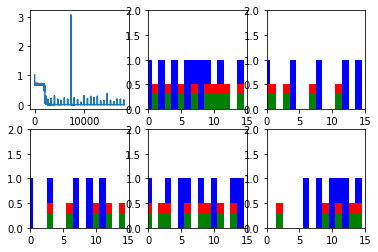

Step 200 Loss 0.0002573516
single_output_series: [0 1 1 1 0 1 1 0 0 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 0 0 0 1 0 0 0 0]

single_output_series: [0 0 1 1 0 0 0 0 0 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 0 0 0 1 0 0 0 0]

single_output_series: [1 0 0 1 1 0 0 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 0 1 0 1 0 1 1 1]

single_output_series: [0 0 0 1 1 0 1 1 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 0 0 0 1 1 0 0]

single_output_series: [1 1 1 0 0 0 1 1 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 1 1 0 0 0 0 1 1 1]



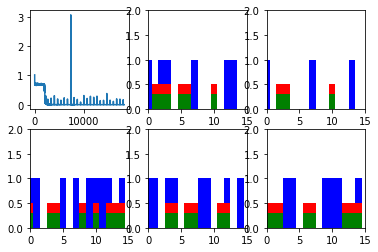

Step 300 Loss 0.00032190993
single_output_series: [1 0 0 0 1 0 0 0 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 0 1 0 0 0 0 1 1]

single_output_series: [0 1 0 1 1 1 0 1 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 1 0 0 0 1 1 0 1]

single_output_series: [1 1 0 1 0 1 1 0 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 0 0 0 1 1 0 0 0]

single_output_series: [1 0 0 0 0 0 0 0 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 0 1 1 0 0 0 1 1]

single_output_series: [1 1 1 0 0 1 1 1 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 1 1 0 0 1 0 1 0]



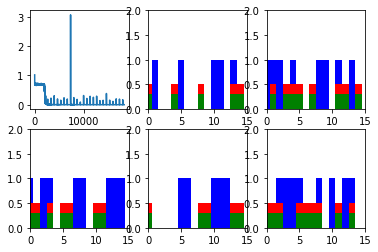

Step 400 Loss 0.00026170578
single_output_series: [0 1 0 0 0 1 0 0 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 0 1 1 0 0 0 0 0]

single_output_series: [1 1 0 0 0 1 0 0 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 0 1 0 1 1 0 1 1]

single_output_series: [1 0 1 1 1 0 1 1 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 1 0 1 0 1 0 0]

single_output_series: [1 0 1 1 1 0 0 0 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 0 1 0 0 0 1 1 1]

single_output_series: [1 1 0 0 0 0 0 0 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 0 0 1 0 0 0 0 0]



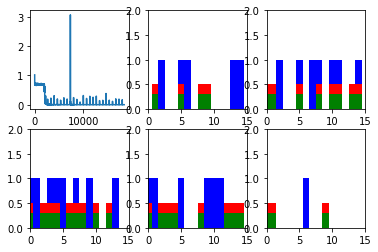

Step 500 Loss 0.0003106143
single_output_series: [0 1 1 1 0 0 1 1 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 1 0 1 1 0 0 0 0]

single_output_series: [0 1 1 1 1 0 0 0 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 0 0 0 0 0 1 1 0]

single_output_series: [0 1 0 1 0 1 1 0 0 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 0 0 0 0 0 1 0 1]

single_output_series: [1 1 0 0 0 1 0 1 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 1 0 1 0 1 0 1 1]

single_output_series: [1 0 1 0 0 1 1 1 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 1 1 0 0 0 1 1 0]



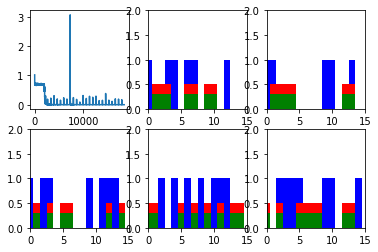

Step 600 Loss 0.00029967196
single_output_series: [1 0 1 1 0 0 0 1 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 1 1 0 1 1 1 0 1]

single_output_series: [1 1 1 1 0 0 1 1 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 1 0 0 1 0 1 0 1]

single_output_series: [1 1 0 0 0 1 1 1 1 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 1 1 0 1 1 1 0 1]

single_output_series: [1 0 1 0 1 0 0 0 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 0 0 0 0 1 1 1 1 0 0]

single_output_series: [1 1 1 0 1 1 1 1 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 1 1 1 0 0 0 1 0]



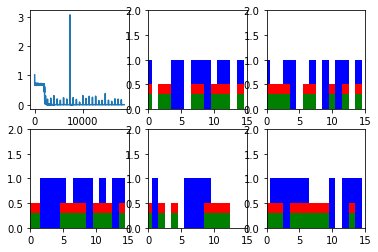

New data, epoch 28
Step 0 Loss 0.29834878
single_output_series: [1 1 1 1 1 1 1 0 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 0 1 1 1 0 1 0 1]

single_output_series: [1 1 1 1 1 0 1 1 0 0 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 0 0 0 0 0 1 0]

single_output_series: [1 0 1 0 0 0 0 1 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 0 1 0 1 1 1 1]

single_output_series: [1 0 1 0 1 0 0 1 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 1 1 1 0 1 0 0]

single_output_series: [1 1 1 1 0 1 0 0 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 0 0 1 0 1 0 0]



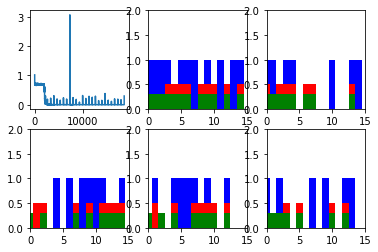

Step 100 Loss 0.00033042263
single_output_series: [0 1 1 0 0 1 1 1 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 1 1 1 0 1 1 0 0]

single_output_series: [0 1 1 0 0 0 0 1 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 1 1 1 0 1 0 1 0]

single_output_series: [1 0 1 1 0 1 0 1 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 1 0 1 0 0 0 1 0]

single_output_series: [1 1 1 1 0 0 0 0 1 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 0 1 0 0 0 0 0 1]

single_output_series: [1 0 0 0 0 1 1 1 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 1 0 0 0 1 0 1 0]



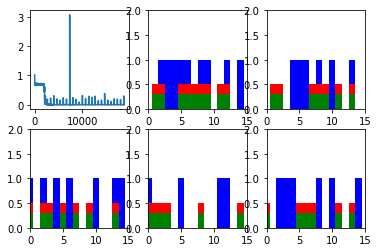

Step 200 Loss 0.00023490348
single_output_series: [0 1 0 0 1 1 0 1 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 1 1 1 1 1 1 0 1]

single_output_series: [1 1 1 1 0 0 1 0 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 0 1 1 0 0 1 0 1]

single_output_series: [0 1 0 1 1 0 1 1 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 1 0 0 1 1 1 1 0]

single_output_series: [0 0 0 1 0 0 1 1 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 1 1 0 1 0 0 0 0 1]

single_output_series: [1 0 0 0 1 0 0 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 1 1 1 1 1 1 1 1]



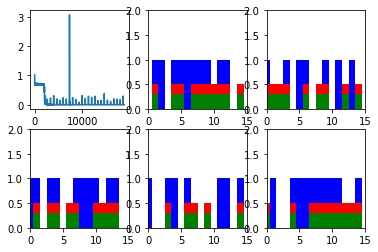

Step 300 Loss 0.00025814623
single_output_series: [0 0 1 1 0 1 0 0 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 0 1 1 0 1 1 0 1]

single_output_series: [1 1 0 1 1 0 1 1 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 1 0 0 1 0 1 0]

single_output_series: [0 0 1 0 1 1 0 0 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 0 0 0 0 1 0 1 1]

single_output_series: [1 0 1 1 1 1 1 0 1 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 0 1 0 0 0 0 0 1]

single_output_series: [1 1 0 1 1 1 0 1 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 1 1 1 0 1 1 1 1]



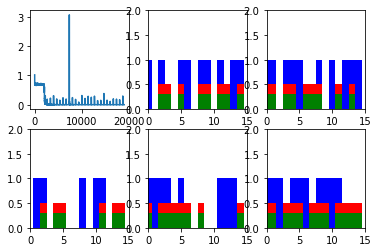

Step 400 Loss 0.0004724307
single_output_series: [0 0 1 0 1 0 1 0 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 1 0 0 1 0 1 0]

single_output_series: [1 0 0 1 1 0 0 1 0 1 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 1 0 1 0 0 0 0 0]

single_output_series: [1 0 1 1 1 1 0 1 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 0 1 0 1 0 1 0 1 0]

single_output_series: [1 0 0 0 0 1 1 0 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 0 1 0 1 1 1 1 0]

single_output_series: [1 1 1 1 1 0 0 1 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 1 1 1 0 1 1 0 1]



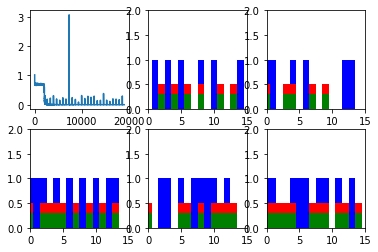

Step 500 Loss 0.00025558603
single_output_series: [0 0 1 0 1 0 1 0 1 1 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 1 1 0 0 1 1 0]

single_output_series: [1 1 0 0 0 1 1 0 1 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 0 1 1 1 1 0 0 0]

single_output_series: [1 1 0 0 1 0 1 1 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 1 0 0 1 0 1 1]

single_output_series: [0 1 1 0 0 1 0 0 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 0 0 0 0 0 0 1 0 0]

single_output_series: [0 0 0 1 1 0 1 1 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 1 0 0 1 0 1 1]



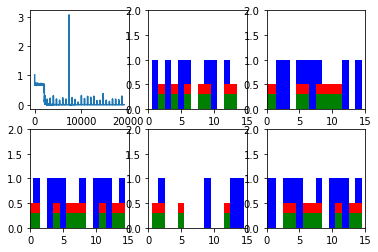

Step 600 Loss 0.00033876914
single_output_series: [0 0 1 0 1 1 1 1 0 1 0 1 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 1 0 1 0 1 0 0 1]

single_output_series: [0 0 1 0 0 0 1 1 1 1 0 1 1 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 1 1 1 0 1 1 0 1]

single_output_series: [1 1 1 1 1 1 1 0 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 0 0 0 0 0 0 1 1]

single_output_series: [1 1 0 0 0 0 0 0 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 0 0 1 1 0 0 0 0]

single_output_series: [1 0 1 1 1 0 1 0 0 1 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 0 0 1 0 0 1 1 1]



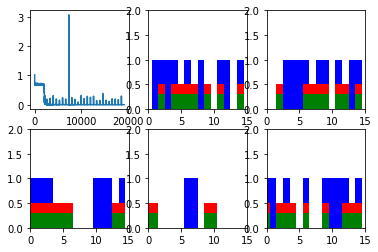

New data, epoch 29
Step 0 Loss 0.25354826
single_output_series: [1 0 0 0 1 1 1 1 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 0 1 0 0 1 0 1]

single_output_series: [0 0 0 1 1 0 0 1 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 1 0 1 1 1 0 1 1]

single_output_series: [0 0 0 1 0 1 1 1 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 1 0 1 1 1 0 0]

single_output_series: [1 0 0 0 0 0 0 1 1 1 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 1 1 1 1 0 0 1 1]

single_output_series: [0 0 0 1 0 0 1 0 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 0 0 0 0 1 0 1 0]



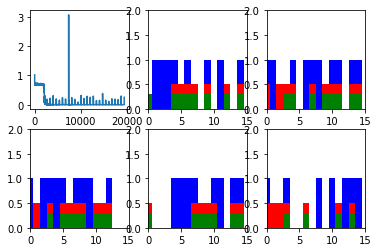

Step 100 Loss 0.00029872684
single_output_series: [0 1 0 1 0 1 1 1 1 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 1 0 0 1 0 0 1]

single_output_series: [0 1 0 0 0 0 0 0 0 0 1 0 1 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 0 0 0 1 0 1 1 0]

single_output_series: [1 0 1 1 0 1 0 1 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 1 0 0 0 1 1 0 1]

single_output_series: [0 1 1 1 0 1 0 1 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 1 0 1 1 0 1 1 0]

single_output_series: [1 1 0 1 0 1 0 0 0 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 0 0 0 1 1 0 1 0]



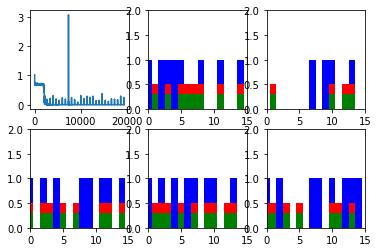

Step 200 Loss 0.00025387452
single_output_series: [1 0 1 0 0 1 1 0 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 0 0 1 0 1 0 1 0]

single_output_series: [0 0 0 1 1 1 1 0 0 1 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 0 0 1 1 0 1 1 1]

single_output_series: [1 0 1 0 1 1 0 0 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 0 1 1 0 1 1 1 1]

single_output_series: [1 1 1 1 0 0 0 1 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 0 0 1 1 0 0 0]

single_output_series: [1 0 1 1 1 0 1 0 0 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 0 0 1 1 1 1 1 0]



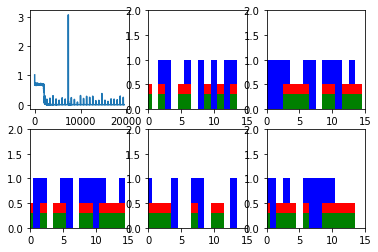

Step 300 Loss 0.00024304447
single_output_series: [1 1 1 1 0 0 1 1 1 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 1 1 1 1 1 0 0 0 1]

single_output_series: [0 1 1 0 0 1 1 1 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 1 1 1 0 0 0 0 1]

single_output_series: [0 0 0 0 0 0 1 0 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 1 1 1 0 1 1 0]

single_output_series: [1 1 0 1 0 1 1 1 1 0 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 1 1 1 0 1 0 1 1 0]

single_output_series: [1 0 0 1 1 0 0 0 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 0 1 1 0 0 0 1 0]



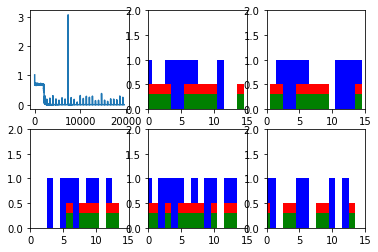

Step 400 Loss 0.00021840997
single_output_series: [0 1 0 0 1 0 0 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 0 1 0 1 0 1 1 1]

single_output_series: [1 1 0 1 1 0 1 1 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 0 0 1 1 0 1 1]

single_output_series: [1 1 0 1 0 0 1 1 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 1 1 1 0 1 1 0 0]

single_output_series: [0 1 1 0 0 0 1 0 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 0 0 1 0 1 1 1 1]

single_output_series: [0 0 1 0 0 0 1 0 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 0 0 1 0 1 1 1 1]



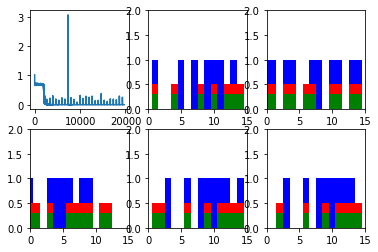

Step 500 Loss 0.0002534487
single_output_series: [1 0 0 1 1 1 1 1 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 1 0 1 1 0 0 0 1]

single_output_series: [0 1 0 0 1 1 0 0 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 0 1 0 1 0 1 0 0]

single_output_series: [0 1 0 1 1 0 1 0 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 1 0 1 0 1 0 0 1 0]

single_output_series: [1 0 0 1 0 0 0 1 0 1 0 1 1 1 1]
batchY[batch_series_idx, :] [1 0 0 1 0 0 0 1 0 1 0 1 1 1 1]

single_output_series: [1 1 0 0 0 1 1 0 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 0 0 0 0 0 1 1 0]



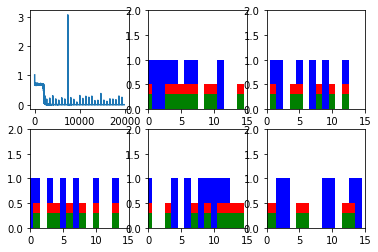

Step 600 Loss 0.00023483319
single_output_series: [1 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 1 0 0 0 0 0 0 0]

single_output_series: [0 1 0 0 1 0 0 0 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 0 1 0 0 1 0 0 0]

single_output_series: [1 1 0 1 1 0 1 0 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 0 1 1 1 0 1 1 0]

single_output_series: [0 1 0 0 0 1 0 1 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 1 0 0 0 0 0 0 0]

single_output_series: [1 0 1 0 1 1 0 0 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 0 0 1 1 0 0 1 0]



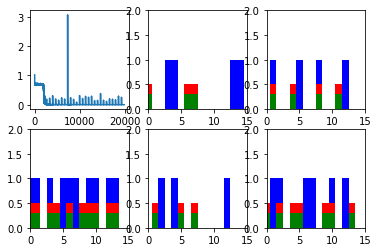

New data, epoch 30
Step 0 Loss 0.16231598
single_output_series: [1 0 0 0 0 0 1 0 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 0 1 0 1 0 1 0]

single_output_series: [0 1 0 1 1 1 1 0 0 0 1 0 0 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 1 0 0 0 1 0 0 1 1]

single_output_series: [0 1 0 1 0 0 1 0 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 0 0 1 0 0 0 0 1]

single_output_series: [0 1 0 1 1 1 1 1 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 1 1 1 0 1 0 0 0 1 0]

single_output_series: [0 1 0 1 1 1 1 1 1 1 0 0 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 1 1 0 0 0 1 0]



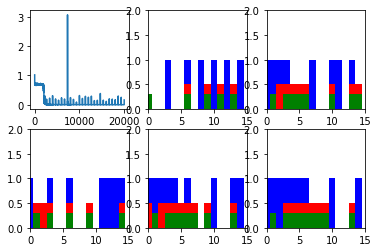

Step 100 Loss 0.0003188348
single_output_series: [1 0 1 1 1 0 0 1 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 1 0 1 0 0 1 0 0]

single_output_series: [0 1 1 0 1 0 1 1 0 0 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 1 0 0 0 1 0 1 0]

single_output_series: [1 1 1 0 1 1 1 0 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 0 0 0 0 1 0 0 0]

single_output_series: [1 0 0 1 0 1 0 1 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 0 0 1 1 1 0 1]

single_output_series: [0 1 1 0 0 1 1 0 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 0 0 1 1 0 0 0 0]



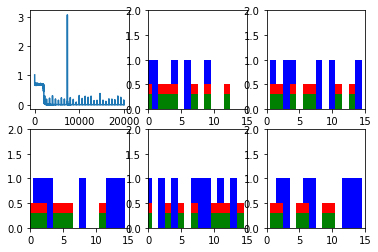

Step 200 Loss 0.00033405714
single_output_series: [1 1 0 1 1 0 0 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 0 1 0 1 0 1 1 0 0]

single_output_series: [1 0 1 0 1 1 0 0 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 0 1 0 1 0 0 1 1]

single_output_series: [1 0 0 1 0 1 1 1 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 1 1 1 1 1 0 1 0]

single_output_series: [0 1 0 1 0 0 1 1 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 0 1 1 1 0 0 1 0 1 0]

single_output_series: [0 0 1 1 1 1 0 0 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 0 1 1 1 0 1 0 1]



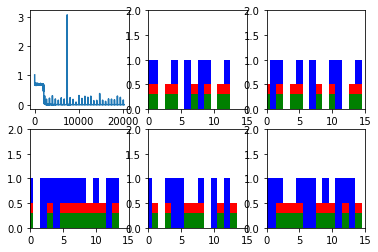

Step 300 Loss 0.000327606
single_output_series: [1 0 1 0 1 1 1 0 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 0 0 0 1 0 1 0 1]

single_output_series: [1 0 1 0 0 0 0 0 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 0 1 0 0 0 1 1 1]

single_output_series: [1 0 1 1 1 0 1 0 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 0 0 0 0 1 1 0 1]

single_output_series: [1 1 0 0 1 1 1 0 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 0 1 0 0 0 1 1 0]

single_output_series: [0 0 0 0 0 1 0 1 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 1 0 0 1 0 1 1]



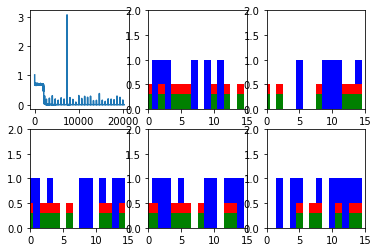

Step 400 Loss 0.00031243745
single_output_series: [1 0 0 0 1 0 0 0 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 0 1 1 0 1 0 0 1]

single_output_series: [0 0 1 1 0 0 1 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 1 0 1 0 1 0 0 0 0]

single_output_series: [0 1 0 1 1 1 0 1 1 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 1 1 0 1 1 1 0 0]

single_output_series: [1 0 1 0 0 0 0 0 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 0 0 0 1 0 1 0 0]

single_output_series: [0 0 1 0 1 0 0 0 0 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 0 0 0 1 1 1 1 0]



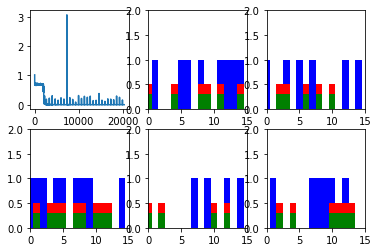

Step 500 Loss 0.00028437361
single_output_series: [1 1 1 0 1 0 1 0 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 0 0 1 1 0 0 1 0]

single_output_series: [0 0 0 0 0 1 0 0 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 0 0 1 0 0 0 0 1]

single_output_series: [1 1 1 1 1 1 1 1 0 1 0 0 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 1 0 1 0 0 0 1 1]

single_output_series: [1 0 1 0 0 0 0 0 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 0 0 0 0 1 1 0 1]

single_output_series: [1 0 0 1 0 1 0 1 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 0 1 1 1 1 1 0 1 0]



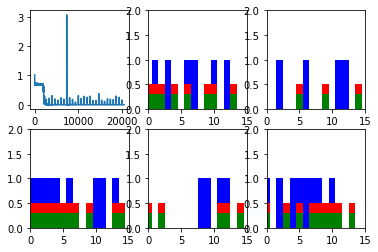

Step 600 Loss 0.00032810372
single_output_series: [1 1 0 0 0 0 0 0 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 0 0 1 0 1 0 0 0]

single_output_series: [1 0 0 0 1 1 1 0 0 0 0 0 0 0 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 0 0 0 0 0 0 0 0]

single_output_series: [0 0 0 0 1 1 1 1 0 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 0 0 0 0 1 1 0]

single_output_series: [0 0 1 0 0 0 1 1 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 1 1 0 1 0 1 0 0]

single_output_series: [1 1 1 1 1 1 1 0 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 1 0 1 0 1 0 0 0 1]



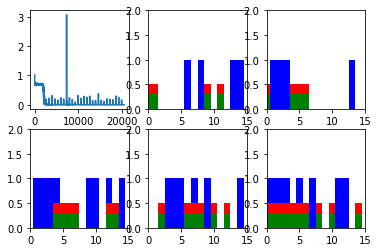

New data, epoch 31
Step 0 Loss 0.27777028
single_output_series: [1 0 1 0 0 1 1 0 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 1 0 0 0 0 1 1]

single_output_series: [1 0 1 1 0 0 1 1 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 1 0 1 1 0 0 0 0]

single_output_series: [1 0 1 1 1 0 0 0 1 1 1 1 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 0 0 0 1 1 1 1 0 1 1]

single_output_series: [1 0 1 0 0 1 1 0 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 0 0 1 0 0 0 0 1]

single_output_series: [1 0 1 0 1 1 0 1 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 0 1 1 1 1 0 1 1 0]



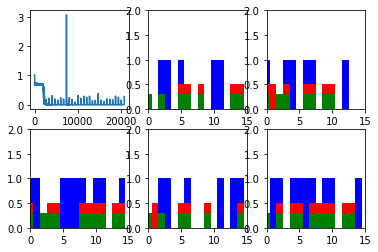

Step 100 Loss 0.0002797455
single_output_series: [1 0 0 1 0 1 1 1 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 1 1 0 0 1 1 0 1]

single_output_series: [0 1 1 1 0 0 1 0 1 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 0 1 0 1 1 0 1 0 1 0]

single_output_series: [1 0 0 0 0 0 0 1 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 0 1 0 1 1 1 1 0 1]

single_output_series: [0 0 0 1 1 0 0 1 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 1 0 1 0 1 0 1]

single_output_series: [0 0 0 0 0 1 0 1 0 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 0 1 1 0 1 1 0]



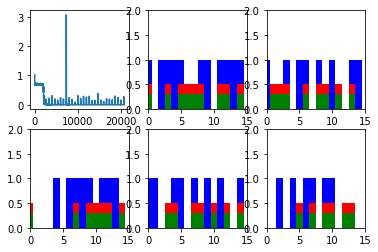

Step 200 Loss 0.00025839818
single_output_series: [1 1 1 1 1 1 0 1 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 1 0 1 0 0 1 0 1 0 1]

single_output_series: [1 1 0 0 1 0 0 0 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 0 0 0 1 1 1 1 1]

single_output_series: [0 0 1 1 1 1 0 1 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 1 0 0 1 1 0 1 1]

single_output_series: [0 1 1 1 1 0 1 0 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 0 0 0 1 0 1 0 1]

single_output_series: [0 0 0 0 0 1 1 1 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 1 1 0 0 0 0 0]



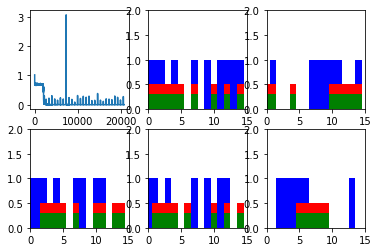

Step 300 Loss 0.00023174268
single_output_series: [1 0 1 1 0 1 1 1 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 1 0 1 0 0 1 0 1]

single_output_series: [1 0 1 0 0 1 0 1 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 1 1 1 1 0 1 0]

single_output_series: [0 1 1 0 1 1 1 0 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 0 0 1 1 0 0 0 0]

single_output_series: [1 1 1 0 0 0 0 0 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 0 1 0 1 1 1 1 0]

single_output_series: [1 1 1 1 1 0 0 1 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 1 1 0 0 1 1 0 0]



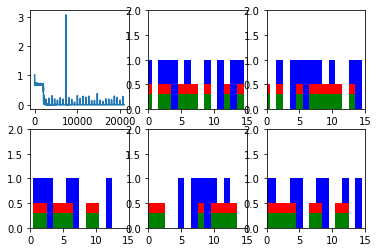

Step 400 Loss 0.00027042962
single_output_series: [0 0 1 0 1 0 1 1 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 1 0 0 1 0 0 1 0]

single_output_series: [0 1 0 1 0 0 0 1 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 1 0 1 1 0 0 0 1]

single_output_series: [0 1 0 0 1 0 1 1 1 0 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 0 0 1 0 1 1 1 0 1 0 1 0 0]

single_output_series: [0 0 0 1 1 1 0 0 1 1 0 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 0 0 1 1 0 0 0 0 0]

single_output_series: [1 0 0 0 1 1 0 1 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 1 0 1 1 0 1 1 1 1 0]



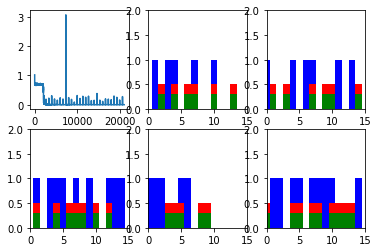

Step 500 Loss 0.00020251182
single_output_series: [0 0 1 1 1 0 0 0 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 0 0 1 1 0 1 0 0]

single_output_series: [0 0 1 0 1 1 1 0 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 0 0 0 0 1 0 0 0]

single_output_series: [1 0 1 0 0 1 1 1 1 0 0 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 1 1 1 0 0 0 0 0 1]

single_output_series: [1 1 0 1 1 0 1 1 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 1 1 1 0 1 1 0]

single_output_series: [0 0 1 0 0 1 0 0 1 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 0 1 1 1 0 0 1 1]



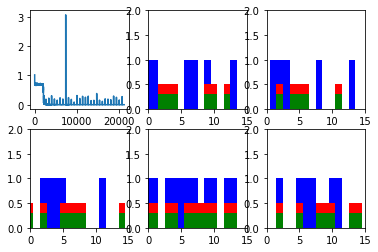

Step 600 Loss 0.00021982164
single_output_series: [1 0 1 1 0 0 1 1 0 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 1 0 0 1 1 1 1 1]

single_output_series: [1 1 1 0 1 0 0 0 1 1 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 0 1 1 1 0 0 1 0]

single_output_series: [1 0 0 0 1 0 0 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 1 0 0 0 1 1 1 0]

single_output_series: [0 1 1 1 1 0 0 1 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 1 1 0 0 1 0 1 1]

single_output_series: [1 1 0 0 1 0 1 1 0 1 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 1 0 1 0 1 0 0 0]



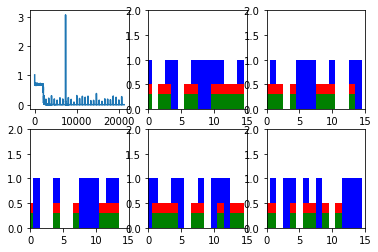

New data, epoch 32
Step 0 Loss 0.09627183
single_output_series: [1 0 0 0 0 0 0 0 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 0 1 0 0 0 1 1 1]

single_output_series: [1 0 0 0 1 1 1 1 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 1 1 1 0 1 1 1 0]

single_output_series: [1 0 0 0 0 1 1 0 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 1 1 0 1 1 1 0]

single_output_series: [0 0 0 1 1 1 0 0 0 0 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 0 0 0 1 0 0 1 1]

single_output_series: [0 0 0 1 0 0 0 1 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 1 1 0 0 0 1 0 1]



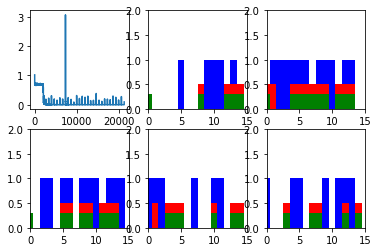

Step 100 Loss 0.00023113121
single_output_series: [1 0 1 1 1 0 0 0 0 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 0 0 0 1 0 1 0 0 1]

single_output_series: [0 0 1 1 1 0 0 1 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 1 1 0 0 0 1 1 0]

single_output_series: [0 0 0 0 0 1 0 0 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 0 0 0 1 1 0 0 0]

single_output_series: [1 0 1 0 1 1 1 0 0 0 1 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 0 0 0 1 0 1 0 0]

single_output_series: [1 1 0 0 1 1 1 1 1 0 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 1 1 0 1 1 1 1 1]



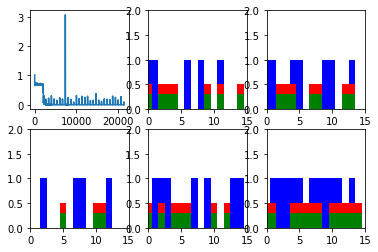

Step 200 Loss 0.00023584835
single_output_series: [1 0 1 1 0 1 1 1 0 0 0 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 1 0 0 0 1 1 1 1]

single_output_series: [0 1 0 1 1 1 0 1 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 1 0 1 1 1 0 1 0 1 1]

single_output_series: [0 0 0 0 0 1 0 1 1 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 0 1 1 0 0 0 0 0 1]

single_output_series: [1 1 0 0 0 1 0 1 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 1 1 1 1 0 1 1 1]

single_output_series: [1 0 1 1 0 0 0 0 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 0 1 0 1 1 0 1 0]



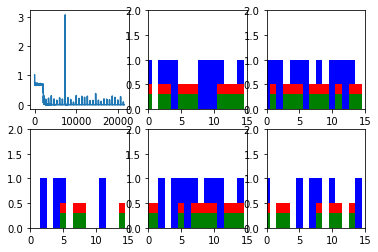

Step 300 Loss 0.00021570908
single_output_series: [1 1 0 1 0 0 1 1 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 1 1 0 0 0 1 1 0]

single_output_series: [0 0 0 0 0 1 1 0 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 0 0 0 1 0 0 0]

single_output_series: [1 0 1 0 0 0 0 1 1 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 1 1 0 0 0 1 1 1]

single_output_series: [0 1 0 0 1 0 0 1 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 0 0 1 0 0 0 0 0 0 1]

single_output_series: [0 1 0 1 0 1 0 1 1 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 1 1 0 0 1 1 0 1]



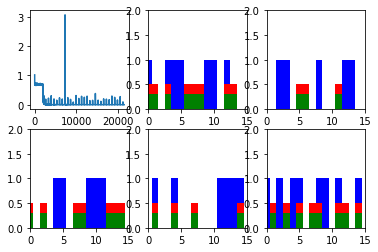

Step 400 Loss 0.00022931864
single_output_series: [0 1 1 0 0 1 1 0 0 0 0 1 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 0 0 0 0 1 0 0 1]

single_output_series: [0 0 0 0 1 1 1 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 0 0 0 1 1 1 0]

single_output_series: [0 0 0 1 1 0 0 1 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 0 1 0 1 0 1 0]

single_output_series: [0 1 0 1 1 0 0 0 1 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 0 1 1 0 1 1 0 0]

single_output_series: [0 1 0 1 0 1 1 1 1 1 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 1 1 0 0 0 0 1]



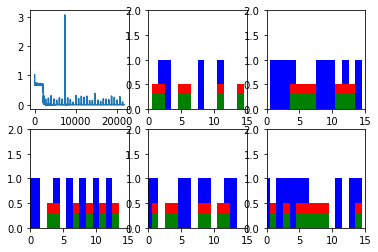

Step 500 Loss 0.00022457614
single_output_series: [0 1 0 1 0 1 0 1 1 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 0 1 1 0 1 0 0 1 0]

single_output_series: [1 1 1 1 0 0 0 0 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 0 0 1 0 1 1 0 0]

single_output_series: [0 0 1 0 1 0 1 0 0 1 1 0 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 0 1 1 0 0 1 1]

single_output_series: [0 1 0 0 0 1 1 0 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 1 0 0 0 1 1 0 0 1 1 0 0 0 0]

single_output_series: [1 0 1 1 0 1 0 1 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 1 1 1 1 1 1 0 1]



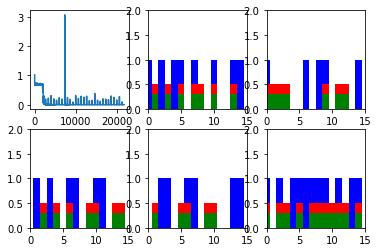

Step 600 Loss 0.0002177429
single_output_series: [0 1 1 0 1 1 0 1 0 0 0 1 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 1 0 0 0 1 1 1 0]

single_output_series: [1 0 0 0 1 0 1 0 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 0 0 1 0 1 0 1 1 1 1 1 1 0]

single_output_series: [0 0 0 1 1 1 1 1 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 1 1 1 1 1 1 0 0 1 1 0 0]

single_output_series: [0 1 0 1 0 1 1 1 1 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 0 1 0 1 1 1 1 1 1 1 1 0 0]

single_output_series: [1 1 1 1 0 0 0 0 0 1 1 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 0 0 1 1 1 0 1 1]



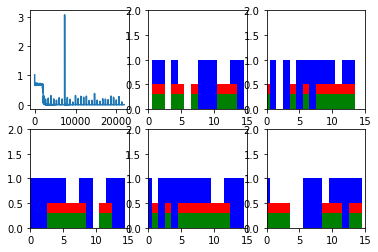

New data, epoch 33
Step 0 Loss 0.16484395
single_output_series: [0 1 0 1 1 0 0 1 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 1 1 1 1 1 0 1 0]

single_output_series: [0 1 0 1 1 1 1 0 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 0 0 1 1 1 0 1 0]

single_output_series: [0 0 0 0 1 0 0 0 1 0 1 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 0 1 0 1 0 0 1 1]

single_output_series: [0 1 0 1 1 1 1 1 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 1 1 0 0 0 0 1 1]

single_output_series: [0 1 0 1 1 0 1 0 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 0 1 1 0 1 0 1 0 1 1 0 1 0]



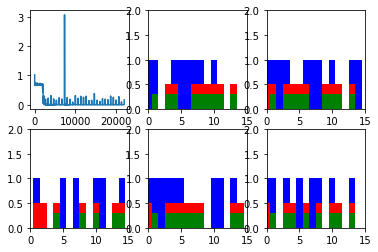

Step 100 Loss 0.00018520768
single_output_series: [1 0 1 1 1 0 1 0 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 0 0 1 1 0 0 0 1]

single_output_series: [0 1 1 0 1 0 1 1 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 1 1 0 0 0 1 1 0 1]

single_output_series: [1 1 1 0 0 1 0 1 1 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 1 0 1 1 0 0 1 1 0 0]

single_output_series: [0 1 1 0 0 0 0 0 1 0 0 1 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 0 1 0 0 1 0 1 1]

single_output_series: [1 0 1 1 0 0 0 0 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 0 0 0 1 1 1 0 0 0]



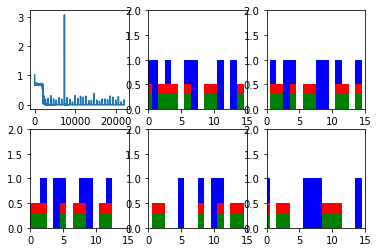

Step 200 Loss 0.00023378941
single_output_series: [0 1 1 0 0 0 1 1 0 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 0 1 1 0 0 1 0 1 0 1]

single_output_series: [1 1 0 1 0 1 0 0 0 1 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 0 1 0 1 0 0 0 1 1 1 0 0 0]

single_output_series: [0 1 1 1 0 0 0 0 1 1 0 0 1 0 1]
batchY[batch_series_idx, :] [0 1 1 1 0 0 0 0 1 1 0 0 1 0 1]

single_output_series: [0 0 0 1 1 0 1 0 1 0 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 0 1 0 1 1 0 1 1]

single_output_series: [1 1 0 0 1 1 1 1 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 1 1 1 0 1 1 1 1 0 1]



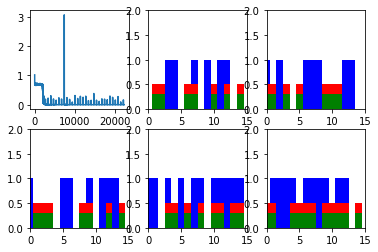

Step 300 Loss 0.00018131359
single_output_series: [0 0 1 0 1 0 0 0 0 0 1 0 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 0 0 0 1 0 0 1 1]

single_output_series: [1 1 1 1 0 1 1 1 0 0 1 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 1 0 1 1 1 0 0 1 1 0 0 0]

single_output_series: [1 0 0 1 0 0 1 0 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 0 1 0 0 1 1 1 1 0 0]

single_output_series: [1 0 0 1 1 1 1 0 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 1 1 1 1 0 1 1 1 1 0 0 1]

single_output_series: [0 1 1 1 0 1 1 0 1 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 1 0 1 1 1 0 1 0 0]



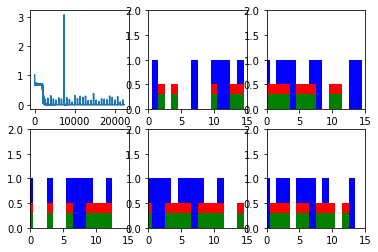

Step 400 Loss 0.00025483247
single_output_series: [0 0 0 0 1 0 0 1 0 1 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 1 0 1 1 0 1 0 1]

single_output_series: [0 0 0 1 0 1 1 1 1 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 1 1 1 1 1 1 0 1]

single_output_series: [1 1 0 0 1 0 0 0 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 0 0 1 1 0 1 0 0 1]

single_output_series: [1 0 1 0 0 1 0 1 0 1 0 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 0 0 1 0 1 0 1 0 1 1 0 1]

single_output_series: [0 1 1 1 1 0 0 1 0 1 0 0 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 0 1 0 1 0 0 1 0 0]



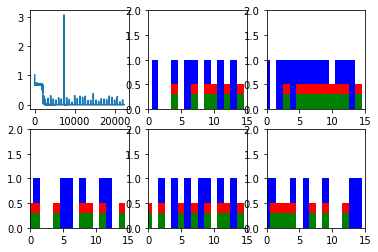

Step 500 Loss 0.0002187816
single_output_series: [1 1 1 0 1 1 1 1 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 1 0 0 1 0 1 1 1]

single_output_series: [1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]

single_output_series: [0 1 1 0 1 1 0 1 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 0 1 0 1 1 1 1 0 1]

single_output_series: [0 1 1 0 1 1 1 0 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 0 1 0 0 0 0 1 1]

single_output_series: [0 1 1 0 1 0 0 0 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 0 1 0 1 0 1 1 1]



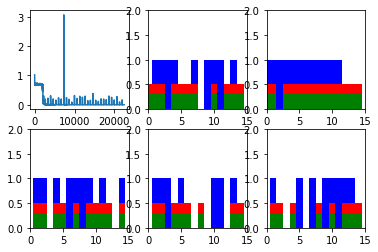

Step 600 Loss 0.00015045417
single_output_series: [0 1 1 0 1 1 1 1 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 1 1 1 0 1 1 0 0 0 1]

single_output_series: [1 0 1 1 1 0 1 1 1 1 1 1 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 1 1 1 1 1 1 1 0]

single_output_series: [0 0 1 0 1 1 1 1 0 0 1 1 0 1 1]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 1 0 0 1 1 0 1 1]

single_output_series: [1 1 0 1 0 0 1 1 0 0 1 0 0 1 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 1 1 0 0 1 0 0 1 1]

single_output_series: [1 0 0 1 0 1 1 0 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 0 1 0 1 1 0 0 0 0 0 1 0 0]



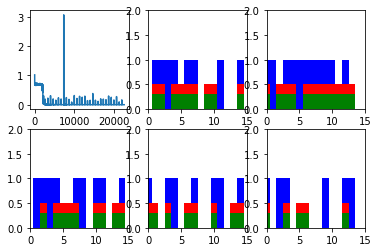

New data, epoch 34
Step 0 Loss 0.18607298
single_output_series: [0 1 0 1 0 0 0 0 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 1 0 0 0 0 0 0 1 0 0 0 1]

single_output_series: [0 1 0 1 0 1 0 1 1 0 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 1 1 0 0 0 1 0 0]

single_output_series: [0 1 0 1 0 0 0 1 1 0 0 0 1 1 0]
batchY[batch_series_idx, :] [1 1 1 1 0 0 0 1 1 0 0 0 1 1 0]

single_output_series: [1 0 0 0 1 1 0 0 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 0 1 1 0 0 0 0 1 1 1 0 1]

single_output_series: [1 0 0 0 0 0 1 0 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 1 1 1 0 1 1 0]



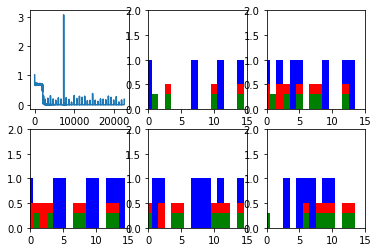

Step 100 Loss 0.00021439914
single_output_series: [0 1 0 0 0 0 1 1 1 0 1 1 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 1 1 0 1 1 0 1 0]

single_output_series: [1 0 0 0 0 1 1 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 0 0 0 1 1 1 0 0 1 1 1 0 0]

single_output_series: [0 0 1 1 0 1 0 0 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 0 1 1 0 1 0 0 0 0 0 0 0 1 1]

single_output_series: [1 1 0 0 0 1 1 0 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [1 1 0 0 0 1 1 0 1 1 0 1 1 1 0]

single_output_series: [0 0 0 0 1 0 0 1 0 0 1 0 0 1 1]
batchY[batch_series_idx, :] [0 0 0 0 1 0 0 1 0 0 1 0 0 1 1]



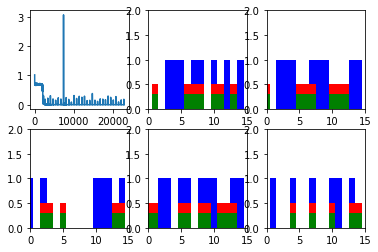

Step 200 Loss 0.00020208329
single_output_series: [1 1 0 1 1 0 1 1 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [1 1 0 1 1 0 1 1 0 0 0 1 1 0 0]

single_output_series: [0 1 0 0 1 1 0 1 0 0 1 1 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 1 1 0 1 0 0 1 1 0 0 1]

single_output_series: [0 0 1 1 1 1 0 1 0 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 1 1 1 1 0 1 0 0 1 0 1 1 1]

single_output_series: [1 1 0 0 0 0 1 1 0 1 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 1 1 0 1 0 0 1 0 1]

single_output_series: [1 0 1 1 0 0 1 0 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 0 1 1 1 0 1 1 0]



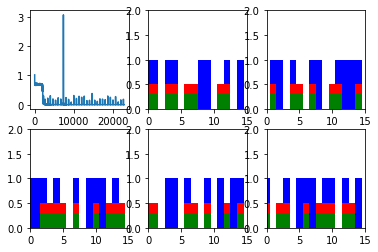

Step 300 Loss 0.00018832482
single_output_series: [1 1 1 1 1 0 0 1 1 0 1 1 0 0 1]
batchY[batch_series_idx, :] [1 1 1 1 1 0 0 1 1 0 1 1 0 0 1]

single_output_series: [1 1 0 1 0 0 0 0 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 0 0 0 0 1 1 0 1]

single_output_series: [0 1 0 1 1 0 0 1 1 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 1 1 0 0 1 1 1 1 1 1 1 1]

single_output_series: [1 1 1 0 0 1 1 1 1 1 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 1 1 1 1 0 1 1 1]

single_output_series: [0 1 0 0 0 0 1 0 0 0 0 0 0 0 1]
batchY[batch_series_idx, :] [0 1 0 0 0 0 1 0 0 0 0 0 0 0 1]



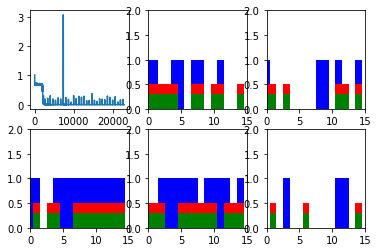

Step 400 Loss 0.00026717628
single_output_series: [1 1 0 1 1 1 0 1 0 1 0 1 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 1 0 1 0 1 0 1 0]

single_output_series: [1 1 1 0 0 0 0 1 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 1 0 1 0 1 1 1]

single_output_series: [1 1 1 0 1 1 0 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 0 0 1 0 1 0 0 0 0]

single_output_series: [0 1 1 0 0 0 0 0 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 0 0 0 0 0 0 1 1 1 1 0 0]

single_output_series: [1 0 1 0 0 0 0 1 1 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 0 1 1 1 1 1 0 1 0]



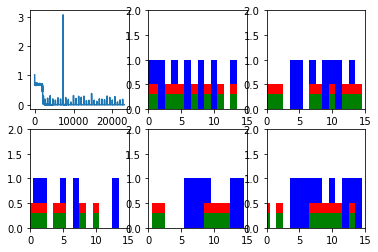

Step 500 Loss 0.00020549688
single_output_series: [1 0 0 0 1 1 1 1 1 0 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 1 1 1 1 1 0 0 1 0 0 1]

single_output_series: [0 0 1 1 1 0 0 1 0 0 0 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 1 0 0 1 0 0 0 0 1 0 0]

single_output_series: [1 1 0 0 0 0 0 0 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 0 0 0 0 1 0 0 0 0 1]

single_output_series: [0 0 1 0 0 0 0 1 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 0 0 1 0 1 1 0 0 0 1]

single_output_series: [1 1 0 1 0 0 0 0 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [1 1 0 1 0 0 0 0 0 1 0 0 0 1 0]



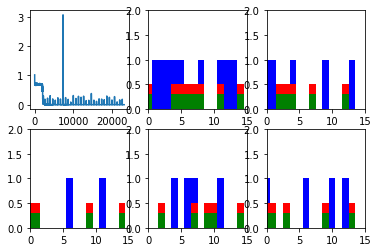

Step 600 Loss 0.00024158925
single_output_series: [0 0 1 0 1 0 0 1 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 0 1 0 0 0 1 1 0 0]

single_output_series: [1 1 0 0 0 1 0 1 0 1 0 0 0 0 1]
batchY[batch_series_idx, :] [1 1 0 0 0 1 0 1 0 1 0 0 0 0 1]

single_output_series: [1 0 1 1 0 0 1 1 0 1 1 1 1 0 1]
batchY[batch_series_idx, :] [1 0 1 1 0 0 1 1 0 1 1 1 1 0 1]

single_output_series: [1 0 1 0 1 1 1 0 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 0 1 1 1 0 0 1 1 1 0 1 0]

single_output_series: [1 0 1 1 1 0 1 0 0 1 1 1 0 1 0]
batchY[batch_series_idx, :] [1 0 1 1 1 0 1 0 0 1 1 1 0 1 0]



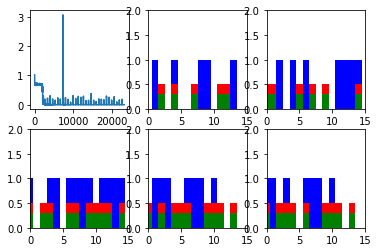

New data, epoch 35
Step 0 Loss 0.21535604
single_output_series: [1 0 1 0 0 0 1 1 0 1 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 1 0 1 0 1 1 0 0]

single_output_series: [1 1 1 1 1 0 1 1 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 1 1 0 1 1 1 1 1 1]

single_output_series: [1 0 1 0 1 0 1 0 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 1 0 0 0 0 1 1 0 1]

single_output_series: [1 0 1 0 0 0 1 0 1 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 0 1 0 0 0 1 0 1 0 0 1 0 0 0]

single_output_series: [1 0 1 0 0 0 0 1 1 1 0 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 1 1 1 0 0 1 1 1]



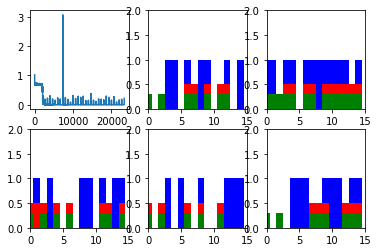

Step 100 Loss 0.0002757122
single_output_series: [1 0 1 0 1 0 1 0 0 0 0 1 0 1 1]
batchY[batch_series_idx, :] [1 0 1 0 1 0 1 0 0 0 0 1 0 1 1]

single_output_series: [0 0 1 0 0 0 1 0 0 1 1 0 0 1 0]
batchY[batch_series_idx, :] [0 0 1 0 0 0 1 0 0 1 1 0 0 1 0]

single_output_series: [0 0 1 0 1 0 1 0 1 0 1 1 1 1 0]
batchY[batch_series_idx, :] [0 0 1 0 1 0 1 0 1 0 1 1 1 1 0]

single_output_series: [0 0 1 1 1 0 1 0 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 1 1 0 1 0 0 1 1 0 0 0 1]

single_output_series: [1 0 1 1 0 1 0 1 0 1 1 1 1 1 1]
batchY[batch_series_idx, :] [1 0 1 1 0 1 0 1 0 1 1 1 1 1 1]



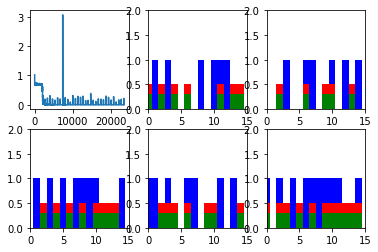

Step 200 Loss 0.00022056779
single_output_series: [0 1 1 0 1 0 0 1 1 1 1 0 1 1 0]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 1 1 1 1 0 1 1 0]

single_output_series: [1 0 0 0 1 0 0 0 0 0 0 0 0 1 1]
batchY[batch_series_idx, :] [1 0 0 0 1 0 0 0 0 0 0 0 0 1 1]

single_output_series: [1 1 1 0 0 1 1 0 0 0 0 1 0 0 0]
batchY[batch_series_idx, :] [1 1 1 0 0 1 1 0 0 0 0 1 0 0 0]

single_output_series: [0 0 0 0 1 1 1 0 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 0 1 1 0 1 1 1 0]

single_output_series: [0 0 0 0 0 0 1 0 1 0 1 0 1 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 1 0 1 0 1 0 1 0 1]



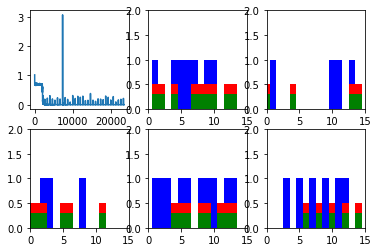

Step 300 Loss 0.00026791138
single_output_series: [0 1 1 1 0 1 0 1 0 1 0 0 0 1 0]
batchY[batch_series_idx, :] [0 1 1 1 0 1 0 1 0 1 0 0 0 1 0]

single_output_series: [0 0 0 0 1 1 1 1 1 1 0 1 1 1 0]
batchY[batch_series_idx, :] [0 0 0 0 1 1 1 1 1 1 0 1 1 1 0]

single_output_series: [0 1 0 0 0 1 0 1 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 1 1 0 1 0 1 1 1]

single_output_series: [1 1 1 0 0 0 0 1 1 0 0 0 1 0 1]
batchY[batch_series_idx, :] [1 1 1 0 0 0 0 1 1 0 0 0 1 0 1]

single_output_series: [0 1 0 0 0 1 0 1 1 1 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 1 1 1 0 0 0 1 1]



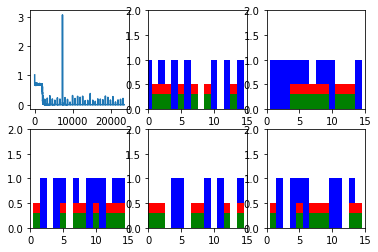

Step 400 Loss 0.00018012109
single_output_series: [0 0 0 0 0 0 0 1 1 0 1 0 1 1 1]
batchY[batch_series_idx, :] [0 0 0 0 0 0 0 1 1 0 1 0 1 1 1]

single_output_series: [0 0 1 0 0 1 0 0 0 1 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 1 0 0 1 0 0 0 1 1 0 0 0 0]

single_output_series: [0 1 1 0 0 1 1 0 1 1 1 1 0 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 0 1 1 1 1 0 0 1]

single_output_series: [0 0 0 1 1 0 0 0 1 1 0 1 0 1 1]
batchY[batch_series_idx, :] [0 0 0 1 1 0 0 0 1 1 0 1 0 1 1]

single_output_series: [1 0 1 1 0 1 1 0 1 1 0 0 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 0 1 1 0 0 1 0 0]



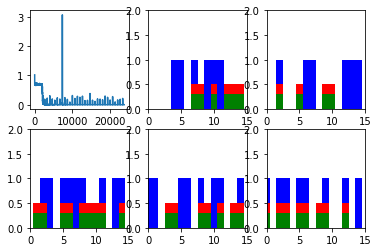

Step 500 Loss 0.0002137953
single_output_series: [1 1 1 0 1 1 1 1 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [1 1 1 0 1 1 1 1 0 0 1 0 0 1 0]

single_output_series: [1 0 0 0 0 0 1 1 1 1 0 1 0 0 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 1 1 1 0 1 0 0 1]

single_output_series: [0 1 1 0 1 0 0 1 0 0 0 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 1 0 0 1 0 0 0 1 1 0 1]

single_output_series: [0 0 0 1 0 1 1 1 1 0 0 1 0 1 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 1 1 1 0 0 1 0 1 0]

single_output_series: [0 1 1 0 0 1 1 1 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [0 1 1 0 0 1 1 1 0 0 1 1 1 0 1]



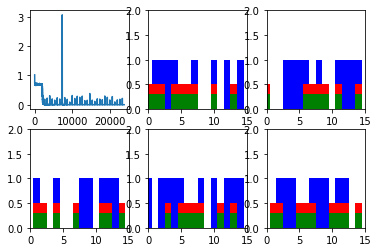

Step 600 Loss 0.00024863548
single_output_series: [0 0 1 1 0 0 0 0 0 1 1 0 1 0 0]
batchY[batch_series_idx, :] [0 0 1 1 0 0 0 0 0 1 1 0 1 0 0]

single_output_series: [1 1 0 0 1 0 1 0 1 1 1 0 1 0 1]
batchY[batch_series_idx, :] [1 1 0 0 1 0 1 0 1 1 1 0 1 0 1]

single_output_series: [1 1 0 1 1 1 0 1 0 0 1 1 1 0 1]
batchY[batch_series_idx, :] [1 1 0 1 1 1 0 1 0 0 1 1 1 0 1]

single_output_series: [0 0 0 0 0 1 1 0 0 1 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 0 0 1 1 0 0 0 1]

single_output_series: [0 1 0 0 0 1 0 1 1 1 0 1 1 1 1]
batchY[batch_series_idx, :] [0 1 0 0 0 1 0 1 1 1 0 1 1 1 1]



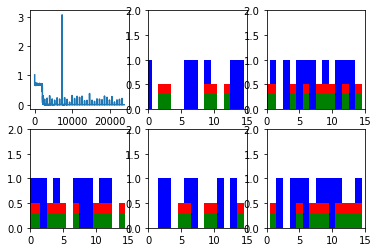

New data, epoch 36
Step 0 Loss 0.18028636
single_output_series: [0 0 0 1 0 1 0 0 1 0 1 0 0 0 0]
batchY[batch_series_idx, :] [0 0 0 1 0 1 0 0 1 0 1 0 0 0 0]

single_output_series: [1 0 0 0 0 0 1 0 0 0 0 0 1 1 1]
batchY[batch_series_idx, :] [1 0 0 0 0 0 1 0 0 0 0 0 1 1 1]

single_output_series: [1 0 0 0 1 1 1 1 0 0 0 1 1 0 0]
batchY[batch_series_idx, :] [0 0 1 0 1 1 1 1 0 0 0 1 1 0 0]

single_output_series: [1 0 0 0 1 0 0 0 0 1 0 1 0 1 1]
batchY[batch_series_idx, :] [1 1 1 0 1 0 0 0 0 1 0 1 0 1 1]

single_output_series: [0 0 0 1 0 1 1 0 0 1 1 1 1 0 0]
batchY[batch_series_idx, :] [1 0 1 1 0 1 1 0 0 1 1 1 1 0 0]



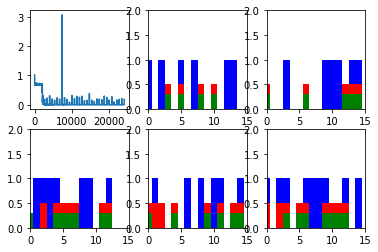

Step 100 Loss 0.00021229123
single_output_series: [0 1 0 1 0 0 0 0 1 0 0 0 0 1 1]
batchY[batch_series_idx, :] [0 1 0 1 0 0 0 0 1 0 0 0 0 1 1]

single_output_series: [0 1 0 0 0 0 0 0 0 0 1 0 0 1 0]
batchY[batch_series_idx, :] [0 1 0 0 0 0 0 0 0 0 1 0 0 1 0]

single_output_series: [0 1 1 1 1 0 1 1 0 0 1 1 1 0 0]
batchY[batch_series_idx, :] [0 1 1 1 1 0 1 1 0 0 1 1 1 0 0]

single_output_series: [0 0 0 0 0 1 1 1 0 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 0 0 0 1 1 1 0 0 1 0 0 0 1]

single_output_series: [0 0 1 0 0 1 1 0 1 0 1 0 0 0 1]
batchY[batch_series_idx, :] [0 0 1 0 0 1 1 0 1 0 1 0 0 0 1]



In [ ]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length

def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

# Unpack columns
inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

# Forward pass
current_state = init_state
states_series = []
for current_input in inputs_series:
    current_input = tf.reshape(current_input, [batch_size, 1])
    input_and_state_concatenated = tf.concat([current_input, current_state], axis=1)  # Increasing number of columns

    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    states_series.append(next_state)
    current_state = next_state

logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [
    tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels
    ) for logits, labels in zip(logits_series,labels_series)
]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])
        print("single_output_series:", single_output_series)
        print("batchY[batch_series_idx, :]",batchY[batch_series_idx, :])
        print("")
        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)


with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()